In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from astroML.classification import GMMBayes
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

from scipy.stats import norm


from astropy.io import ascii
from astropy.io import fits
import os.path

from astropy.table import Table, join, MaskedColumn, vstack, Column


import numpy as np
from astropy.table import vstack
import torch

import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
path = "/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/"

# Notes
- Add in variational dropout 

Many many predictions of a single point

5000 predictions of the distributions

--> then draw one sample from each group of distrobutions

the then cumulative # of distributions (ie z_score plot) removes aleoteric(?, intrinis model) uncertaintiy



Run with full range of parameters
Run with Full lombscargle periodigram
 - Establish baseline

No data augmentation?
Your method of breaking out with data augmentation?

Add noise?
- 300 light curves, add them up?


Squeeze Subsets of lightcurves


3 Different data paradigms:
- No data augmentation
- Full Data Augmentation
- intermediate?
- Lombscargle?


As small a network as possible.

# Load the data and make Test/Valid/Train Splits

In [3]:
#### different commented out lines are different datasets: ####

# Non Periodogram Versions
#data=Table.read(path+'data/Stats_Table_For_Data_augmented_lcs_v2.fits', format='fits') #Length 46889
        # Cut in half + 12 day rolling window
#data=Table.read(path+'data/Stats_Table_For_all_Clusters_all_sectors_w_entropy.fits', format='fits') # 2204
        # Just sector lightcurves
        # every lc here is ~27 days
#data=Table.read(path+'data/Stats_Table_For_Sector_Stitched.fits', format='fits') #Length 348
        # for each cluster stich each of the sectors together


# With Periodogram Versions
#data=Table.read(path+'data/Stats_Table_For_all_Clusters_all_sectors_w_entropy_wPeriodogram.fits', format='fits') #Length=2204
    # Each Full Sector
data=Table.read(path+'data/Stats_Table_AllClusters_HalfSectors_wPeriodogram.fits', format='fits') # Length=4408
    # Each Half Sector



### other ideas for data augmentaiton
    # just the 12 day window
    # just the cut in half
    # Periogram stuff
    # on the stiched lc's
        # adding noise to the sector stiched lightcurves
        # performing a (longer, 50day?) rolling window on the stiched light curves. (min 2 sequential sectors)
        

#### if you want to stack datasets:
# data = vstack([data, sector_stitched])

cluster_data = data
data

<Table length=4408>
      name      ...                 FullPeriodogram                 
    bytes17     ...                  float64[1089]                  
--------------- ... ------------------------------------------------
       NGC 5381 ...   0.011392788345445541 .. 0.00016864060377760296
       NGC 5381 ...    0.040493728927247286 .. 0.0003531227452214391
       NGC 5381 ...   0.018792080664426426 .. 2.2393253925536184e-05
       NGC 5381 ...      0.10648403177704077 .. 0.000307586897251254
   RUPRECHT 172 ...    0.0027777337472355834 .. 0.005993490285279542
   RUPRECHT 172 ... 0.00027149188607177764 .. 0.00018512748884342482
   RUPRECHT 172 ...    0.0009466636165224569 .. 0.000299825333050496
   RUPRECHT 172 ...  0.0019338816958959914 .. 0.00018414894889990784
   RUPRECHT 172 ...   0.008342275192647294 .. 0.00014977163874406566
   RUPRECHT 172 ...   0.015010233547365786 .. 0.00010209258818657236
            ... ...                                              ...
       Bruck 65 ...   0.0007616258149498387 .. 0.0003066177101825511
       Bruck 65 ...   0.003602895647785871 .. 0.00032877058549068223
[PIR2016] VMC23 ...     0.03272581217122249 .. 0.0001495801446107417
[PIR2016] VMC23 ...   0.007455648133548869 .. 0.00036520017024849855
[PIR2016] VMC23 ...     0.03162476508804049 .. 0.0008479151139785381
[PIR2016] VMC23 ...    0.005197514111485705 .. 0.0005877254025759158
       [H86] 87 ...  0.0033508395853645827 .. 0.00043955392876089954
       [H86] 87 ...    0.0004231385317457661 .. 0.000391933518113435
       [H86] 87 ...   0.0015164874010958876 .. 0.0001831867916827675
       [H86] 87 ...  0.0011901887188791329 .. 0.00029440977491813604

In [4]:
def oversample_per_bin(X_summary, y, n_bins=5, X_period=None):
    """
    Oversample so each bin of y has the same number of samples.
    Used to de-bias the model against guesing the sample mean
    
    Parameters
    ----------
    X_summary : np.ndarray
        Summary feature array (N, D).
    y : np.ndarray
        Target array (N,).
    n_bins : int
        Number of equally spaced bins between min(y) and max(y).
    X_period : np.ndarray or None
        Optional periodogram array (N, P) or (N, ...).

    Returns
    -------
    X_summary_resampled : np.ndarray
        Oversampled summary features.
    y_resampled : np.ndarray
        Oversampled targets.
    X_period_resampled : np.ndarray or None
        Oversampled periodogram features, or None if X_period was None.
    """
    # Bin edges from min to max
    bins = np.linspace(y.min(), y.max(), n_bins + 1)
    bin_indices = np.digitize(y, bins) - 1  # bin numbers 0...(n_bins-1)

    # Target density = max count among bins
    counts = np.bincount(bin_indices, minlength=n_bins)
    target_count = counts.max()

    X_list, y_list = [], []
    if X_period is not None:
        Xp_list = []

    # Oversample bin-by-bin
    for b in range(n_bins):
        mask = bin_indices == b
        X_bin = X_summary[mask]
        y_bin = y[mask]
        if X_period is not None:
            Xp_bin = X_period[mask]

        if len(y_bin) == 0:
            continue  # skip empty bins

        # Number of extra samples needed
        reps = target_count - len(y_bin)
        if reps > 0:
            # Sample with replacement
            idx_extra = np.random.choice(len(y_bin), size=reps, replace=True)
            X_bin = np.vstack([X_bin, X_bin[idx_extra]])
            y_bin = np.concatenate([y_bin, y_bin[idx_extra]])
            if X_period is not None:
                Xp_bin = np.vstack([Xp_bin, Xp_bin[idx_extra]])

        # Append oversampled bin
        X_list.append(X_bin)
        y_list.append(y_bin)
        if X_period is not None:
            Xp_list.append(Xp_bin)

    # Combine bins and shuffle
    X_summary_resampled = np.vstack(X_list)
    y_resampled = np.concatenate(y_list)
    if X_period is not None:
        X_period_resampled = np.vstack(Xp_list)
    else:
        X_period_resampled = None

    idx = np.random.permutation(len(y_resampled))
    X_summary_resampled = X_summary_resampled[idx]
    y_resampled = y_resampled[idx]
    if X_period_resampled is not None:
        X_period_resampled = X_period_resampled[idx]
    print(X_summary_resampled.shape, y_resampled.shape, X_period_resampled.shape)
    
    return X_summary_resampled, y_resampled, X_period_resampled



def compute_average_peak_strengths(periodogram_column):
    """
    Computes the average peak strength for each periodogram.
    Used to normalize the periodigram range down to around 0~>1.
    
    Parameters:
    -----------
    periodogram_column : astropy.table.Column or np.ndarray
        2D array-like object of shape (n_samples, n_freqs)

    Returns:
    --------
    np.ndarray
        Array of average peak strengths for each sample.
    """
    periodograms = np.asarray(periodogram_column)  # shape: (N, F)
    n_samples = periodograms.shape[0]
    peaks = np.zeros(n_samples)

    for i in range(n_samples):
        pgram = periodograms[i]
        peaks[i] = np.max(pgram)
        
    return np.mean(peaks)

def add_uniform_noise(y, low=-0.05, high=0.05):
    return y + (torch.rand(y.shape) * (high - low) + low)
    
def get_samples(data, size=35, include_periodogram=True):
    # Splits (by cluster, not just randomly into test, train, validation sets
    # It isn't doing percentages, it is just taking 35 clusters for test, 35 for validation, the rest for train
    # It de-means the y parameter data
    
    grouped = data.group_by('name')
    total_groups = len(grouped.groups)
    
    if size * 2 >= total_groups:
        raise ValueError("Size is too large relative to the number of groups.")
    
    possible_indices = np.arange(total_groups)
    validation_indices = np.random.choice(possible_indices, size=size, replace=False)
    remaining_indices = np.setdiff1d(possible_indices, validation_indices)
    test_indices = np.random.choice(remaining_indices, size=size, replace=False)
    training_indices = np.setdiff1d(remaining_indices, test_indices)
    
    training_data = vstack([grouped.groups[i] for i in training_indices])
    validation_data = vstack([grouped.groups[i] for i in validation_indices])
    test_data = vstack([grouped.groups[i] for i in test_indices])
    
    feature_cols = ['rms', 'std', 'MAD', 'sigmaG', 'skewness', 'von_neumann_ratio',
                    'J_Stetson', 'max_power', 'freq_at_max_power', 'ratio_of_power_at_high_v_low_freq',
                    'max_autocorrelation', 'time_of_max_autocorrelation', 'SumLSP_10_7_Day_Power',
                    'SumLSP_7_4_Day_Power', 'SumLSP_4_1_Day_Power', 'SumLSP_1_p5_Day_Power', 'Entropy']

    # Summary features
    X_train = np.column_stack([training_data[col].reshape(-1, 1) for col in feature_cols])
    X_valid = np.array([validation_data[col].reshape(-1, 1) for col in feature_cols]).T
    X_test  = np.array([test_data[col].reshape(-1, 1) for col in feature_cols]).T

    # Targets
    y_mean = np.mean(training_data['Lit_Clst_Age'])
    print(y_mean)
    y_train = training_data['Lit_Clst_Age'] - y_mean
    y_valid = validation_data['Lit_Clst_Age'] - y_mean
    y_test  = test_data['Lit_Clst_Age'] - y_mean

    X_valid = np.squeeze(X_valid)
    X_test  = np.squeeze(X_test)

    scaler = StandardScaler() # Scale all the input parameters to near a range of 0 to 1 using sklearn standard scaler 
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test  = scaler.transform(X_test)

    
    # Periodogram features (variable-length array column)
    if include_periodogram:
        period_train = np.stack(training_data['FullPeriodogram'].data)
        period_valid = np.stack(validation_data['FullPeriodogram'].data)
        period_test  = np.stack(test_data['FullPeriodogram'].data)

        # Normalize The periodograms by the average max peak strength across the entire training periodograms.
            # Just to normalize the values to be around 0-1
        mean_peak_strength = compute_average_peak_strengths(training_data['FullPeriodogram'])
        period_train = period_train/mean_peak_strength
        period_valid = period_valid/mean_peak_strength
        period_test  = period_test/mean_peak_strength
        
        # Convert to tensors
        period_train = torch.tensor(period_train, dtype=torch.float32)
        period_valid = torch.tensor(period_valid, dtype=torch.float32)
        period_test  = torch.tensor(period_test, dtype=torch.float32)
    else:
        period_train = period_valid = period_test = None


    
    # if include_periodogram:
    #     X_train, y_train, period_train = oversample_per_bin(
    #         X_train, np.asarray(y_train), n_bins=5, X_period=period_train
    #     )
    #     period_train = torch.tensor(period_train, dtype=torch.float32)
    # else:
    #     X_train, y_train, _ = oversample_per_bin(
    #         X_train, np.asarray(y_train), n_bins=5, X_period=None
    #     )

    
    # Convert the rest to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_valid = torch.tensor(X_valid, dtype=torch.float32)
    X_test  = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(np.asarray(y_train), dtype=torch.float32).view(-1, 1)
    y_valid = torch.tensor(np.asarray(y_valid), dtype=torch.float32).view(-1, 1)
    y_test  = torch.tensor(np.asarray(y_test), dtype=torch.float32).view(-1, 1)

    return (
        X_train, X_valid, X_test,
        period_train, period_valid, period_test,
        y_train, y_valid, y_test,
        feature_cols, y_mean, scaler
    )




num_test_clusters = 35                    # Number of test clusters and validation clusters, remaining are training. 
use_periodogram = True                    # Leave as False and it wont load the periodigram data and will return None for those parameters instead.
(
    X_train, X_valid, X_test, 
    period_train, period_valid, period_test, 
    y_train, y_valid, y_test, 
    feature_cols, SCALER, y_mean
) = get_samples(cluster_data, size=num_test_clusters, include_periodogram=use_periodogram)


print("X_train: ", np.shape(X_train))
print("X_valid: ", np.shape(X_valid))
print("X_test: ", np.shape(X_test))
print("period_train: ", np.shape(period_train))
print("period_valid: ", np.shape(period_valid))
print("period_test: ", np.shape(period_test))
print("y_train: ", np.shape(y_train))
print("y_valid: ", np.shape(y_valid))
print("y_test: ", np.shape(y_test))
print("feature_cols: ", feature_cols)

7.964531387665199
X_train:  torch.Size([3632, 17])
X_valid:  torch.Size([310, 17])
X_test:  torch.Size([466, 17])
period_train:  torch.Size([3632, 1089])
period_valid:  torch.Size([310, 1089])
period_test:  torch.Size([466, 1089])
y_train:  torch.Size([3632, 1])
y_valid:  torch.Size([310, 1])
y_test:  torch.Size([466, 1])
feature_cols:  ['rms', 'std', 'MAD', 'sigmaG', 'skewness', 'von_neumann_ratio', 'J_Stetson', 'max_power', 'freq_at_max_power', 'ratio_of_power_at_high_v_low_freq', 'max_autocorrelation', 'time_of_max_autocorrelation', 'SumLSP_10_7_Day_Power', 'SumLSP_7_4_Day_Power', 'SumLSP_4_1_Day_Power', 'SumLSP_1_p5_Day_Power', 'Entropy']


## Some plotting windows to visualize the data:

rms
std
MAD
sigmaG
skewness
von_neumann_ratio
J_Stetson
max_power
freq_at_max_power
ratio_of_power_at_high_v_low_freq
max_autocorrelation
time_of_max_autocorrelation
SumLSP_10_7_Day_Power
SumLSP_7_4_Day_Power
SumLSP_4_1_Day_Power
SumLSP_1_p5_Day_Power
Entropy


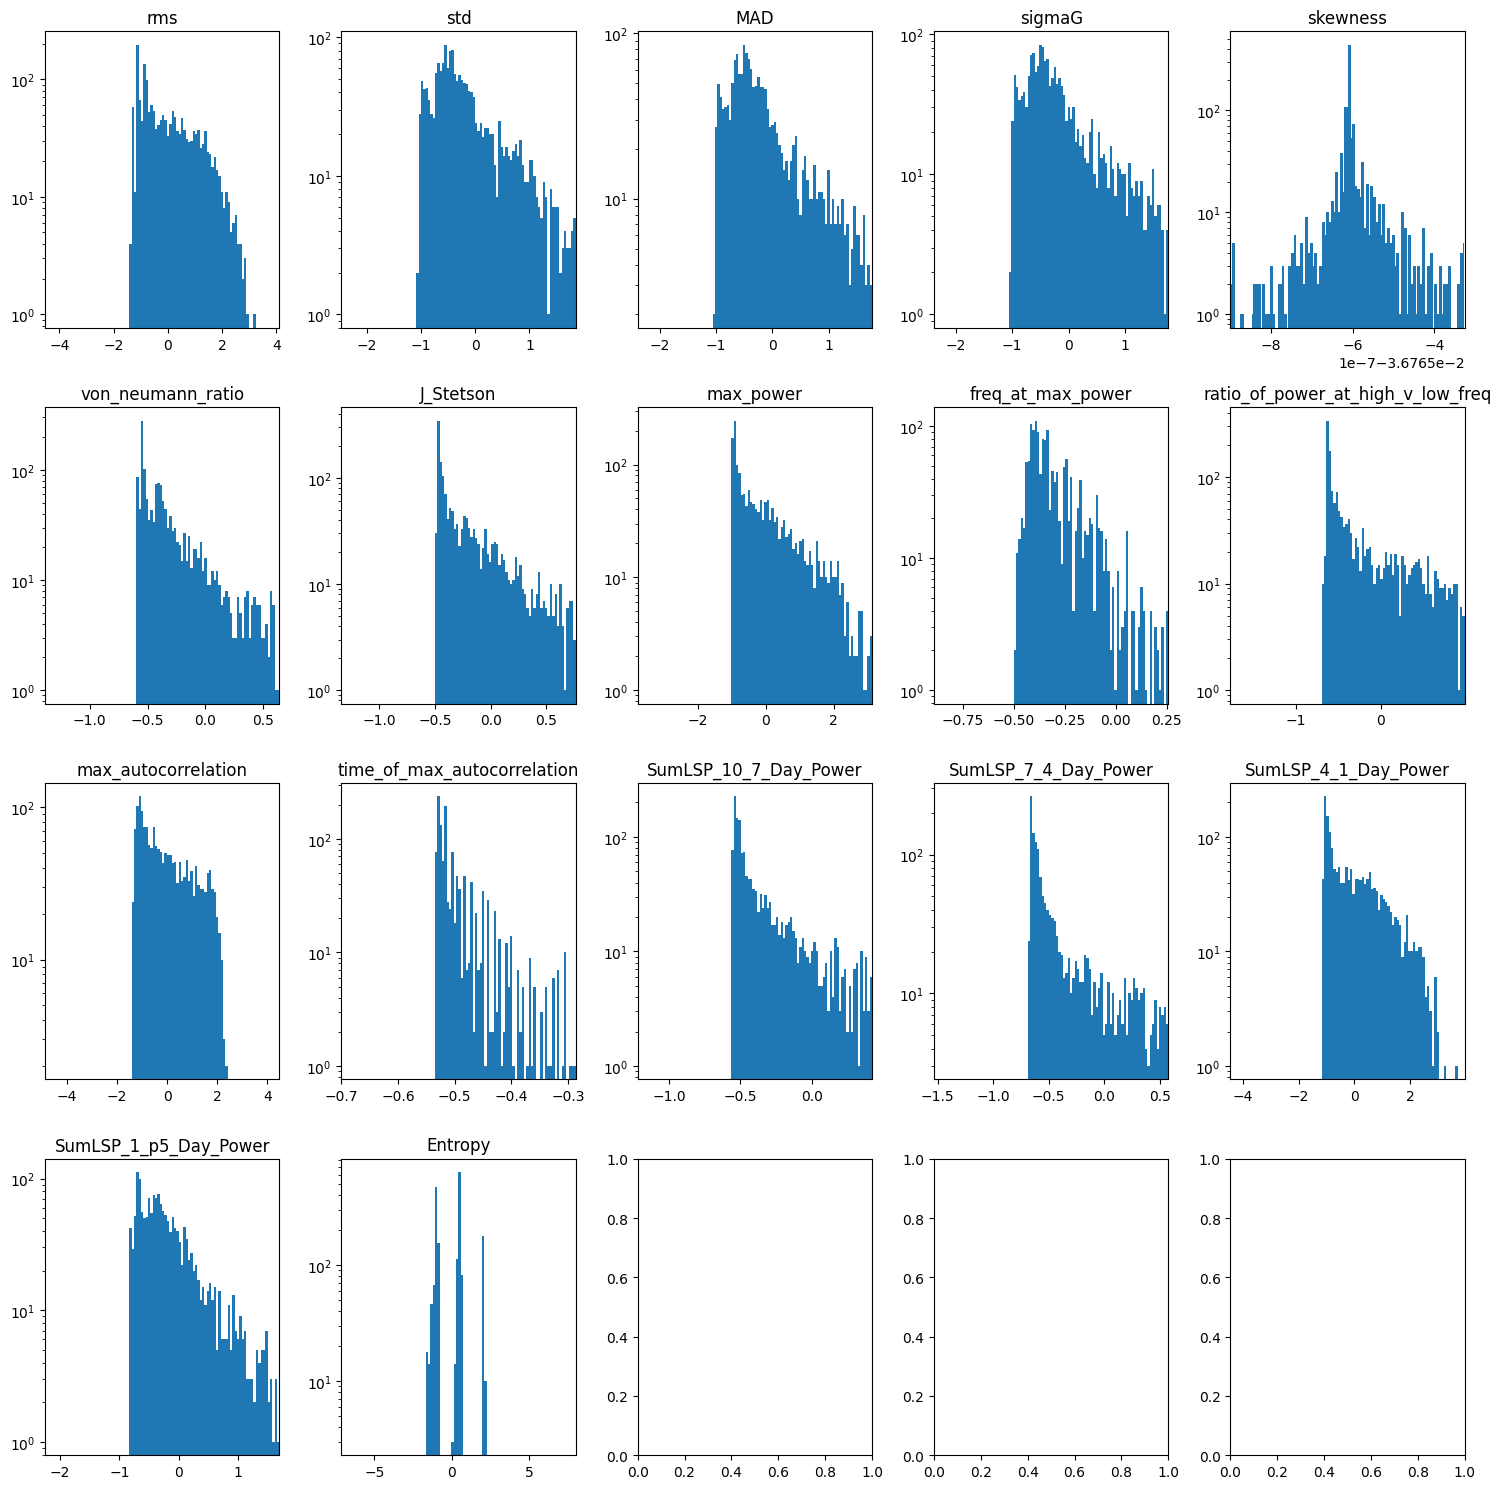

In [10]:
# Full histogram illustrating the data:

fig, axs = plt.subplots(4, 5, figsize=(15,15))
data = X_train

for index, col in enumerate(feature_cols):
    i = index // 5
    j = index % 5
    #print(i, j, col)
    print(col)
    median = np.nanmedian(data[:, index])  # Ignore NaNs
    mad = np.nanmedian(np.abs(data[:, index] - median))  # Compute MAD
    scale_factor = 1.4826  # Approximate conversion to std deviation
    lower_bound = median - 4 * scale_factor * mad
    upper_bound = median + 4 * scale_factor * mad
    
    axs[i, j].hist(data[:, index], bins=100, range=(lower_bound, upper_bound))
    axs[i, j].set_title(col)
    axs[i, j].set_yscale('log')
    axs[i, j].set_xlim([lower_bound, upper_bound])

plt.tight_layout()
plt.show()

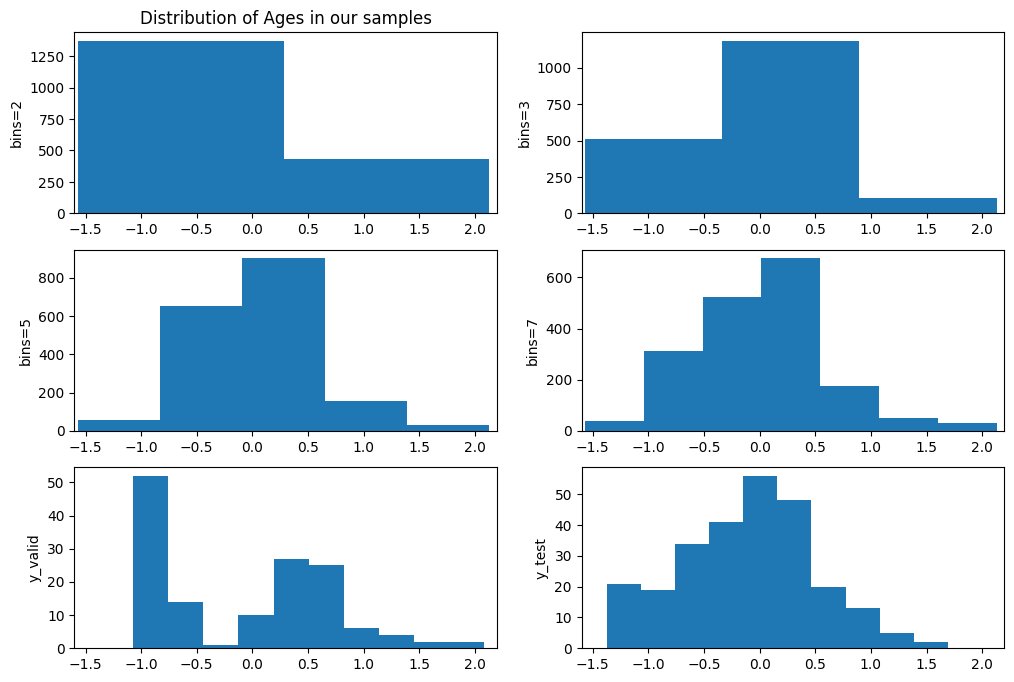

In [361]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
axs[0, 0].set_title('Distribution of Ages in our samples')

axs[0, 0].hist(y_train, bins=2)
axs[0, 0].set_ylabel('bins=2')

axs[0, 1].hist(y_train, bins=3)
axs[0, 1].set_ylabel('bins=3')

axs[1, 0].hist(y_train, bins=5)
axs[1, 0].set_ylabel('bins=5')

axs[1, 1].hist(y_train, bins=7)
axs[1, 1].set_ylabel('bins=7')

axs[2, 0].hist(y_valid)
axs[2, 0].set_ylabel('y_valid')
axs[2, 1].hist(y_test)
axs[2, 1].set_ylabel('y_test')


for axs_row in axs:
    for ax in axs_row:
        ax.set_xlim([-1.6, 2.2])


In [359]:
len(X_train), len(X_valid), len(X_test)

(4335, 190, 219)

In [ ]:
35 - validation
35 - testing
280 - training
training -> oversample points low/high


350 - 10, 10

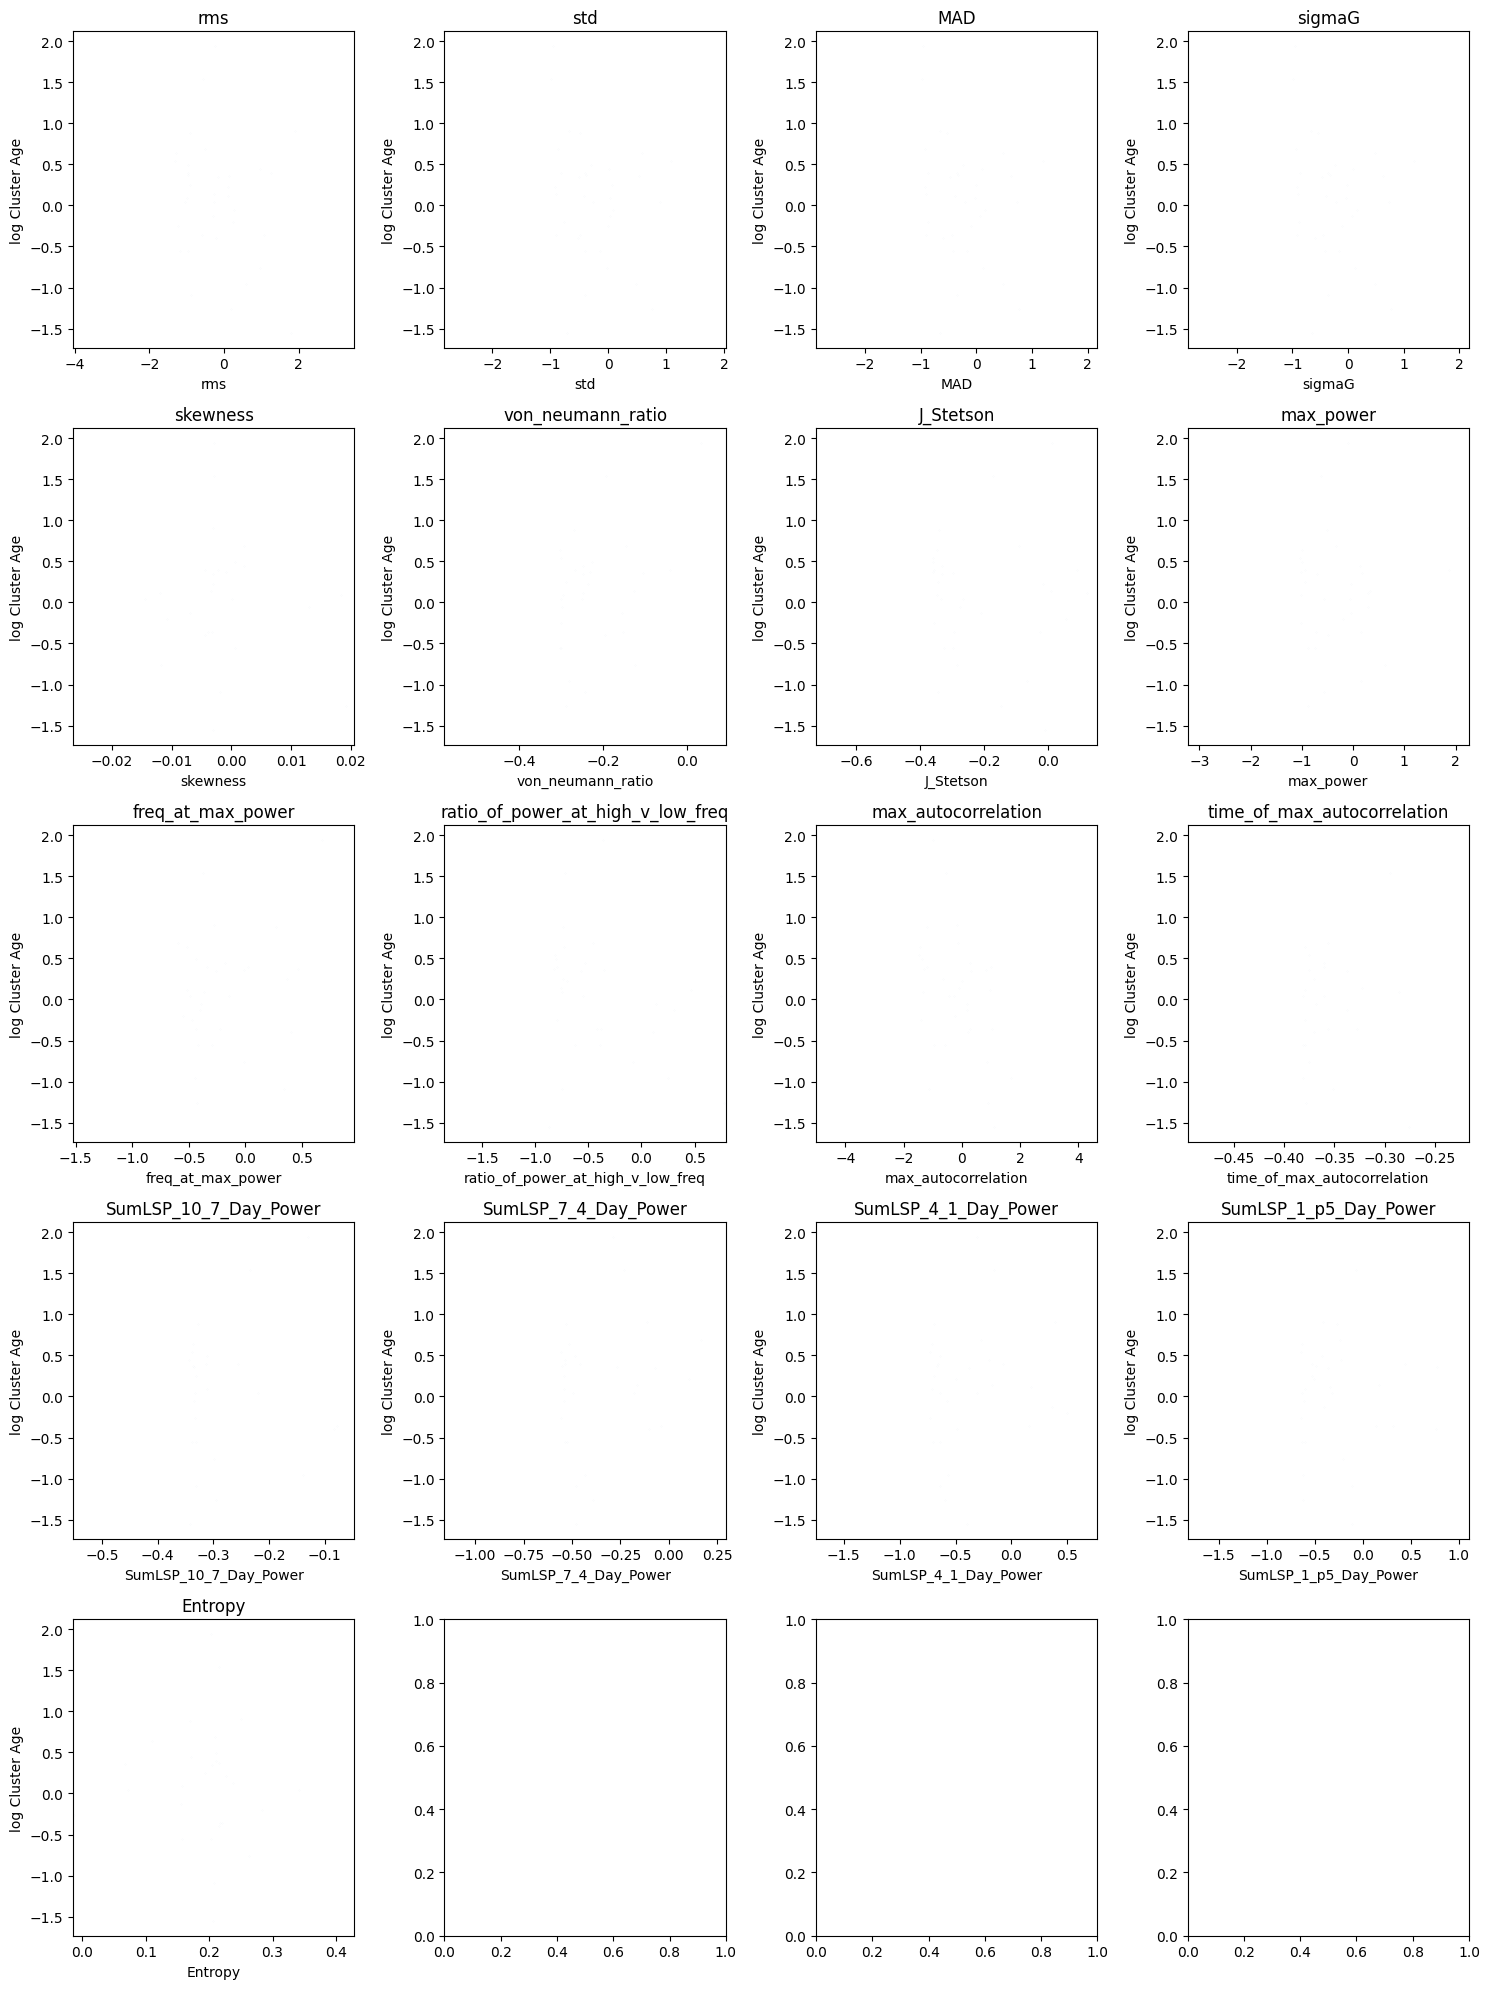

In [81]:
# Full histogram illustrating the data:

fig, axs = plt.subplots(5, 4, figsize=(15,20))

data = X_valid
data_y = y_valid
for index, col in enumerate(feature_cols):
    i = index // 4
    j = index % 4
    #print(i, j, col)
    median = np.nanmedian(data[:, index])  # Ignore NaNs
    mad = np.nanmedian(np.abs(data[:, index] - median))  # Compute MAD
    scale_factor = 1.4826  # Approximate conversion to std deviation
    lower_bound = median - 4 * scale_factor * mad
    upper_bound = median + 4 * scale_factor * mad
    
    axs[i, j].scatter(data[:, index], data_y, s=0.01, alpha=0.1)
    axs[i, j].set_title(col)
    #axs[i, j].set_yscale('log')
    axs[i, j].set_xlim([lower_bound, upper_bound])
    axs[i, j].set_xlabel(col)
    axs[i, j].set_ylabel('log Cluster Age')

plt.tight_layout()
plt.show()

# Define The Models

### Models W/O Uncertainty (IGNORE THESE, They are old)

In [115]:
import torch
import torch.nn as nn
import torch.nn.init as init

class FlexibleNN(nn.Module):
    def __init__(self, input_dim, layer_dims, activation_fn="relu", init_method="xavier", dropout_rate=0.0, use_batchnorm=False):
        """
        A flexible feedforward neural network with optional batch normalization and dropout.

        Parameters:
            input_dim (int): Number of input features.
            layer_dims (list of int): List of neuron counts for each hidden layer. The last value is the output layer size.
            activation_fn (str): Activation function ("relu", "tanh", "sigmoid", "leaky_relu", "none").
            init_method (str): Weight initialization method ("xavier", "kaiming", "small_random", "orthogonal", "hybrid").
            dropout_rate (float): Dropout probability (0.0 means no dropout).
            use_batchnorm (bool): If True, applies Batch Normalization after each Linear layer.
        """
        super(FlexibleNN, self).__init__()

        self.layers = nn.ModuleList()
        self.batchnorms = nn.ModuleList() if use_batchnorm else None
        self.dropouts = nn.ModuleList() if dropout_rate > 0 else None
        self.activation_fn = activation_fn.lower()
        self.init_method = init_method.lower()
        self.use_batchnorm = use_batchnorm
        self.dropout_rate = dropout_rate

        prev_dim = input_dim
        for i, dim in enumerate(layer_dims):
            self.layers.append(nn.Linear(prev_dim, dim))
            if use_batchnorm:
                self.batchnorms.append(nn.BatchNorm1d(dim))
            if dropout_rate > 0:
                self.dropouts.append(nn.Dropout(p=dropout_rate))
            prev_dim = dim

        # Apply weight initialization
        self.apply(self._init_weights)

    def _init_weights(self, m):
        """Custom weight initialization function."""
        if isinstance(m, nn.Linear):
            if self.init_method == "kaiming":
                init.kaiming_normal_(m.weight, nonlinearity="relu")
            elif self.init_method == "xavier":
                init.xavier_normal_(m.weight)
            elif self.init_method == "small_random":
                init.normal_(m.weight, mean=0.0, std=0.01)
            elif self.init_method == "orthogonal":
                init.orthogonal_(m.weight)
            elif self.init_method == "hybrid":
                # Hybrid initialization: Kaiming for hidden layers, Xavier for output
                if m in self.layers[:-1]:
                    init.kaiming_normal_(m.weight, nonlinearity="relu")
                else:
                    init.xavier_normal_(m.weight)

            init.zeros_(m.bias)  # Initialize biases to zero

    def forward(self, x):
        """Forward pass through the network."""
        for i, layer in enumerate(self.layers[:-1]):  # All layers except last
            x = layer(x)
            if self.use_batchnorm:
                x = self.batchnorms[i](x)
            x = self._apply_activation(x)
            if self.dropout_rate > 0:
                x = self.dropouts[i](x)

        x = self.layers[-1](x)  # Output layer (no activation)
        return x

    def _apply_activation(self, x):
        """Applies the chosen activation function."""
        if self.activation_fn == "relu":
            return torch.relu(x)
        elif self.activation_fn == "tanh":
            return torch.tanh(x)
        elif self.activation_fn == "sigmoid":
            return torch.sigmoid(x)
        elif self.activation_fn == "leaky_relu":
            return torch.nn.functional.leaky_relu(x, negative_slope=0.01)
        return x  # No activation if "none"


# Example usage
params = {
    "input_dim": 10,
    "layer_dims": [128, 64, 1],  # Hidden layers + output
    "activation_fn": "relu",
    "init_method": "xavier",
    "dropout_rate": 0.2,  # 20% dropout
    "use_batchnorm": True  # Enable Batch Normalization
}

model = FlexibleNN(**params)
print(model)


FlexibleNN(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (batchnorms): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropouts): ModuleList(
    (0-2): 3 x Dropout(p=0.2, inplace=False)
  )
)


hi
Training model 1/3 with 10 trials
Trial 1/10
    Epoch 1/200, Training Loss: 0.4546, Validation Loss: 0.3302
    Epoch 11/200, Training Loss: 0.2996, Validation Loss: 0.2283
    Epoch 21/200, Training Loss: 0.2684, Validation Loss: 0.2170
    Epoch 31/200, Training Loss: 0.2534, Validation Loss: 0.2005
    Epoch 41/200, Training Loss: 0.2434, Validation Loss: 0.2052
    Epoch 51/200, Training Loss: 0.2353, Validation Loss: 0.1962
    Epoch 61/200, Training Loss: 0.2284, Validation Loss: 0.1922
    Epoch 71/200, Training Loss: 0.2219, Validation Loss: 0.1885
    Epoch 81/200, Training Loss: 0.2158, Validation Loss: 0.1860
    Epoch 91/200, Training Loss: 0.2099, Validation Loss: 0.1834
    Epoch 101/200, Training Loss: 0.2044, Validation Loss: 0.1802
    Epoch 111/200, Training Loss: 0.1993, Validation Loss: 0.1775
    Epoch 121/200, Training Loss: 0.1944, Validation Loss: 0.1761
    Epoch 131/200, Training Loss: 0.1897, Validation Loss: 0.1743
    Epoch 141/200, Training Loss: 0.185

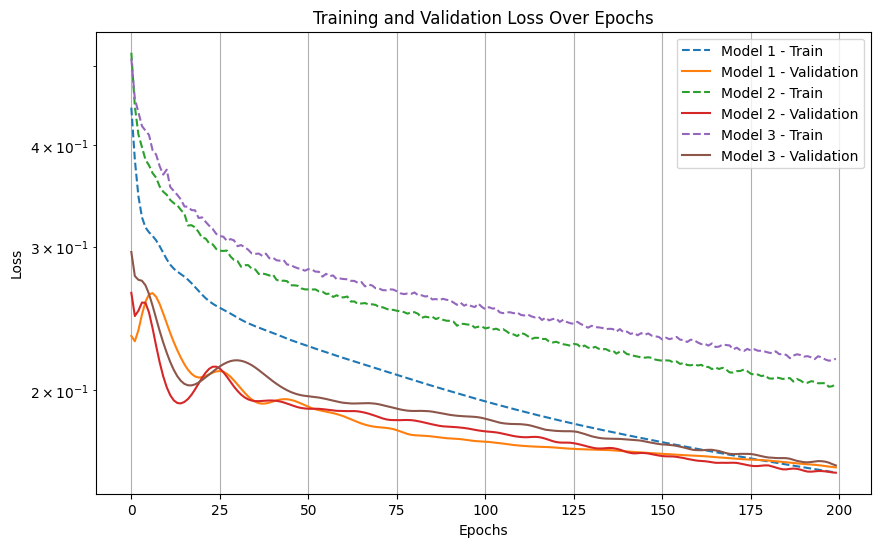

In [140]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt



# Function to train a single model and track losses and validation errors
def train_single_model(model, X_train, y_train, X_valid, y_valid, n_epochs=200, lr=0.001, loss_fn=None, plot_results=False):
    """
    Trains a single model and tracks its loss and validation errors over epochs.
    
    Parameters:
        model: The model to train.
        X_train, y_train: Training data and labels.
        X_valid, y_valid: Validation data and labels.
        n_epochs (int): Number of training epochs.
        lr (float): Learning rate.
        loss_fn: Loss function to use (e.g., MSELoss, etc.).
        plot_results (bool): Whether to plot the training and validation losses.
        
    Returns:
        best_model: The best model based on validation loss.
        loss_array (numpy.ndarray): Array of training losses.
        val_loss_array (numpy.ndarray): Array of validation losses.
    """
    loss_array = np.zeros(n_epochs)
    val_loss_array = np.zeros(n_epochs)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    best_val_loss = float("inf")
    best_model = None

    # Training loop for a single model
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Validation loss
        model.eval()
        with torch.no_grad():
            y_valid_pred = model(X_valid)
            val_loss = loss_fn(y_valid_pred, y_valid).item()

        # Track losses
        loss_array[epoch] = loss.item()
        val_loss_array[epoch] = val_loss

        # Update best model if necessary
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model

        if epoch % 10 == 0:
            print(f"    Epoch {epoch+1}/{n_epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}")

    # Optionally plot the training and validation losses
    # if plot_results:
    #     plot_training_loss(loss_array, val_loss_array)

    return best_model, loss_array, val_loss_array

def train_multiple_models(model_architectures, X_train, y_train, X_valid, y_valid, n_epochs=200, lr=0.001, loss_fn=None, plot_results=False, n_trials=1):
    """
    Trains multiple models and tracks their losses and validation errors over epochs.
    Each model is trained multiple times (n_trials), and only the best model is kept.

    Parameters:
        models (list): List of model instances to train.
        X_train, y_train: Training data and labels.
        X_valid, y_valid: Validation data and labels.
        n_epochs (int): Number of training epochs.
        lr (float): Learning rate.
        loss_fn: Loss function to use.
        plot_results (bool): Whether to plot the training and validation losses.
        n_trials (int): Number of trials to run for each model, the best performing model is kept.

    Returns:
        best_models (list): List of best models for each model definition after n_trials.
        loss_arrays (numpy.ndarray): Array of training losses for each model.
        val_loss_arrays (numpy.ndarray): Array of validation losses for each model.
    """
    trained_models = []
    loss_arrays = []
    val_loss_arrays = []

    for i, model_params in enumerate(model_architectures):
        print(f"Training model {i+1}/{len(model_architectures)} with {n_trials} trials")

        # Initialize variables to track the best model over all trials
        best_trial_model = None
        best_trial_val_loss = float('inf')
        best_loss_array = None
        best_val_loss_array = None

        # Run the specified number of trials for each model
        for trial in range(n_trials):
            #print(model_params)
            model = FlexibleNN(**model_params)

            print(f"Trial {trial+1}/{n_trials}")
            trained_model, loss_array, val_loss_array = train_single_model(
                model, X_train, y_train, X_valid, y_valid, n_epochs, lr, loss_fn, plot_results=False
            )

            # Keep track of the best model based on validation loss
            final_val_loss = val_loss_array[-1]  # Get the final validation loss of the trial
            if final_val_loss < best_trial_val_loss:
                best_trial_val_loss = final_val_loss
                best_trial_model = trained_model
                best_loss_array = loss_array
                best_val_loss_array = val_loss_array

        # After all trials, append the best model and its losses
        trained_models.append(best_trial_model)
        loss_arrays.append(best_loss_array)
        val_loss_arrays.append(best_val_loss_array)

    # Optionally plot the results
    if plot_results:
        plot_training_loss(np.asarray(loss_arrays), np.asarray(val_loss_arrays))

    return trained_models, np.array(loss_arrays), np.array(val_loss_arrays)

# Function to plot the training and validation losses for all models
def plot_training_loss(training_loss, validation_loss, model_names=None):
    """
    Plots the training and validation losses for all models.
    
    Parameters:
        training_loss (numpy.ndarray): 2D array of training losses (n_models x n_epochs).
        validation_loss (numpy.ndarray): 2D array of validation losses (n_models x n_epochs).
        model_names (list of str, optional): Names of the models for labeling.
    """
    n_models, n_epochs = training_loss.shape

    plt.figure(figsize=(10, 6))

    for i in range(n_models):
        label = model_names[i] if model_names is not None else f"Model {i+1}"
        plt.plot(range(n_epochs), training_loss[i], label=f"{label} - Train", linestyle='--')
        plt.plot(range(n_epochs), validation_loss[i], label=f"{label} - Validation")

    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_final_models(models, X, Y, model_architectures, y_mean=0):
    """
    Plots the final predictions for each model, including incorrect predictions and extreme errors.
    
    Parameters:
        models (list): List of trained models to evaluate.
        X (torch.Tensor): Input data (features).
        Y (torch.Tensor): True labels (target values).
        model_names (list of str): List of model names for labeling the plots.
        y_mean (float): Mean of the target values to reverse normalization if necessary.
    """
    Y = Y.numpy().flatten()
    Y += y_mean  # Adjust if necessary (inverse normalization, etc.)
    
    if not isinstance(models, list):  # Allow single model input
        models = [models]
    
    fig, axs = plt.subplots(2, len(models), figsize=(5 * len(models), 10))  # 2 rows, N columns
    
    if len(models) == 1:
        axs = np.expand_dims(axs, axis=1)  # Ensure axs is 2D for consistency

    for i, model in enumerate(models):
        model_name = model_architectures[i]['activation_fn'] + '_' + model_architectures[i]['init_method'] + '_' + str(model_architectures[i]['layer_dims'])
        # Evaluate on test data
        model.eval()
        with torch.no_grad():
            # Get predictions
            y_pred = model(X)
            y_pred += y_mean  # Adjust if necessary (inverse normalization, etc.)
        
        # Convert tensors to numpy arrays
        y_pred = y_pred.numpy().flatten()

        
        # Scatter plot of true vs predicted values
        axs[0, i].scatter(Y, y_pred, color='blue', alpha=0.1)        
        axs[0, i].set_title(f"{model_name}: All Predictions")
        axs[0, i].annotate(f"Mean Error: {np.mean(np.abs(y_pred - Y)):.2f}", 
                           xy=(0.05, 0.95), xycoords='axes fraction', 
                           fontsize=10, color='black', backgroundcolor='white')

        # Filter incorrect predictions (|error| > 1)
        incorrect = np.abs(y_pred - Y) > 1
        axs[1, i].scatter(Y[incorrect], y_pred[incorrect], color='blue', alpha=0.5)
        axs[1, i].set_title(f"{model_name}: Incorrect Predictions (|error| > 1)")

    # Formatting
    for ax_row in axs:
        for ax in ax_row:
            a, b = np.min(Y), np.max(Y)
            ax.plot([a, b], [a, b], color='red', linestyle='--', label="True values")
            
            ax.set_xlim([np.min(Y)-1, np.max(Y)+1])
            ax.set_ylim([np.min(Y)-1, np.max(Y)+1])
            #ax.set_yscale('log')
            ax.set_xlabel('True Values')
            ax.set_ylabel('Predicted Values')
            ax.legend()

    plt.tight_layout()
    plt.show()




# Example usage:
input_dim = X_train.shape[1]

params1 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "relu",
    "init_method": "xavier",
    "dropout_rate": 0.0,  # 20% dropout
    "use_batchnorm": False  # Enable Batch Normalization
}


params2 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "relu",
    "init_method": "xavier",
    "dropout_rate": 0.15,  # 20% dropout
    "use_batchnorm": False  # Enable Batch Normalization
}


params3 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "relu",
    "init_method": "xavier",
    "dropout_rate": 0.3,  # 20% dropout
    "use_batchnorm": False  # Enable Batch Normalization
}



model_architectures=[params1, params2, params3]

print('hi')
# Train models and plot results
models, loss_arrays, val_loss_arrays = train_multiple_models(
    model_architectures=model_architectures,
    X_train=X_train,  y_train=y_train,
    X_valid=X_valid,  y_valid=y_valid,
    n_epochs=200, lr=0.001,
    loss_fn=torch.nn.MSELoss(), #torch.nn.SmoothL1Loss(), #torch.nn.MSELoss(), #huber_loss = nn.SmoothL1Loss()
    plot_results=True,     
    n_trials=10  # Train each model 5 times, keeping the best one
)

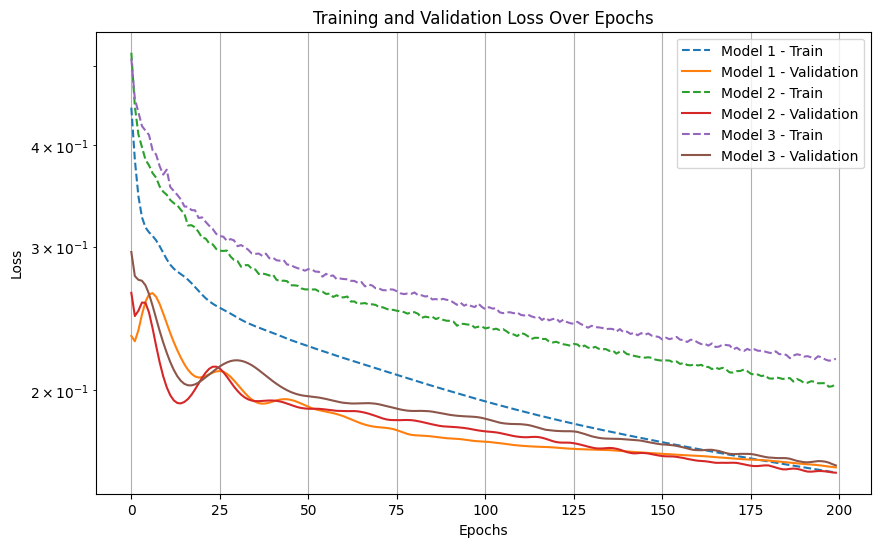

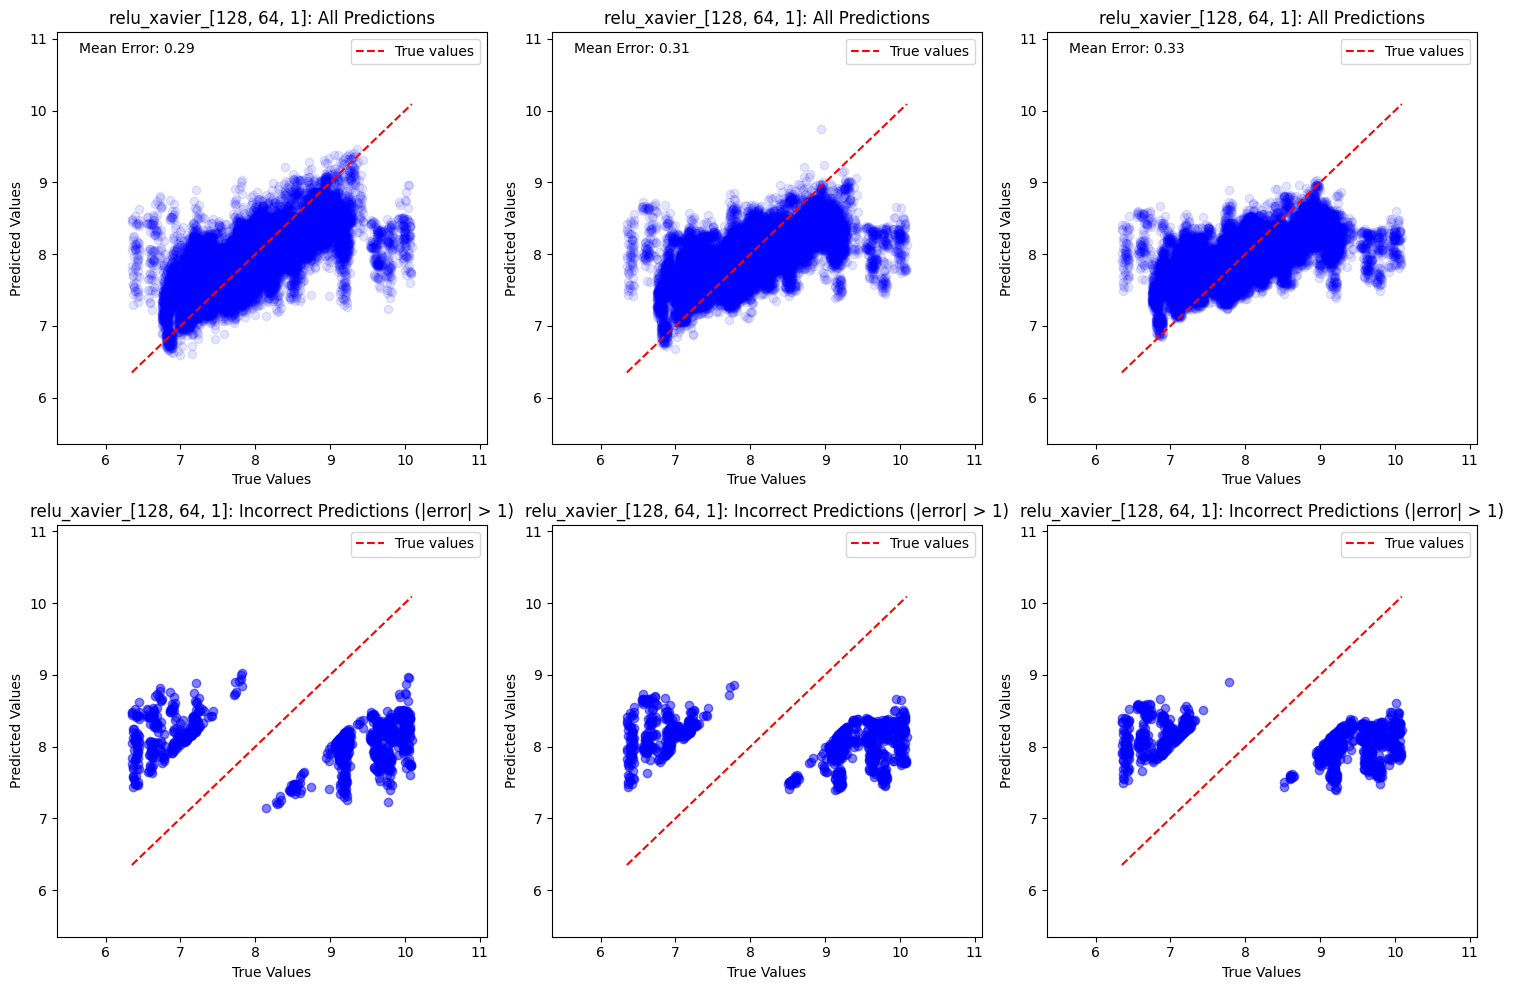

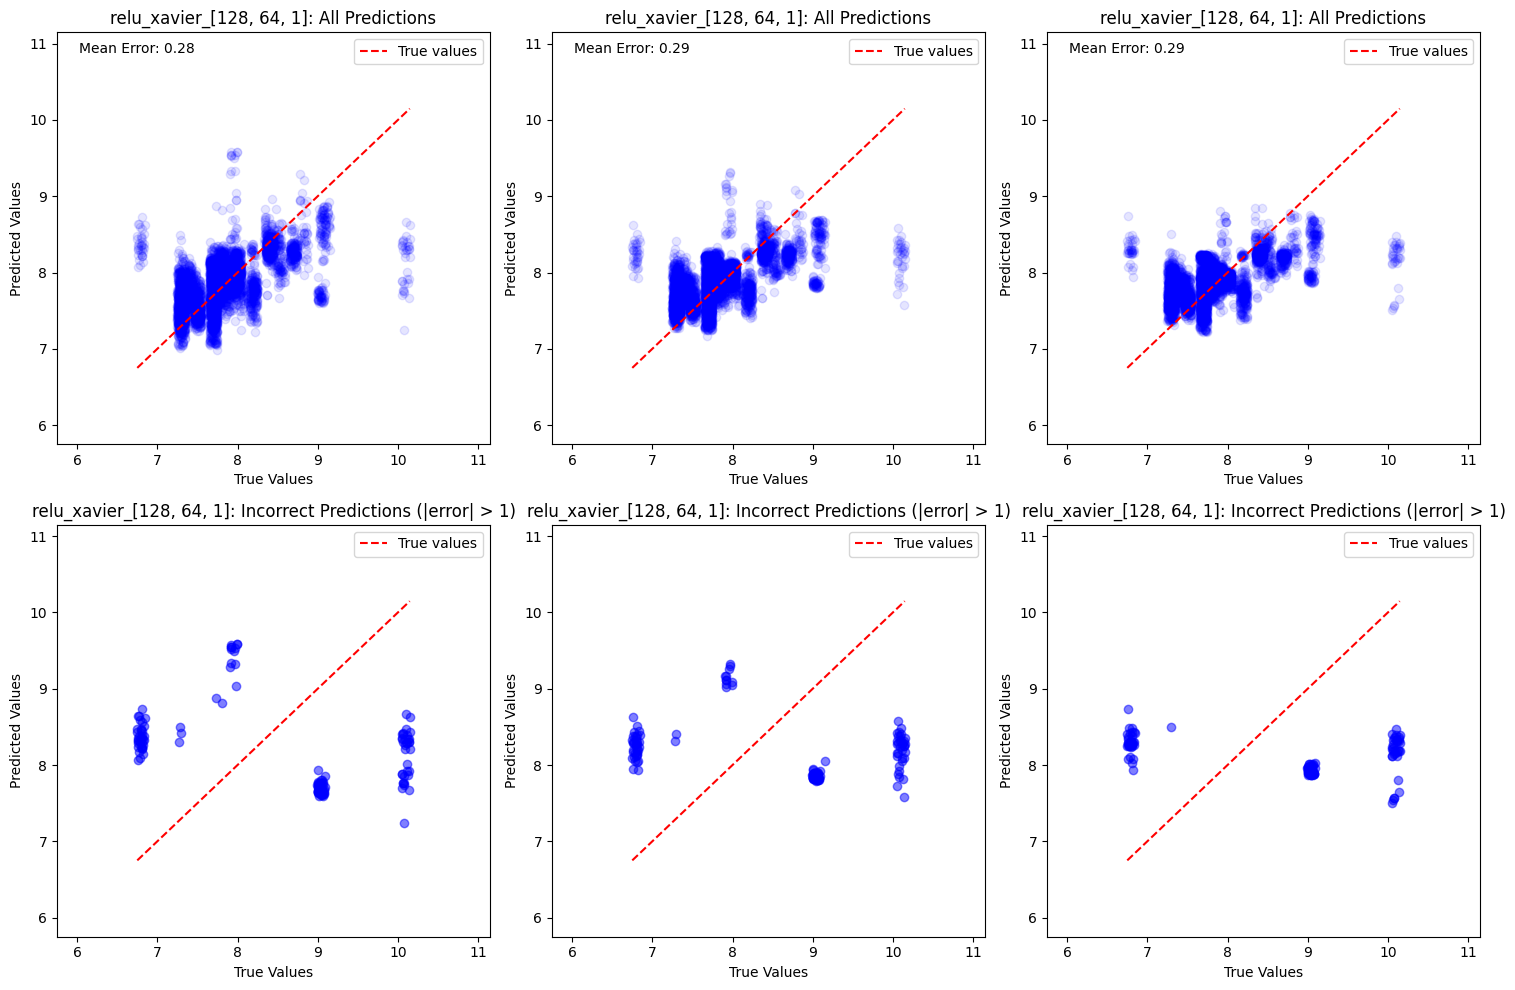

In [141]:

plot_training_loss(loss_arrays, val_loss_arrays)
plot_final_models(models, X_train, y_train, model_architectures, y_mean=y_mean)
plot_final_models(models, X_valid, y_valid, model_architectures, y_mean=y_mean)

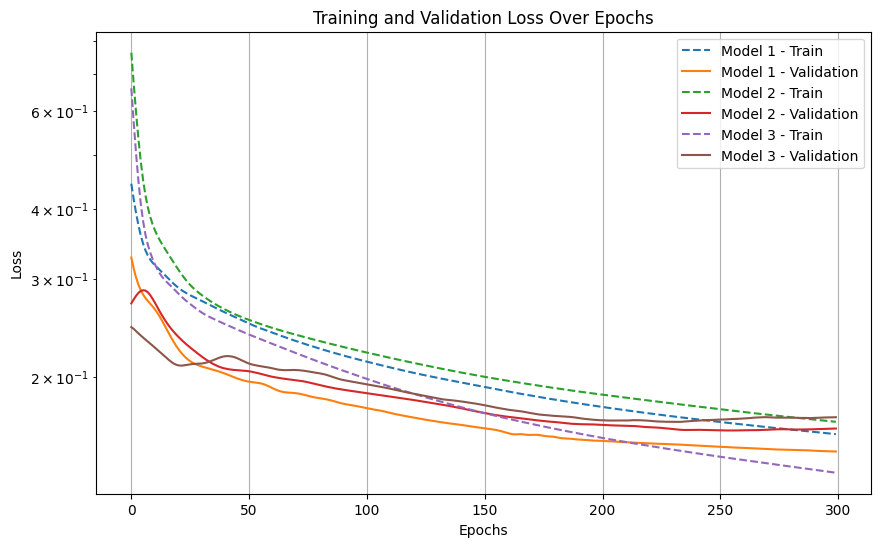

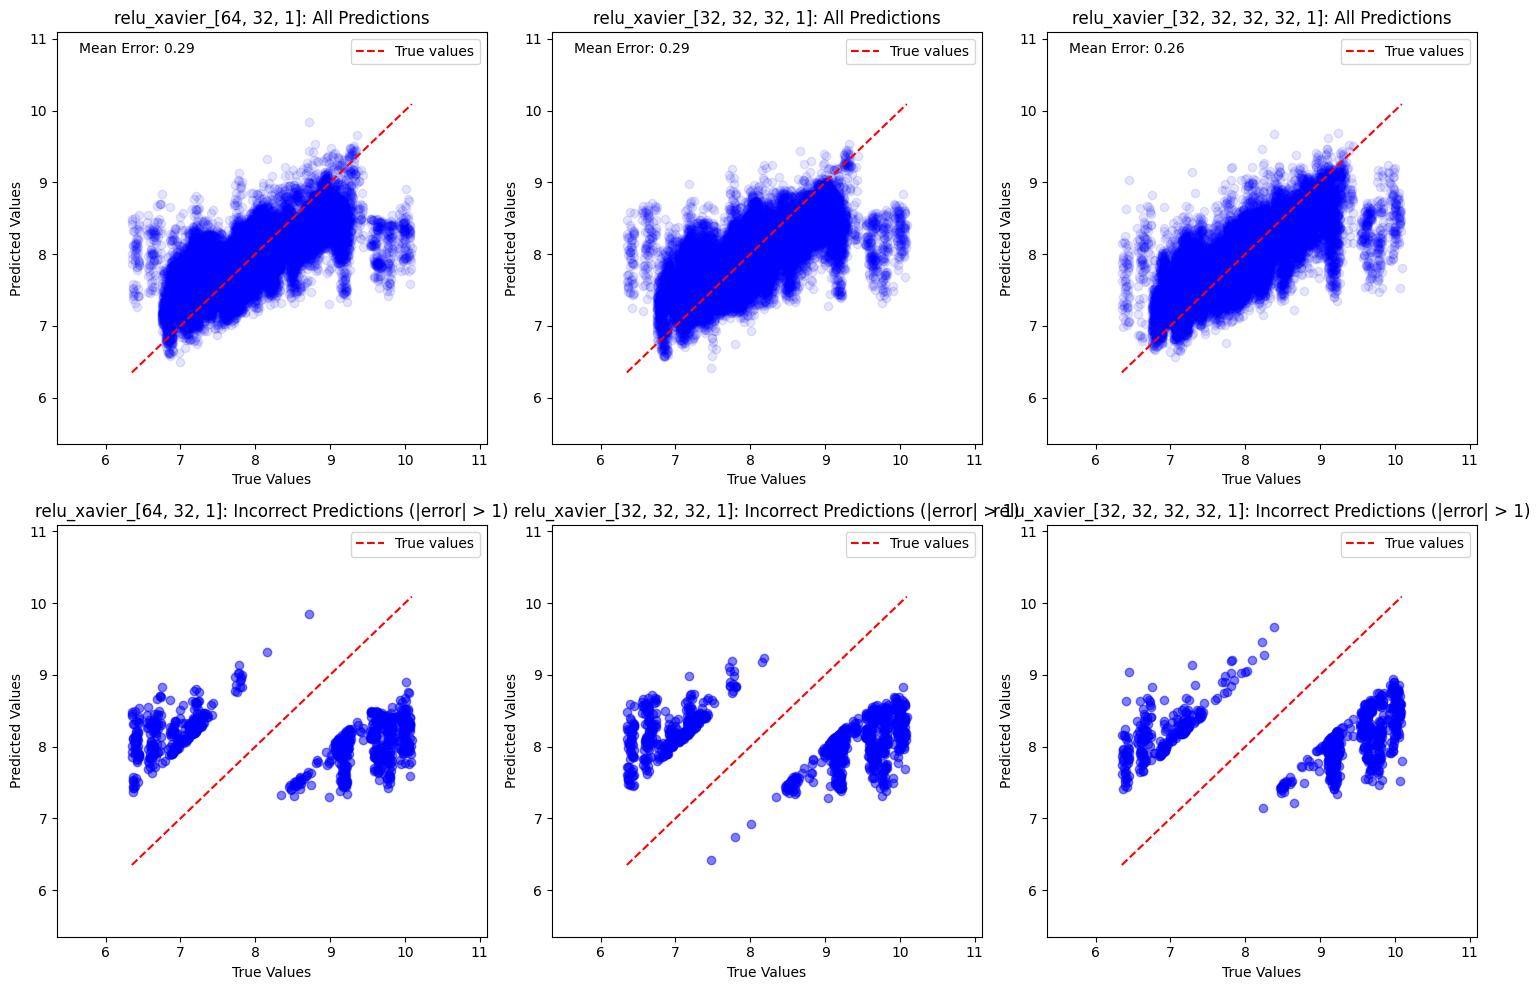

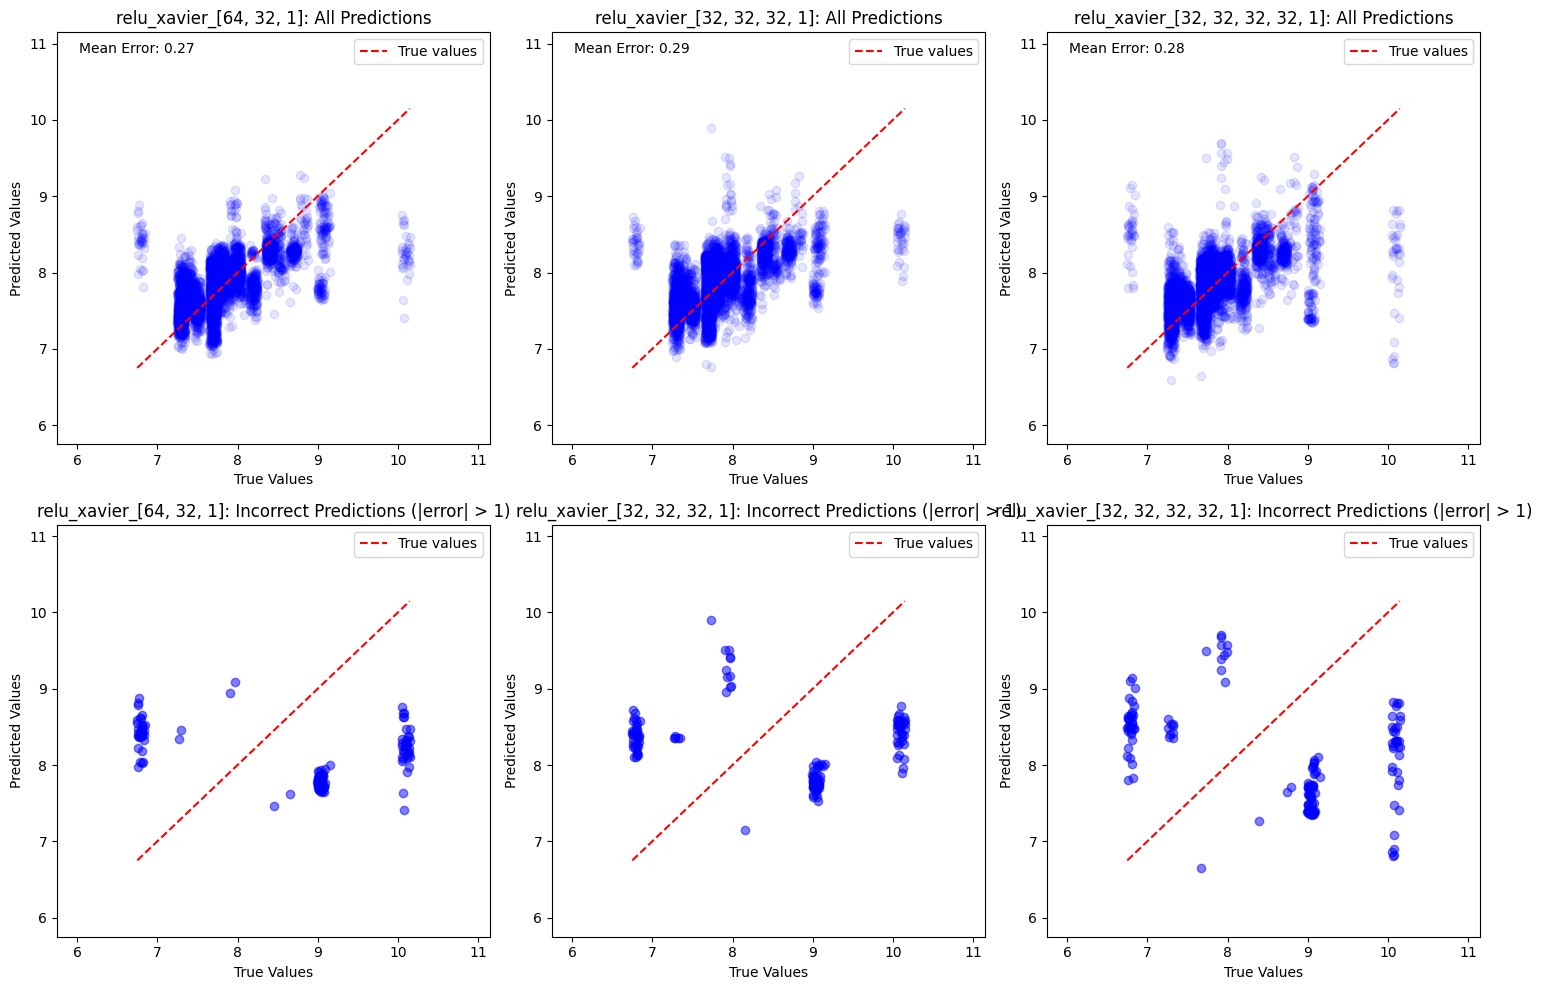

In [135]:

plot_training_loss(loss_arrays, val_loss_arrays)
plot_final_models(models, X_train, y_train, model_architectures, y_mean=y_mean)
plot_final_models(models, X_valid, y_valid, model_architectures, y_mean=y_mean)

In [75]:
str(model_architectures[i]['layer_dims'])

'[128, 64, 1]'

hi
Training model 1/4 with 10 trials
Trial 1/10
    Epoch 1/50, Training Loss: 0.3621, Validation Loss: 0.4130
Trial 2/10
    Epoch 1/50, Training Loss: 0.3497, Validation Loss: 0.4601
Trial 3/10
    Epoch 1/50, Training Loss: 0.3673, Validation Loss: 0.4697
Trial 4/10
    Epoch 1/50, Training Loss: 0.3519, Validation Loss: 0.4169
Trial 5/10
    Epoch 1/50, Training Loss: 0.3947, Validation Loss: 0.4805
Trial 6/10
    Epoch 1/50, Training Loss: 0.4608, Validation Loss: 0.4377
Trial 7/10
    Epoch 1/50, Training Loss: 0.3390, Validation Loss: 0.4119
Trial 8/10
    Epoch 1/50, Training Loss: 0.3995, Validation Loss: 0.3928
Trial 9/10
    Epoch 1/50, Training Loss: 0.3785, Validation Loss: 0.4476
Trial 10/10
    Epoch 1/50, Training Loss: 0.5587, Validation Loss: 0.5703
Training model 2/4 with 10 trials
Trial 1/10
    Epoch 1/50, Training Loss: 0.3365, Validation Loss: 0.4483
Trial 2/10
    Epoch 1/50, Training Loss: 0.3688, Validation Loss: 0.4144
Trial 3/10
    Epoch 1/50, Training Loss

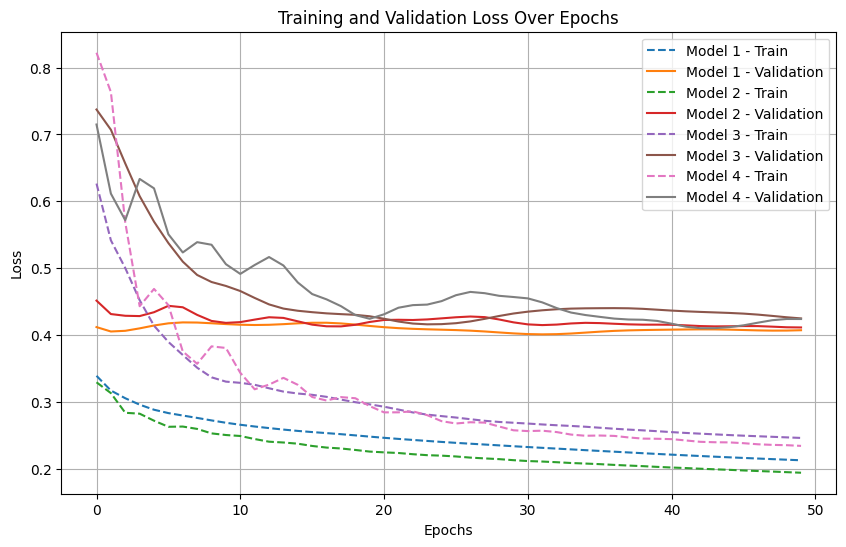

In [89]:

# Example usage:
input_dim = X_train.shape[1]

params1 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "relu",
    "init_method": "xavier",
}

params2 = {
    "input_dim": input_dim,
    "layer_dims": [256, 128, 1],
    "activation_fn": "relu",
    "init_method": "xavier",
}

params3 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "tanh",
    "init_method": "kaiming",
}

params4 = {
    "input_dim": input_dim,
    "layer_dims": [256, 128, 1],
    "activation_fn": "tanh",
    "init_method": "kaiming",
}

model_architectures=[params1, params2, params3, params4]

print('hi')
# Train models and plot results
models, loss_arrays, val_loss_arrays = train_multiple_models(
    model_architectures=model_architectures,
    X_train=X_train,  y_train=y_train,
    X_valid=X_valid,  y_valid=y_valid,
    n_epochs=50, lr=0.001,
    loss_fn=torch.nn.MSELoss(),
    plot_results=True,     
    n_trials=10  # Train each model 5 times, keeping the best one
)

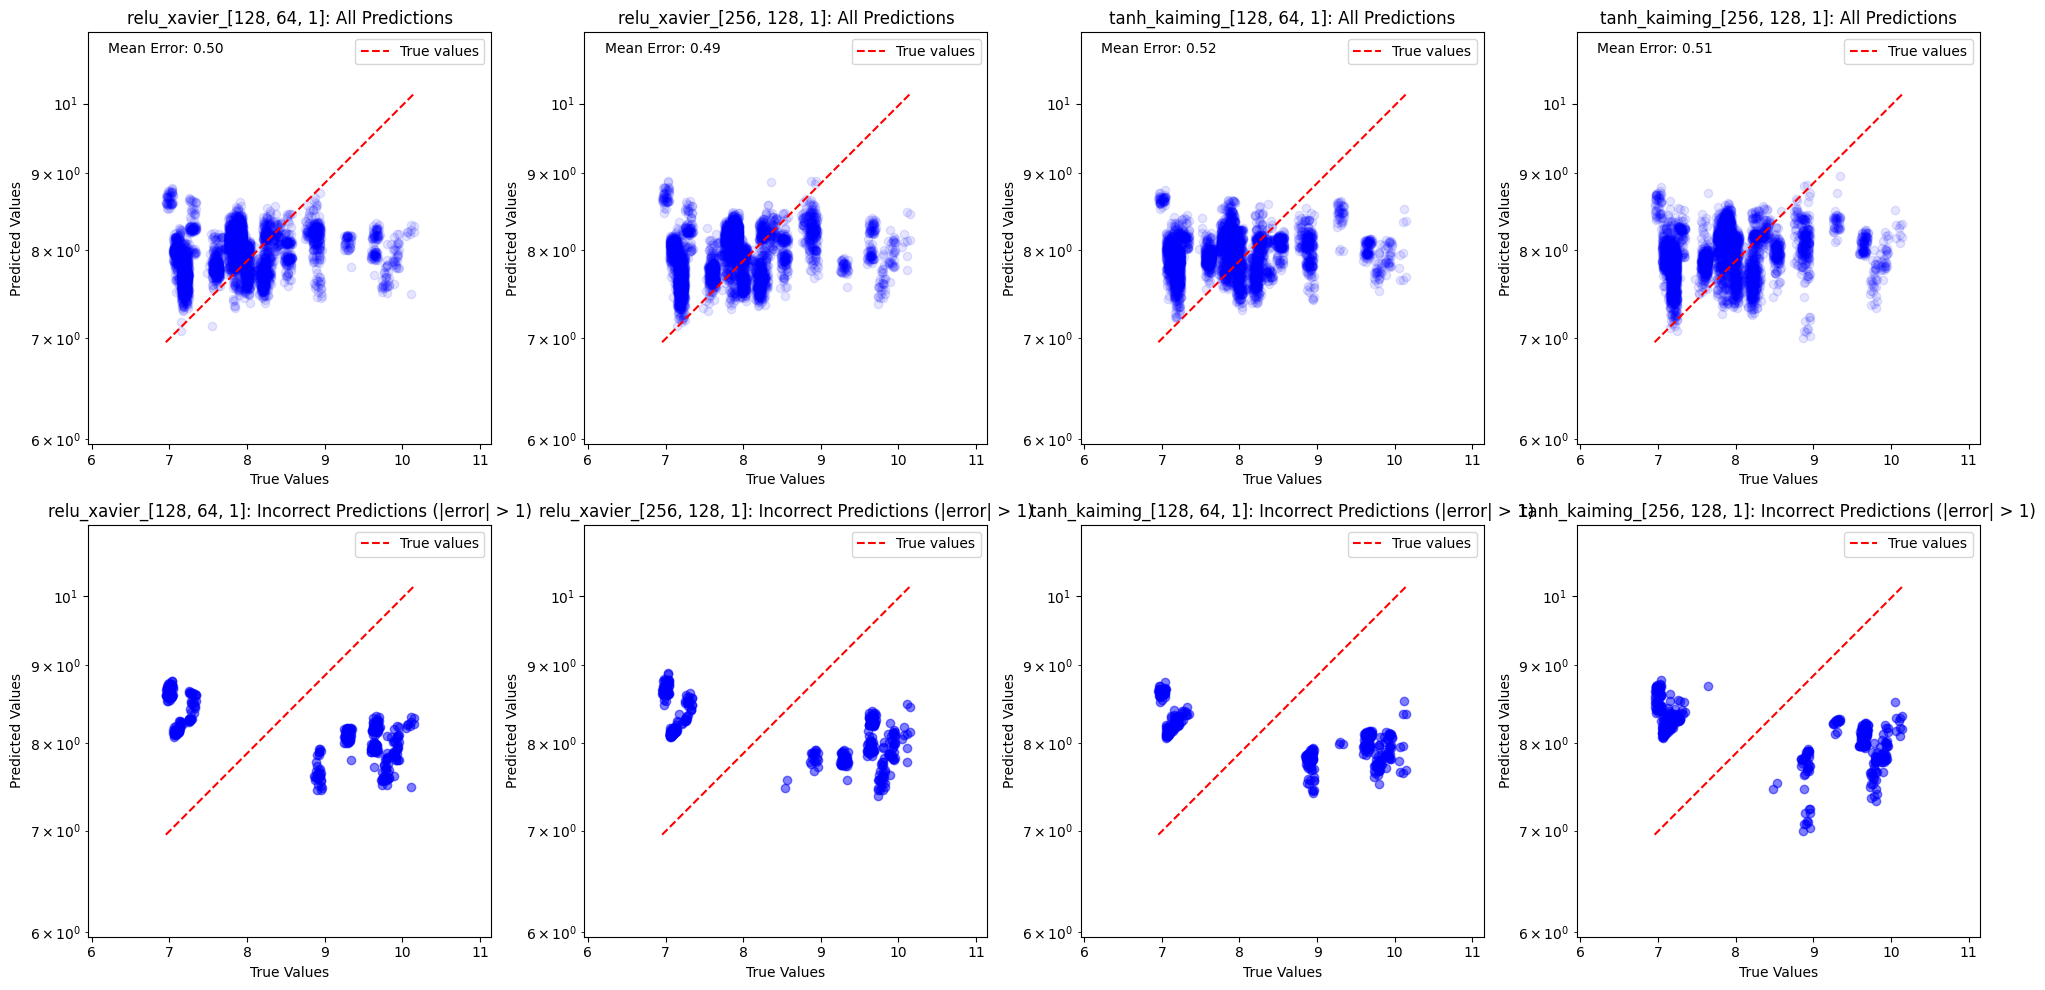

In [90]:
plot_final_models(models, X_valid, y_valid, model_architectures, y_mean=y_mean)

hi
Training model 1/3 with 10 trials
Trial 1/10
    Epoch 1/200, Training Loss: 0.5231, Validation Loss: 0.6014
    Epoch 11/200, Training Loss: 0.3092, Validation Loss: 0.4989
    Epoch 21/200, Training Loss: 0.2964, Validation Loss: 0.4967
    Epoch 31/200, Training Loss: 0.2912, Validation Loss: 0.4957
    Epoch 41/200, Training Loss: 0.2887, Validation Loss: 0.4950
    Epoch 51/200, Training Loss: 0.2874, Validation Loss: 0.4941
    Epoch 61/200, Training Loss: 0.2863, Validation Loss: 0.4913
    Epoch 71/200, Training Loss: 0.2853, Validation Loss: 0.4912
    Epoch 81/200, Training Loss: 0.2845, Validation Loss: 0.4902
    Epoch 91/200, Training Loss: 0.2838, Validation Loss: 0.4892
    Epoch 101/200, Training Loss: 0.2832, Validation Loss: 0.4885
    Epoch 111/200, Training Loss: 0.2827, Validation Loss: 0.4876
    Epoch 121/200, Training Loss: 0.2821, Validation Loss: 0.4867
    Epoch 131/200, Training Loss: 0.2816, Validation Loss: 0.4860
    Epoch 141/200, Training Loss: 0.281

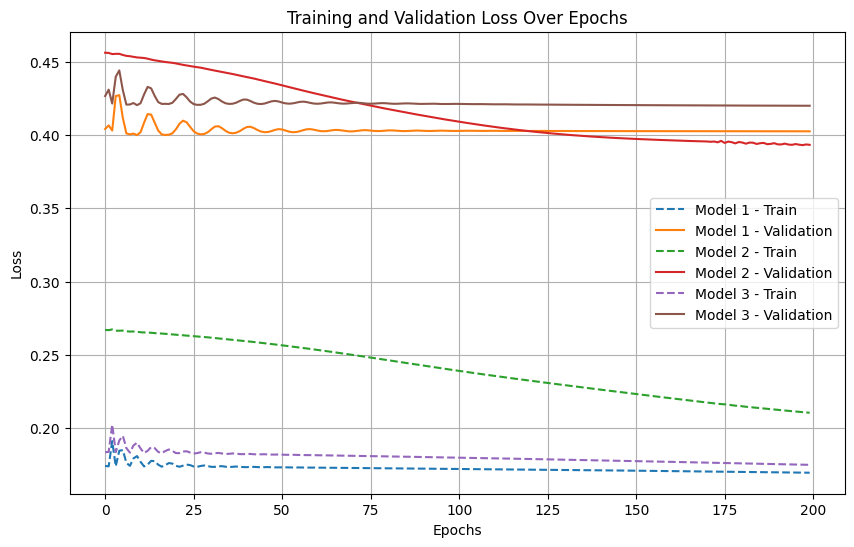

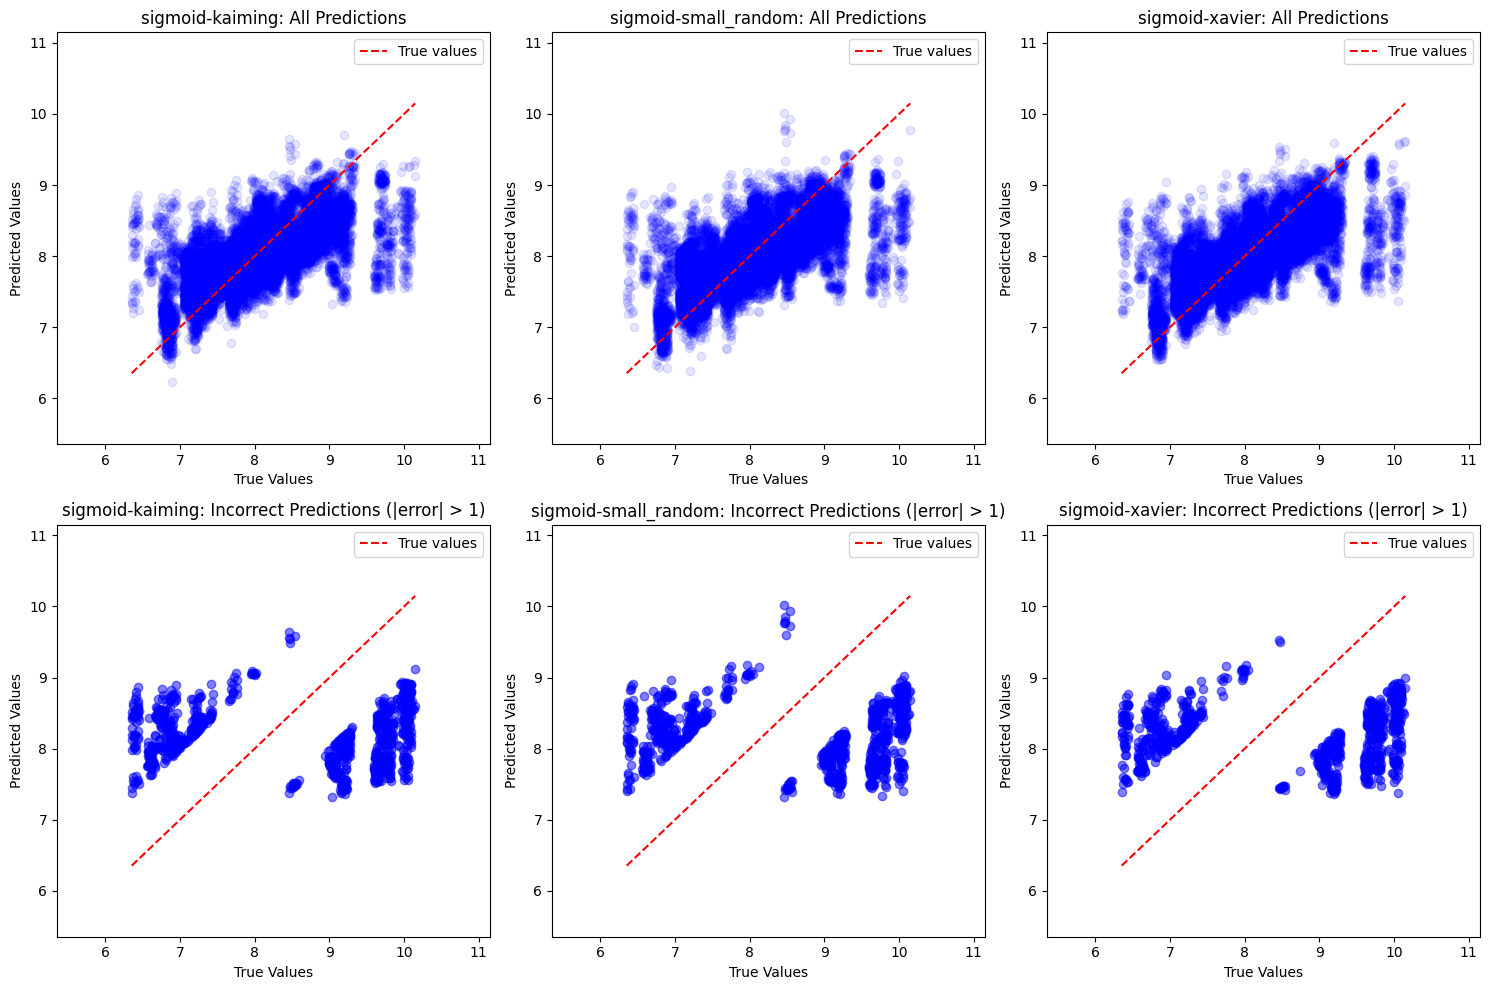

In [49]:

# Example usage:
input_dim = X_train.shape[1]

params1 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "sigmoid",
    "init_method": "kaiming",
}

params2 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "sigmoid",
    "init_method": "small_random",
}

params3 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "sigmoid",
    "init_method": "xavier",
}

# Create model instances
model1 = FlexibleNN(**params1)
model2 = FlexibleNN(**params2)
model3 = FlexibleNN(**params3)

print('hi')
# Train models and plot results
models, loss_arrays, val_loss_arrays = train_multiple_models(
    models=[model3, model2, model1],
    X_train=X_train,  y_train=y_train,
    X_valid=X_valid,  y_valid=y_valid,
    n_epochs=200, lr=0.001,
    loss_fn=torch.nn.MSELoss(),
    plot_results=True,     
    n_trials=10  # Train each model 5 times, keeping the best one
)

models

plot_final_models(models, X_train, y_train, ['sigmoid-kaiming', 'sigmoid-small_random', 'sigmoid-xavier'], y_mean=y_mean)

In [ ]:

# Example usage:
input_dim = X_train.shape[1]

params1 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "sigmoid",
    "init_method": "kaiming",
}

params2 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "sigmoid",
    "init_method": "small_random",
}

params3 = {
    "input_dim": input_dim,
    "layer_dims": [128, 64, 1],
    "activation_fn": "sigmoid",
    "init_method": "xavier",
}

# Create model instances
model1 = FlexibleNN(**params1)
model2 = FlexibleNN(**params2)
model3 = FlexibleNN(**params3)

print('hi')
# Train models and plot results
models, loss_arrays, val_loss_arrays = train_multiple_models(
    models=[model3, model2, model1],
    X_train=X_train,  y_train=y_train,
    X_valid=X_valid,  y_valid=y_valid,
    n_epochs=200, lr=0.001,
    loss_fn=torch.nn.MSELoss(),
    plot_results=True,     
    n_trials=10  # Train each model 5 times, keeping the best one
)

models

plot_final_models(models, X_train, y_train, ['sigmoid-kaiming', 'sigmoid-small_random', 'sigmoid-xavier'], y_mean=y_mean)

In [31]:
# Plot the Results:

# Train MultiModel:

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
from torch.distributions.normal import Normal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import ParameterGrid

import copy
import warnings


In [5]:
import torch
import torch.nn as nn
import torch.nn.init as init

# This is the nueral network model.
# It 
class DualInputNN(nn.Module):
    '''
    This is the primary Nueral Network Model.
    Depending on the inputs at definition, 
        it will/wont use the periodigram data
        it will/wont be a CNN
    So it has multiple possible architectures.
    '''
    def __init__(self,
                 summary_dim,
                 periodogram_dim=0,
                 x1=64,
                 dropout_prob=0.3,
                 use_periodogram=True,
                 periodogram_use_cnn=False,
                 learn_sigma=True):  # NEW FLAG
        super(DualInputNN, self).__init__()
        ''' 
        summary_dim = # of summary statistics
        periodogram_dim = # of frequency bins on periodigrams
        x1 = hidden layer size
        dropout_prob = dropout probability (for regularization and MC-Dropout testing)
        use_periodogram = enable/disable using the periodgram in the model
        periodogram_use_cnn = enable/disable using CNN vs a linear model for the periodgram.
        learn_sigma = enable/disable having the model predict uncertainties (if False will output a constant uncertainty of 0.1)
        ''' 
        
        self.use_periodogram = use_periodogram
        self.periodogram_use_cnn = periodogram_use_cnn
        self.learn_sigma = learn_sigma  # NEW ATTR

        # Summary stats branch (always active)
        self.summary_branch = nn.Sequential(
            nn.Linear(summary_dim, x1),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob)
        )
        
        # Periodogram branch (optional)
        if self.use_periodogram:
            if self.periodogram_use_cnn:
                self.periodogram_branch = nn.Sequential(
                    nn.Conv1d(1, 16, kernel_size=5, padding=2), #if input is (#Batches, 1, len_periodogram), 
                                                                #  output is (#Batches, 16, len_periodogram) (because kernel=5 while padding=2) each of the 16 is the same convoution with different random weights.
                    nn.ReLU(),
                    nn.MaxPool1d(kernel_size=2),
                    nn.Conv1d(16, 32, kernel_size=5, padding=2),
                    nn.ReLU(),
                    nn.AdaptiveAvgPool1d(1),
                    nn.Flatten(),
                    nn.Dropout(p=dropout_prob)
                    # Add regularization Layer
                )
                periodogram_out_dim = 32
            else:
                self.periodogram_branch = nn.Sequential(
                    nn.Linear(periodogram_dim, x1),
                    nn.ReLU(),
                    nn.Dropout(p=dropout_prob)
                )
                periodogram_out_dim = x1
        else:
            periodogram_out_dim = 0

        combined_dim = x1 + periodogram_out_dim
        
        self.fc_mean = nn.Linear(combined_dim, 1)

        if self.learn_sigma:
            self.fc_log_sigma = nn.Linear(combined_dim, 1)  # only used if learn_sigma
        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            init.kaiming_normal_(m.weight, nonlinearity='relu')
            init.zeros_(m.bias)
        elif isinstance(m, nn.Conv1d):
            init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                init.zeros_(m.bias)

    def forward(self, summary_x, periodogram_x=None):
        summary_feat = self.summary_branch(summary_x)

        if self.use_periodogram:
            if self.periodogram_use_cnn:
                if periodogram_x.ndim == 2:
                    periodogram_x = periodogram_x.unsqueeze(1)
                periodogram_feat = self.periodogram_branch(periodogram_x)
            else:
                periodogram_feat = self.periodogram_branch(periodogram_x)
            combined = torch.cat([summary_feat, periodogram_feat], dim=1)
        else:
            combined = summary_feat

        y_pred = self.fc_mean(combined)

        if self.learn_sigma:
            log_sigma_pred = self.fc_log_sigma(combined)
            sigma_pred = torch.exp(log_sigma_pred)
        else:
            sigma_pred = torch.ones_like(y_pred)*0.1  # dummy sigma=1

        return y_pred, sigma_pred



In [368]:

# class SimpleNN_2Layer_RELU(nn.Module):
#     def __init__(self, input_dim, x1, dropout_prob=0.3, periodogram=False):
#         super(SimpleNN_2Layer_RELU, self).__init__()
#         self.fc1 = nn.Linear(input_dim, x1)  # Input layer
#         self.dropout = nn.Dropout(p=dropout_prob)  # Dropout layer after fc1
#         self.fc2_mean = nn.Linear(x1, 1)  # Output: Mean prediction
#         self.fc2_log_sigma = nn.Linear(x1, 1)  # Output: Log variance prediction

#         # Apply custom initialization
#         self.apply(self._init_weights)

#     def _init_weights(self, m):
#         """Custom weight initialization function."""
#         if isinstance(m, nn.Linear):
#             init.kaiming_normal_(m.weight, nonlinearity='relu')  # Kaiming (He) initialization
#             init.zeros_(m.bias)  # Set biases to zero

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = self.dropout(x)  # Apply dropout
#         y_pred = self.fc2_mean(x)  # Mean output
#         log_sigma_pred = self.fc2_log_sigma(x)  # Log variance output
#         sigma_pred = torch.exp(log_sigma_pred)  # Ensure positivity
#         return y_pred, sigma_pred


# class SimpleNN_3Layer_RELU(nn.Module):
#     def __init__(self, input_dim, x1, x2, dropout_prob=0.3):
#         super(SimpleNN_3Layer_RELU, self).__init__()
#         self.fc1 = nn.Linear(input_dim, x1)  # Input layer
#         self.dropout1 = nn.Dropout(p=dropout_prob)  # Dropout layer after fc1
#         self.fc2 = nn.Linear(x1, x2)  # Hidden layer
#         self.dropout2 = nn.Dropout(p=dropout_prob)  # Dropout layer after fc2
#         self.fc3_mean = nn.Linear(x2, 1)  # Output: Mean prediction
#         self.fc3_log_sigma = nn.Linear(x2, 1)  # Output: Log variance prediction

#         # Apply custom initialization
#         self.apply(self._init_weights)

#     def _init_weights(self, m):
#         """Custom weight initialization function."""
#         if isinstance(m, nn.Linear):
#             init.kaiming_normal_(m.weight, nonlinearity='relu')  # Kaiming (He) initialization
#             init.zeros_(m.bias)  # Set biases to zero

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = torch.relu(self.fc2(x))
#         x = self.dropout2(x)
#         y_pred = self.fc3_mean(x)  # Mean output
#         log_sigma_pred = self.fc3_log_sigma(x)  # Log variance output
#         sigma_pred = torch.exp(log_sigma_pred)  # Important that sigma is positive
#         #print("    median y, sigma: ", torch.median(y_pred), torch.median(sigma_pred))
#         return y_pred, sigma_pred



##################################################################################################################
##################################################################################################################
##################################################################################################################

def median_sigma(model, validation_X, periodogram=None):
    model.eval()
    with torch.no_grad():
        if periodogram is not None:
            _, sigma_pred = model(validation_X, periodogram)
        else:
            _, sigma_pred = model(validation_X)
    return torch.median(sigma_pred)

def Loss_Components(model, validation_X, y_true, periodogram=None):
    model.eval()
    with torch.no_grad():
        if periodogram is not None:
            y_pred, sigma_pred = model(validation_X, periodogram)
        else:
            y_pred, sigma_pred = model(validation_X)

        err_loss = torch.mean(((y_true - y_pred) ** 2) / (sigma_pred ** 2))
        sigma_loss = torch.mean(2 * torch.log(sigma_pred))

    return err_loss, sigma_loss

# Define the GaussianNLLLoss class
class GaussianNLLLoss_ME(nn.Module):
    def __init__(self, min_sigma=1e-5, max_sigma=1e5, debug=False, factor=1):
        super().__init__()
        self.min_sigma = min_sigma
        self.max_sigma = max_sigma
        self.debug = debug
        self.weight_factor = factor

    def forward(self, y_pred, y_true, sigma_pred):
        # Convert raw sigma to strictly positive sigma using softplus
        #sigma_pred = F.softplus(raw_sigma_pred) + self.min_sigma
        #sigma_pred = torch.clamp(sigma_pred, max=self.max_sigma)
        # Sanitize predictions
        #y_pred, sigma_pred, was_clipped = sanitize_batch(y_pred, sigma_pred)
        
        #if was_clipped:
        #    warnings.warn("[CLIP WARNING] y_pred was clipped!")

        
        # Compute the Gaussian negative log-likelihood loss
        nll = 0.5 * (self.weight_factor * (((y_true - y_pred) ** 2) / (sigma_pred ** 2)) + torch.log(2*np.pi * sigma_pred**2))
        
        if self.debug:
            print(f"[DEBUG] y_pred range: {y_pred.min().item():.4f} to {y_pred.max().item():.4f}")
            print(f"[DEBUG] sigma_pred range: {sigma_pred.min().item():.4f} to {sigma_pred.max().item():.4f}")
            print(f"[DEBUG] NLL mean: {nll.mean().item():.4f}")
            if torch.any(torch.isnan(nll)) or torch.any(torch.isinf(nll)):
                print("[WARNING] NaN or Inf detected in loss!")
            
                nan_mask = torch.isnan(nll)
                inf_mask = torch.isinf(nll)
                bad_mask = nan_mask | inf_mask
        
                bad_indices = torch.nonzero(bad_mask, as_tuple=False).squeeze()
        
                for idx in bad_indices:
                    print(f"[DEBUG][BAD INDEX {idx.item()}] y_pred: {y_pred[idx].item():.4f}, "
                          f"sigma_pred: {sigma_pred[idx].item():.4f}, y_true: {y_true[idx].item():.4f}, "
                          f"NLL: {nll[idx].item()}")
        
        #plt.hist(nll.detach().numpy())
       # plt.show() 
        
        return nll.mean()




def sanitize_batch(y_pred, sigma_pred, clip_sigma=(1e-7, 100.0), clip_pred=(-1000.0, 1000.0)):
    """
    Clamp sigma_pred and y_pred to avoid numerical instability.
    Also returns a flag if y_pred was actually clipped.
    """
    original_y_pred = y_pred.clone().detach()
    
    y_pred = torch.clamp(y_pred, min=clip_pred[0], max=clip_pred[1])
    sigma_pred = torch.clamp(sigma_pred, min=clip_sigma[0], max=clip_sigma[1])

    was_clipped = not torch.allclose(original_y_pred, y_pred)

    if torch.isnan(y_pred).any() or torch.isinf(y_pred).any():
        print("[SANITY CHECK] y_pred contains NaN or Inf!")

    if torch.isnan(sigma_pred).any() or torch.isinf(sigma_pred).any():
        print("[SANITY CHECK] sigma_pred contains NaN or Inf!")

    return y_pred, sigma_pred, was_clipped


def Run_Single_Batch(model, optimizer, X, y, loss_fn, Period_X=None, clip_grad_norm=500.0):
    optimizer.zero_grad()

    # Model forward
    if Period_X is not None:
        y_pred, sigma_pred = model(X, Period_X)
    else:
        y_pred, sigma_pred = model(X)

    # Loss computation
    loss = loss_fn(y_pred, y, sigma_pred)

    if torch.isnan(loss) or torch.isinf(loss):
        print("NaN or Inf detected in loss!")
        return model, loss.item()

    loss.backward()

    # Check for NaN or Inf in gradients
    invalid_grad = False
    for name, param in model.named_parameters():
        if param.grad is not None and (torch.isnan(param.grad).any() or torch.isinf(param.grad).any()):
            invalid_grad = True
            print(f"Bad gradient detected in {name}")

    grad_norm_before = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)

    if grad_norm_before > clip_grad_norm:
        print(f"[CLIP WARNING] Gradient norm was clipped to {clip_grad_norm:.4f} (before: {grad_norm_before:.4f})")

    if invalid_grad:
        warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")
        print('Skipping optimizer')
    else:
        optimizer.step()
    
    return model, loss.item()


def Run_Single_Epoch(model, train_loader, optimizer, loss_fn, epoch_loss=0.0,
                     epoch=None, start_time=None, use_periodogram=False):
    n_batches = 0

    for track, batch in enumerate(train_loader, 1):
        if use_periodogram:
            batch_X, batch_P, batch_y = batch
            model, batch_loss = Run_Single_Batch(model, optimizer, batch_X, batch_y, loss_fn, Period_X=batch_P)
        else:
            batch_X, batch_y = batch
            model, batch_loss = Run_Single_Batch(model, optimizer, batch_X, batch_y, loss_fn)

        epoch_loss += batch_loss
        n_batches += 1

        if track % 30 == 0 and start_time is not None:
            elapsed_time = time.time() - start_time
            print(f"      Epoch {epoch}, Batch {track}, Loss: {batch_loss:.4f}")

    avg_epoch_loss = epoch_loss / n_batches
    return model, avg_epoch_loss

def Train_Model(model, training_data, validation_data, test_data, params, log):
    X_train, Period_train, y_train = training_data
    X_valid, Period_valid, y_valid = validation_data
    X_test , Period_test , y_test  = test_data
    
    learning_rate = params['lr']
    batch_size = int(params['batch_size'])
    n_epochs = int(params['n_epochs'])
    loss_factor = int(params['artificial_loss_weight_factor'])
    weight_decay = int(params['weight_decay'])
    use_periodogram = Period_train is not None
    
    if use_periodogram:
        train_dataset = TensorDataset(X_train, Period_train, y_train)
    else:
        train_dataset = TensorDataset(X_train, y_train)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    loss_fn = GaussianNLLLoss_ME(debug=False, factor=loss_factor)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    start_time = time.time()

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0

        # Run single epoch with or without periodogram
        model, epoch_loss = Run_Single_Epoch(model, train_loader, optimizer, loss_fn, epoch_loss, use_periodogram=use_periodogram)

        ## LOG MODEL PROGRESS ##
        train_c1, train_c2 = Loss_Components(model, X_train, y_train, Period_train)
        valid_c1, valid_c2 = Loss_Components(model, X_valid, y_valid, Period_valid)
        test_c1, test_c2   = Loss_Components(model, X_test, y_test, Period_test)

        #bdata_c1, bdata_c2 = Loss_Components(model, X_test_BDATA, y_test_BDATA, Period_BDATA)
        sigma_val = median_sigma(model, X_valid, Period_valid)

        log["epoch"].append(epoch)
        log["loss"].append(epoch_loss)
        log["median_sigma"   ].append(sigma_val)
        log["train_errLoss"  ].append(train_c1)
        log["train_sigmaLoss"].append(train_c2)
        log["valid_errLoss"   ].append(valid_c1)
        log["valid_sigmaLoss" ].append(valid_c2)
        log["test_errLoss"  ].append(test_c1)
        log["test_sigmaLoss"].append(test_c2)
        if epoch % 1 == 0:
            elapsed_time = time.time() - start_time
            avg_epoch_time = elapsed_time / (epoch + 1)
            remaining_time = avg_epoch_time * (n_epochs - epoch - 1)
            print(f"   Epoch {epoch}, Loss: {epoch_loss:.2f}, Estimated Time Left: {remaining_time/60:.2f} min")

    model.eval()
    with torch.no_grad():
        if Period_train is not None:
            y_pred, sigma_pred = model(X_train, Period_train)
        else:
            y_pred, sigma_pred = model(X_train)
        train_loss = loss_fn(y_pred, y_train, sigma_pred)

    return model, log, train_loss


import time

# Initialize model, loss function, and optimizer

summary_stat_dims = [X_train.shape[1]]
periodogram_dims = [period_train.shape[1]]

model_train_data_statistics  = [X_train]
model_train_data_periodogram = [period_train]
model_train_data_Y           = [y_train]

model_valid_data_statistics  = [X_valid]
model_valid_data_periodogram = [period_valid]
model_valid_data_Y           = [y_valid]

model_test_data_statistics   = [X_test]
model_test_data_periodogram  = [period_test]
model_test_data_Y            = [y_test]

model_names = ['Data_0_01']



# ### Uncomment if you want to run multiple of the same model (not very elegant)###
# n=2
# summary_stat_dims = summary_stat_dims*n
# periodogram_dims  = periodogram_dims *n
# model_train_data_statistics  = model_train_data_statistics  *n
# model_train_data_periodogram = model_train_data_periodogram *n
# model_train_data_Y           = model_train_data_Y           *n
# model_valid_data_statistics  = model_valid_data_statistics  *n
# model_valid_data_periodogram = model_valid_data_periodogram *n
# model_valid_data_Y           = model_valid_data_Y           *n
# model_test_data_statistics   = model_test_data_statistics   *n
# model_test_data_periodogram  = model_test_data_periodogram  *n
# model_test_data_Y            = model_test_data_Y            *n
# model_names       = ['V1', 'V2']


#### Setup Data Storage Log to track training progress #####
params = {
'dropout_prob': [0.3],
'use_periodogram': [True],
'use_cnn': [False],
'learn_sigma': [True],
'n_layers': [2],
'Layer1_Size': [64, 32],
'Layer2_Size': [64, 32, 16],
    
'lr':   [1e-3],    # np.logspace(-2, -3, 2), #[1e-2, 1e-3, 1e-4], np.logspace(-2, -4, 5)
'batch_size': [10], #np.logspace(3, 4, 2),
'n_epochs': [20],
'decoupled': [False],
'artificial_loss_weight_factor': [1],
'weight_decay': [1e-8],
}

# self,
# summary_dim,              # Input size for summary stats
# periodogram_dim=0,        # Input size for periodogram (only used if enabled)
# x1=64,                    # Hidden layer size
# dropout_prob=0.3,
# use_periodogram=True,
# periodogram_use_cnn=False):

empty_train_log = {
                "epoch": [],
                "loss": [],
                "median_sigma": [],
                "train_errLoss"   : [],
                "train_sigmaLoss" : [],
                "valid_errLoss"    : [],
                "valid_sigmaLoss"  : [],
                "test_errLoss"    : [],
                "test_sigmaLoss"  : [],
}

all_runs_log = {
    model_name: {
        run_id: {
            "params": config_dict,
            "model": None,
            "log": copy.deepcopy(empty_train_log)
        }
        for run_id, config_dict in enumerate(ParameterGrid(params))
    }
    for model_name in model_names
}


for i, model_name in enumerate(model_names):
    #X_train, X_test, y_train, y_test, X_test_BDATA, y_test_BDATA, ATTRIBUTES, SCALER, POLY_SCALER = model_data[i]
    
    stats_dim = summary_stat_dims[i] # X_train.shape[1]
    period_dim = periodogram_dims[i] # period_train.shape[1]
    
    X_stats  = model_train_data_statistics[i]
    X_period = model_train_data_periodogram[i]
    Y        = model_train_data_Y[i]

    valid_X_stats  = model_valid_data_statistics[i]
    valid_X_period = model_valid_data_periodogram[i]
    valid_Y        = model_valid_data_Y[i]

    test_X_stats  = model_test_data_statistics[i]
    test_X_period = model_test_data_periodogram[i]
    test_Y        = model_test_data_Y[i]


    if torch.isnan(X_stats).any():
        print("Warning: NaNs detected in X_train")
    
    if torch.isnan(X_test).any():
        print("Warning: NaNs detected in X_test")
    
    run_id = 0
    for Params in ParameterGrid(params):
        print('  Run #', run_id, ', Params:', Params)
        
        model_inputs = (stats_dim, period_dim, Params['Layer1_Size'], Params['dropout_prob'], 
                        Params['use_periodogram'], Params['use_cnn'], Params['learn_sigma'])
        model_fcn = DualInputNN
        
        model = model_fcn(*model_inputs)

        print('  - Now full model')
        training_data = (X_stats, X_period, Y)
        validation_data = (valid_X_stats, valid_X_period, valid_Y)
        test_data = (test_X_stats, test_X_period, test_Y)
        
        model, training_log, _ = Train_Model(model, training_data, validation_data, test_data, Params, copy.deepcopy(empty_train_log))
        print(training_log['loss'])
        all_runs_log[model_name][run_id]['log'] = training_log
        all_runs_log[model_name][run_id]['model'] = model
        
        run_id += 1
    
    # results_array[i, :] = test_model(model, 
    #                              X_test_tensor, y_test_tensor, 
    #                              X_test_BDATA_tensor, y_test_BDATA_tensor)


  Run # 0 , Params: {'Layer1_Size': 64, 'Layer2_Size': 64, 'artificial_loss_weight_factor': 1, 'batch_size': 10, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.001, 'n_epochs': 20, 'n_layers': 2, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-08}
  - Now full model
[CLIP WARNING] Gradient norm was clipped to 500.0000 (before: 241002.2656)
[CLIP WARNING] Gradient norm was clipped to 500.0000 (before: 1049.9994)
[CLIP WARNING] Gradient norm was clipped to 500.0000 (before: 555.6542)
[CLIP WARNING] Gradient norm was clipped to 500.0000 (before: 1008.4870)
[CLIP WARNING] Gradient norm was clipped to 500.0000 (before: 1166.0823)
[CLIP WARNING] Gradient norm was clipped to 500.0000 (before: 31851920.0000)
[CLIP WARNING] Gradient norm was clipped to 500.0000 (before: 856.3519)
[CLIP WARNING] Gradient norm was clipped to 500.0000 (before: 626.7339)
[CLIP WARNING] Gradient norm was clipped to 500.0000 (before: 4251.6074)
[CLIP WARNING] Gradient norm was cli

In [90]:
model_train_data_statistics

[tensor([[ 0.5684, -0.4247, -0.4520,  ...,  2.1653,  0.9651, -1.2660],
         [ 1.0306, -0.3328, -0.2855,  ...,  2.2902, -0.0768, -1.0190],
         [ 0.3631, -0.3596, -0.2715,  ...,  1.5656, -0.1439,  2.1001],
         ...,
         [-1.1101, -0.0469, -0.0570,  ..., -1.0378, -0.6967,  0.5598],
         [-1.3307,  0.3643,  0.3568,  ..., -1.1051, -0.8071,  1.9876],
         [-1.3254,  0.5546,  0.5892,  ..., -1.0901, -0.7865,  2.0036]])]

Data_0_01


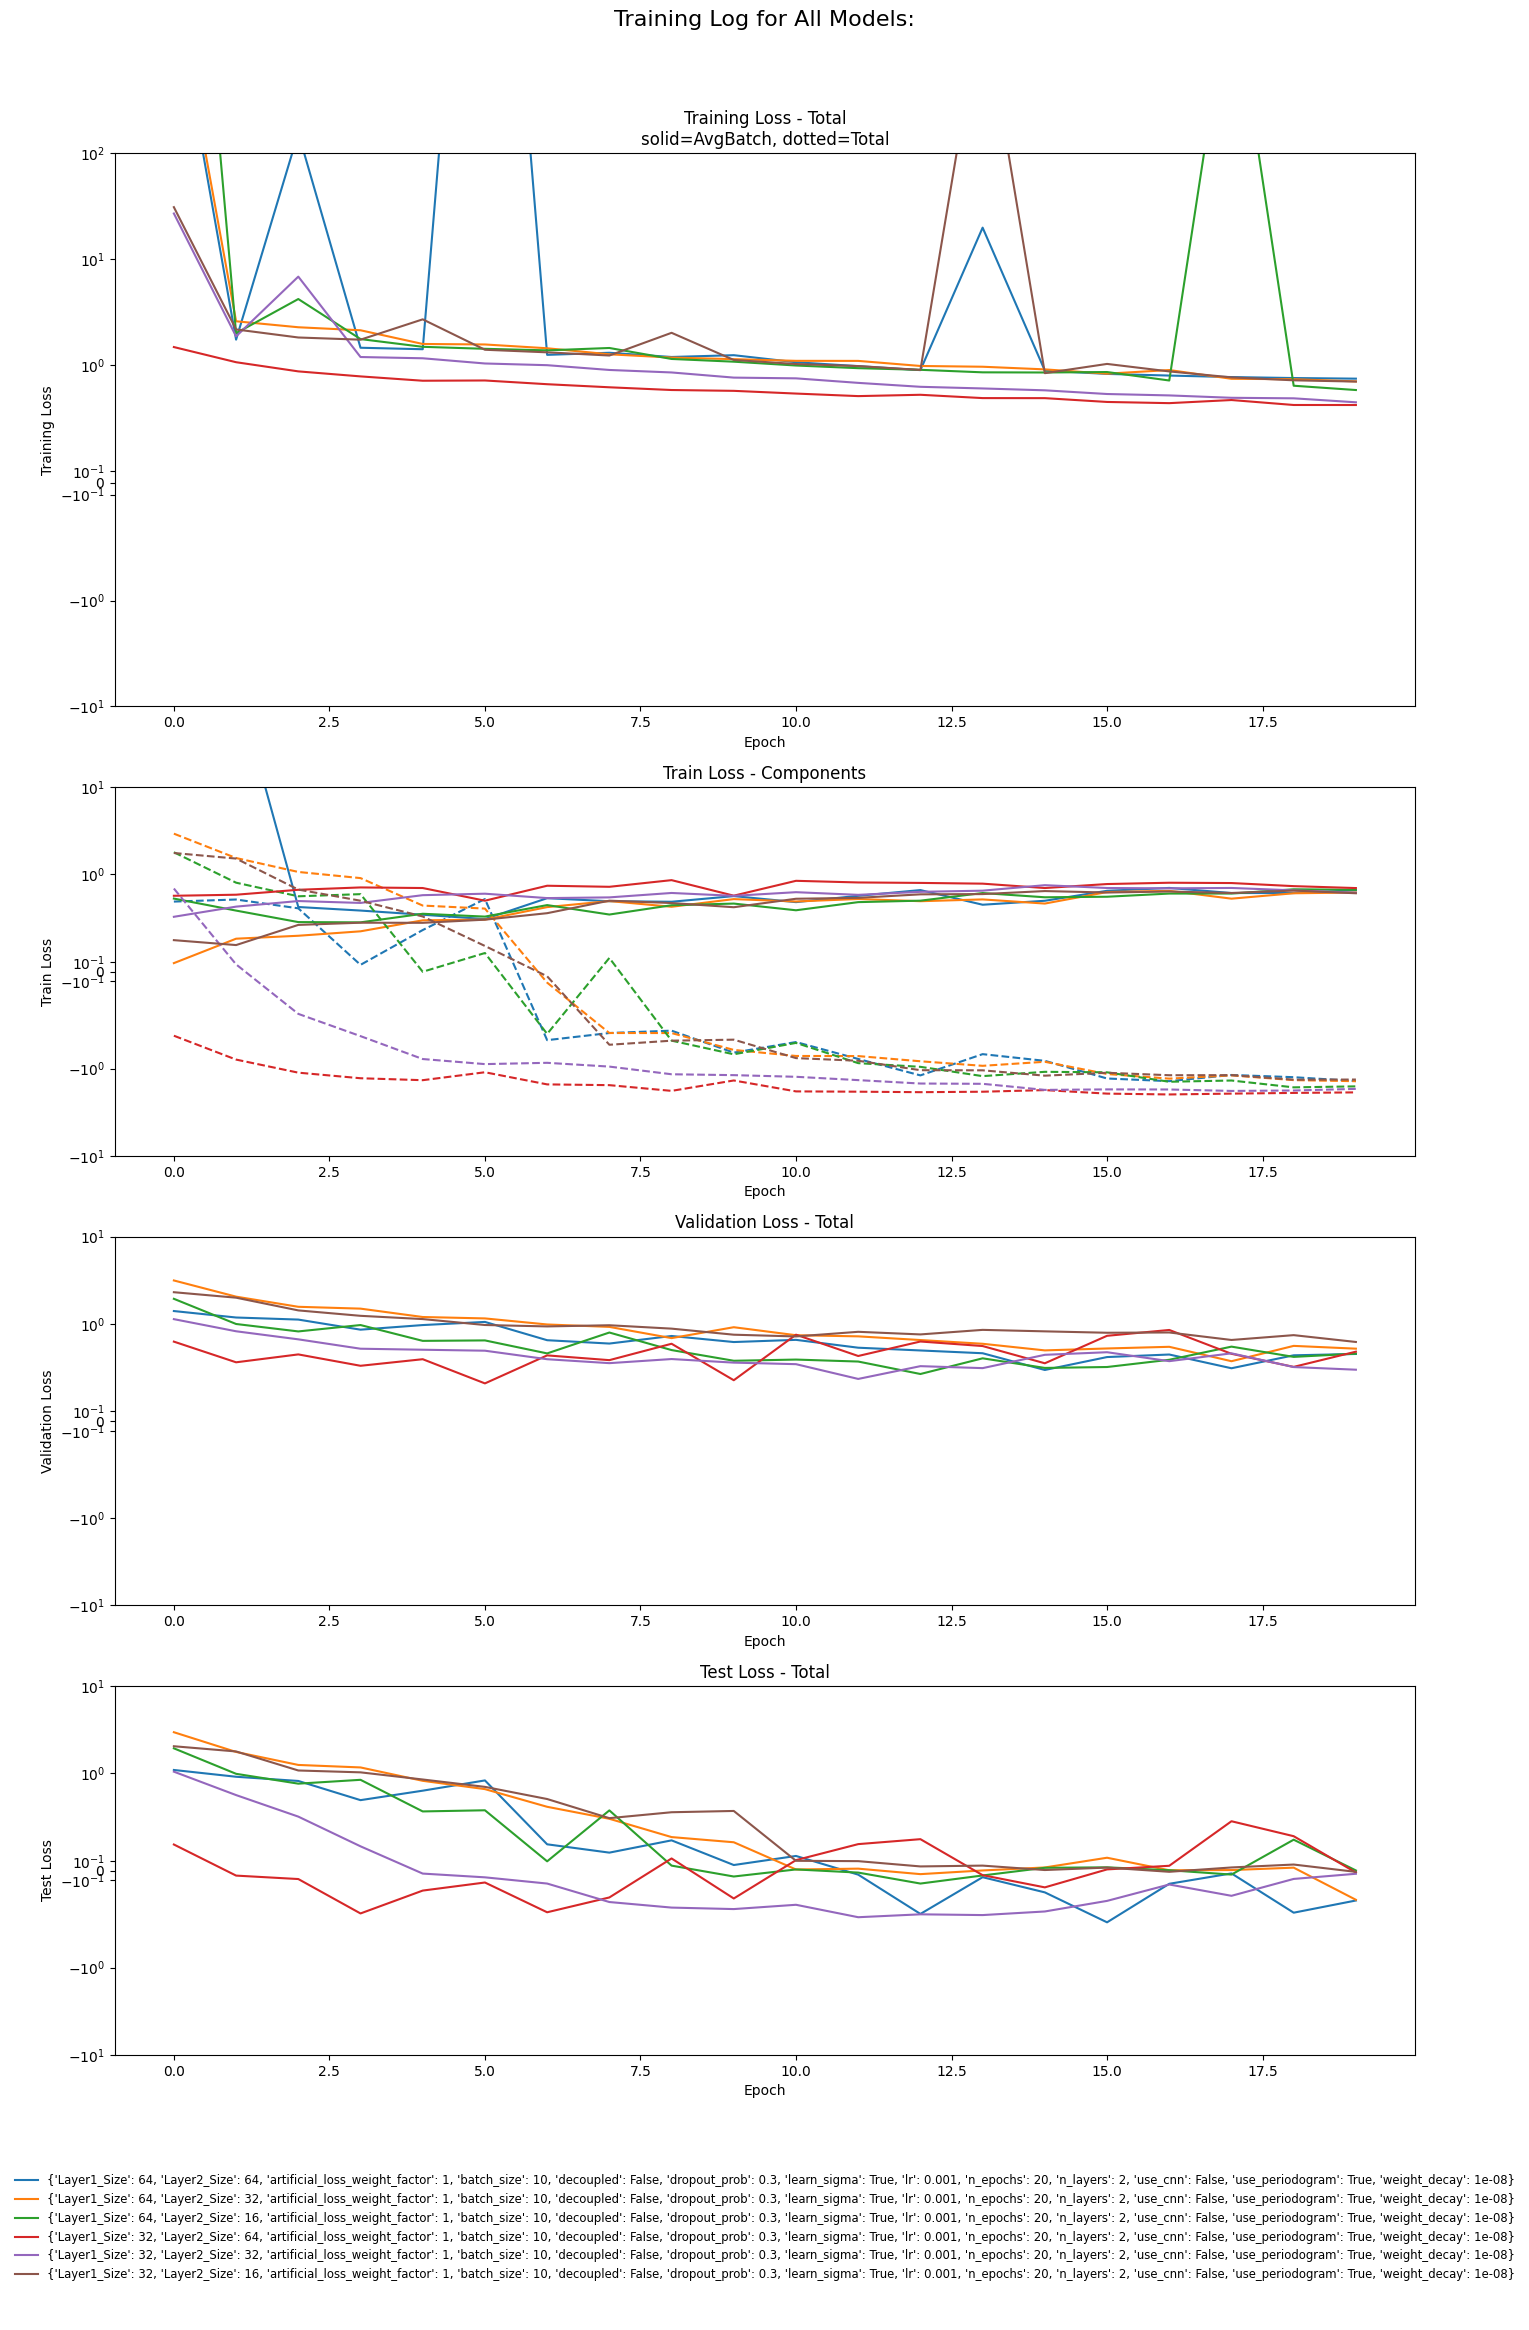

In [369]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from itertools import cycle

def plot_all_model_logs(all_runs_log, all_models_same_plot=False):
    if all_models_same_plot:
        fig = plt.figure(figsize=(16, 25))
        fig.suptitle(f"Training Log for All Models:", fontsize=16)
        gs = gridspec.GridSpec(5, 1, height_ratios=[3, 2, 2, 2, 1])
        ax1 = fig.add_subplot(gs[0])  # Training loss
        ax2 = fig.add_subplot(gs[1])  # Train components
        ax3 = fig.add_subplot(gs[2])  # Valid loss
        ax4 = fig.add_subplot(gs[3])  # Test loss
        ax_legend = fig.add_subplot(gs[4])  # Legend only

    for model_name, runs in all_runs_log.items():
        print(model_name)

        if not all_models_same_plot:
            fig = plt.figure(figsize=(12, 10 + int(1*len(all_runs_log[model_name]))))
            fig.suptitle(f"Training Log for Model: {model_name}", fontsize=16)

            gs = gridspec.GridSpec(5, 1, height_ratios=[3, 2, 2, 2, 1])
            ax1 = fig.add_subplot(gs[0])  # Training loss
            ax2 = fig.add_subplot(gs[1])  # Train components
            ax3 = fig.add_subplot(gs[2])  # Valid loss
            ax4 = fig.add_subplot(gs[3])  # Test loss
            ax_legend = fig.add_subplot(gs[4])  # Legend only

        colors = plt.cm.tab10.colors
        color_cycle = cycle(colors)
        legend_handles = []

        for run_id, run_data in runs.items():
            #print(run_id, run_data)
            log = run_data["log"]
            params = run_data["params"]
            label = str(params)
            color = next(color_cycle)

            # Plot total training loss
            ax1.plot(log["epoch"], log["loss"], label=label, color=color)
            #ax1.plot(log["epoch"], np.asarray(log["train_errLoss"])+np.asarray(log["train_sigmaLoss"]), 
            #         color=color, linestyle='dotted')

            # Plot train components
            #ax2.plot(log["epoch"], log["train_errLoss"]+log["train_sigmaLoss"], color=color, linestyle='solid')
            ax2.plot(log["epoch"], log["train_errLoss"], color=color, linestyle='solid')
            ax2.plot(log["epoch"], np.asarray(log["train_sigmaLoss"]), color=color, linestyle="--")

            # Plot test components (solid = error, dotted = sigma)
            ax3.plot(log["epoch"], np.asarray(log["valid_errLoss"])+np.asarray(log["valid_sigmaLoss"]), color=color, linestyle='solid')
            #ax3.plot(log["epoch"], log["valid_errLoss"], color=color, linestyle="solid")
            #ax3.plot(log["epoch"], log["valid_sigmaLoss"], color=color, linestyle="--" )
            
            
            ax4.plot(log["epoch"], np.asarray(log["test_errLoss"])+np.asarray(log["test_sigmaLoss"]), color=color, linestyle='solid')

            # Collect one legend handle per config
            legend_handles.append(mlines.Line2D([], [], color=color, label=label))

        ax1.set_title("Training Loss - Total\nsolid=AvgBatch, dotted=Total")
        ax1.set_ylabel("Training Loss")
        ax1.set_yscale('symlog', linthresh=0.1, linscale=0.1)
        ax1.set_ylim(-10, 100)
        ax1.set_xlabel("Epoch")

        ax2.set_title("Train Loss - Components")
        ax2.set_ylabel("Train Loss")
        ax2.set_yscale('symlog', linthresh=0.1, linscale=0.1)
        ax2.set_ylim(-10, 10)
        ax2.set_xlabel("Epoch")

        ax3.set_title("Validation Loss - Total")
        ax3.set_ylabel("Validation Loss")
        ax3.set_xlabel("Epoch")
        #ax3.set_yscale('log')
        #ax3.set_ylim(0.01, 100)
        ax3.set_yscale('symlog', linthresh=0.1, linscale=0.1)
        ax3.set_ylim(-10, 10)

        ax4.set_title("Test Loss - Total")
        ax4.set_ylabel("Test Loss")
        ax4.set_xlabel("Epoch")
        #ax4.set_yscale('log')
        #ax4.set_ylim(0.1, 100)
        ax4.set_yscale('symlog', linthresh=0.1, linscale=0.1)
        ax4.set_ylim(-10, 10)

        #ax3.set_yscale('symlog')

        # Turn off axis and show legend in bottom axis
        ax_legend.axis("off")
        ax_legend.legend(handles=legend_handles, loc="center", ncol=1, fontsize='small', frameon=False)

        plt.tight_layout(rect=[0, 0.05, 1, 0.96])
        
        if not all_models_same_plot:
            plt.show()
    plt.show()

plot_all_model_logs(all_runs_log, True)

0
1
2
3
4
5


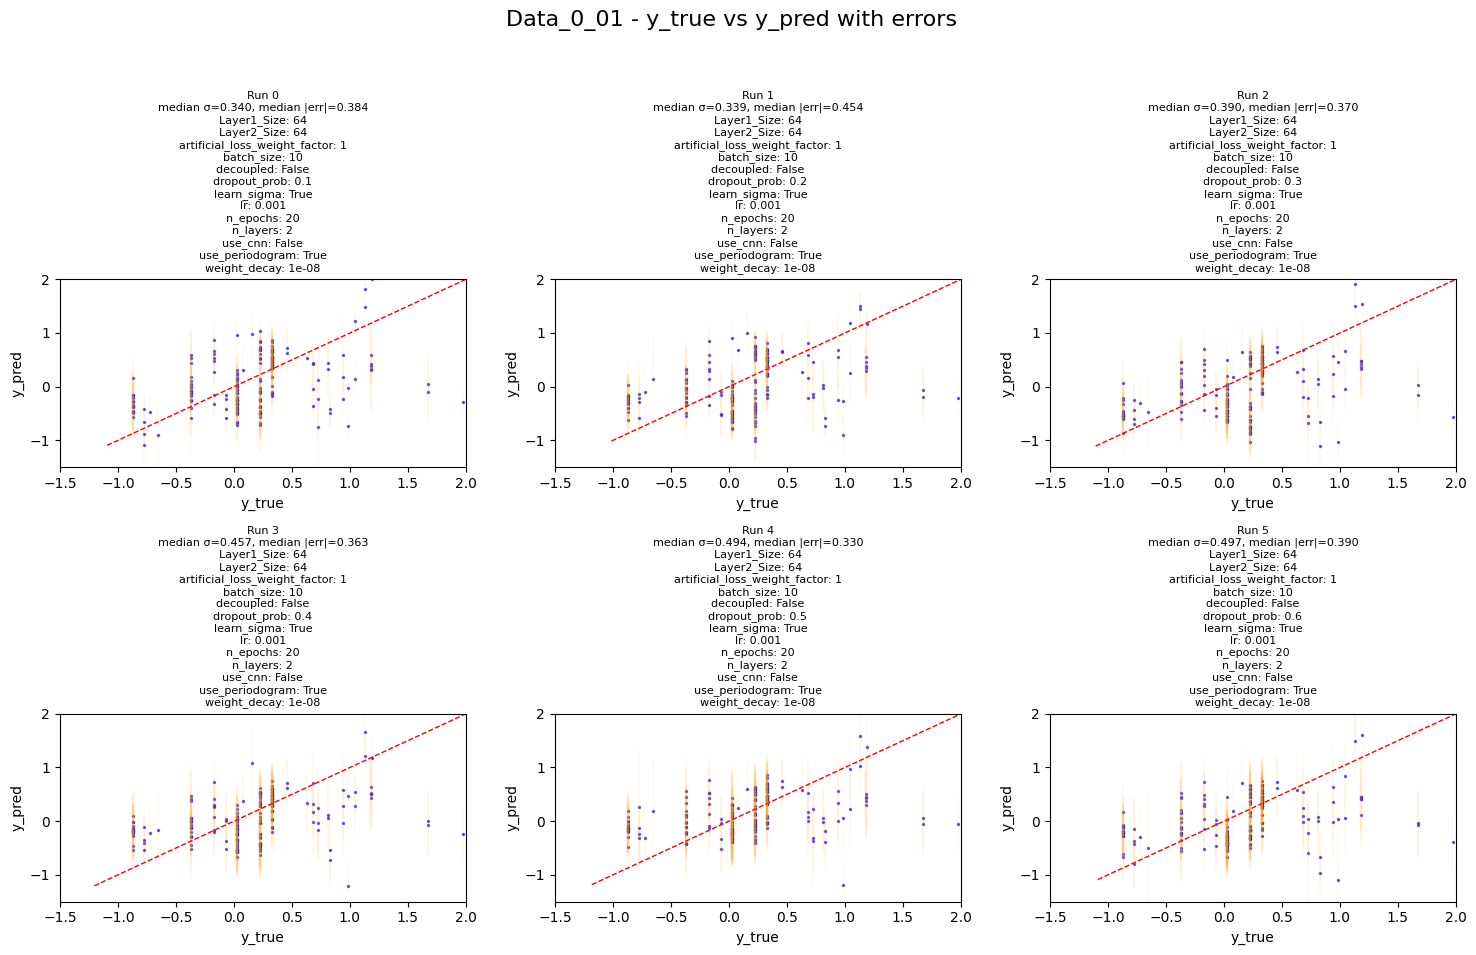

In [349]:
def plot_all_model_runs(all_runs_log, model_names, model_data):
    x_data, period_data, y_data = model_data
    for model_idx, model_name in enumerate(model_names):
        runs = all_runs_log[model_name]
        num_runs = len(runs)
        cols = 3
        rows = int(np.ceil(num_runs / cols))
        
        fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), squeeze=False)
        fig.suptitle(f"{model_name} - y_true vs y_pred with errors", fontsize=16)
        
        # Pull the relevant data for this model
        #X_train, X_test, y_train, y_test, X_test_BDATA, y_test_BDATA, ATTRIBUTES, SCALER = model_data[model_idx]

        X = x_data[model_idx]
        X_period = period_data[model_idx]
        Y = y_data[model_idx].numpy().flatten()
        #X = X_test
        #Y = y_test.numpy().flatten()

        for run_idx, (run_id, run_info) in enumerate(runs.items()):
            print(run_idx)
            row, col = divmod(run_idx, cols)
            ax = axs[row][col]

            model = run_info["model"]
            config = run_info["params"]
            #if (config['lr']==0.0001) and (config['batch_size']==100):
            if (run_idx < 10):
                
                if model is None:
                    ax.set_title(f"{run_id}: (No model)")
                    ax.axis("off")
                    continue
    
                model.eval()
                with torch.no_grad():
                    y_pred, sigma_pred = model(X, X_period)
                    y_pred = y_pred.numpy().flatten()
                    sigma_pred = sigma_pred.numpy().flatten()
    
                # Calculate statistics
                abs_error = np.abs(y_pred - Y)
                median_sigma = np.median(sigma_pred)
                median_abs_error = np.median(abs_error)
    
                ax.scatter(Y, y_pred, s=2, color='blue', alpha=0.6)
                ax.errorbar(Y, y_pred, yerr=sigma_pred, fmt='o', color='orange', alpha=0.05, markersize=2)
    
                min_val = min(Y.min(), y_pred.min())
                max_val = max(Y.max(), y_pred.max())
                ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)  # 1-to-1 line
    
                # Split config dictionary into multiple lines evenly across 3 lines
                config_lines = [f"{key}: {value}" for key, value in config.items()]
                num_config_lines = len(config_lines)
                lines_per_chunk = np.ceil(num_config_lines / 3)  # Number of items per line
                # Split config into chunks and format them into 3 lines
                config_chunks = [config_lines[i:i + int(lines_per_chunk)] for i in range(0, num_config_lines, int(lines_per_chunk))]
                config_text = "\n".join(["\n".join(chunk) for chunk in config_chunks])  # Join the chunks

                ax.set_title(
                    f"Run {run_id}\n"
                    f"median σ={median_sigma:.3f}, median |err|={median_abs_error:.3f}\n"
                    f"{config_text}",
                    fontsize=8
                )
                ax.set_xlabel("y_true")
                ax.set_ylabel("y_pred")
                ax.set_ylim([-1.5, 2])
                ax.set_xlim([-1.5, 2])

    # Hide any unused subplots
    for i in range(num_runs, rows * cols):
        row, col = divmod(i, cols)
        axs[row][col].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

data = (model_valid_data_statistics, model_valid_data_periodogram, model_valid_data_Y)
plot_all_model_runs(all_runs_log, model_names, data)

#data = (model_train_data_statistics, model_train_data_periodogram, model_train_data_Y)
#plot_all_model_runs(all_runs_log, model_names, data)





## Test Data Version
Summary Statistics
🔍 Accuracy Metrics:
   • Mean Absolute Error     : 0.6787
   • Root Mean Square Error  : 1.2394
   • Mean Normalized Error   : 2.0478

📏 Uncertainty Calibration:
   • Coverage (|err| < 1σ)   : 0.4886
   • KS Test (z ~ N(0,1))    : stat=0.2611, p=0.0000
   • Zscores STD (~=1?)      : stat=6.7310
   • Zscores Skewness (~=0?)      : stat=-6.3676
   • Zscores Kurtosis (~=3?)      : stat=44.3338

📉 Probabilistic Performance:
   • Negative Log Likelihood : 23.1423

📊 Predicted Sigma Summary:
   • Median σ                : 0.4833
   • Mean σ                  : 0.5381
Summary Statistics
🔍 Accuracy Metrics:
   • Mean Absolute Error     : 0.6991
   • Root Mean Square Error  : 1.2454
   • Mean Normalized Error   : 6.2546

📏 Uncertainty Calibration:
   • Coverage (|err| < 1σ)   : 0.5434
   • KS Test (z ~ N(0,1))    : stat=0.2856, p=0.0000
   • Zscores STD (~=1?)      : stat=33.6592
   • Zscores Skewness (~=0?)      : stat=-6.4109
   • Zscores Kurtosis (~=

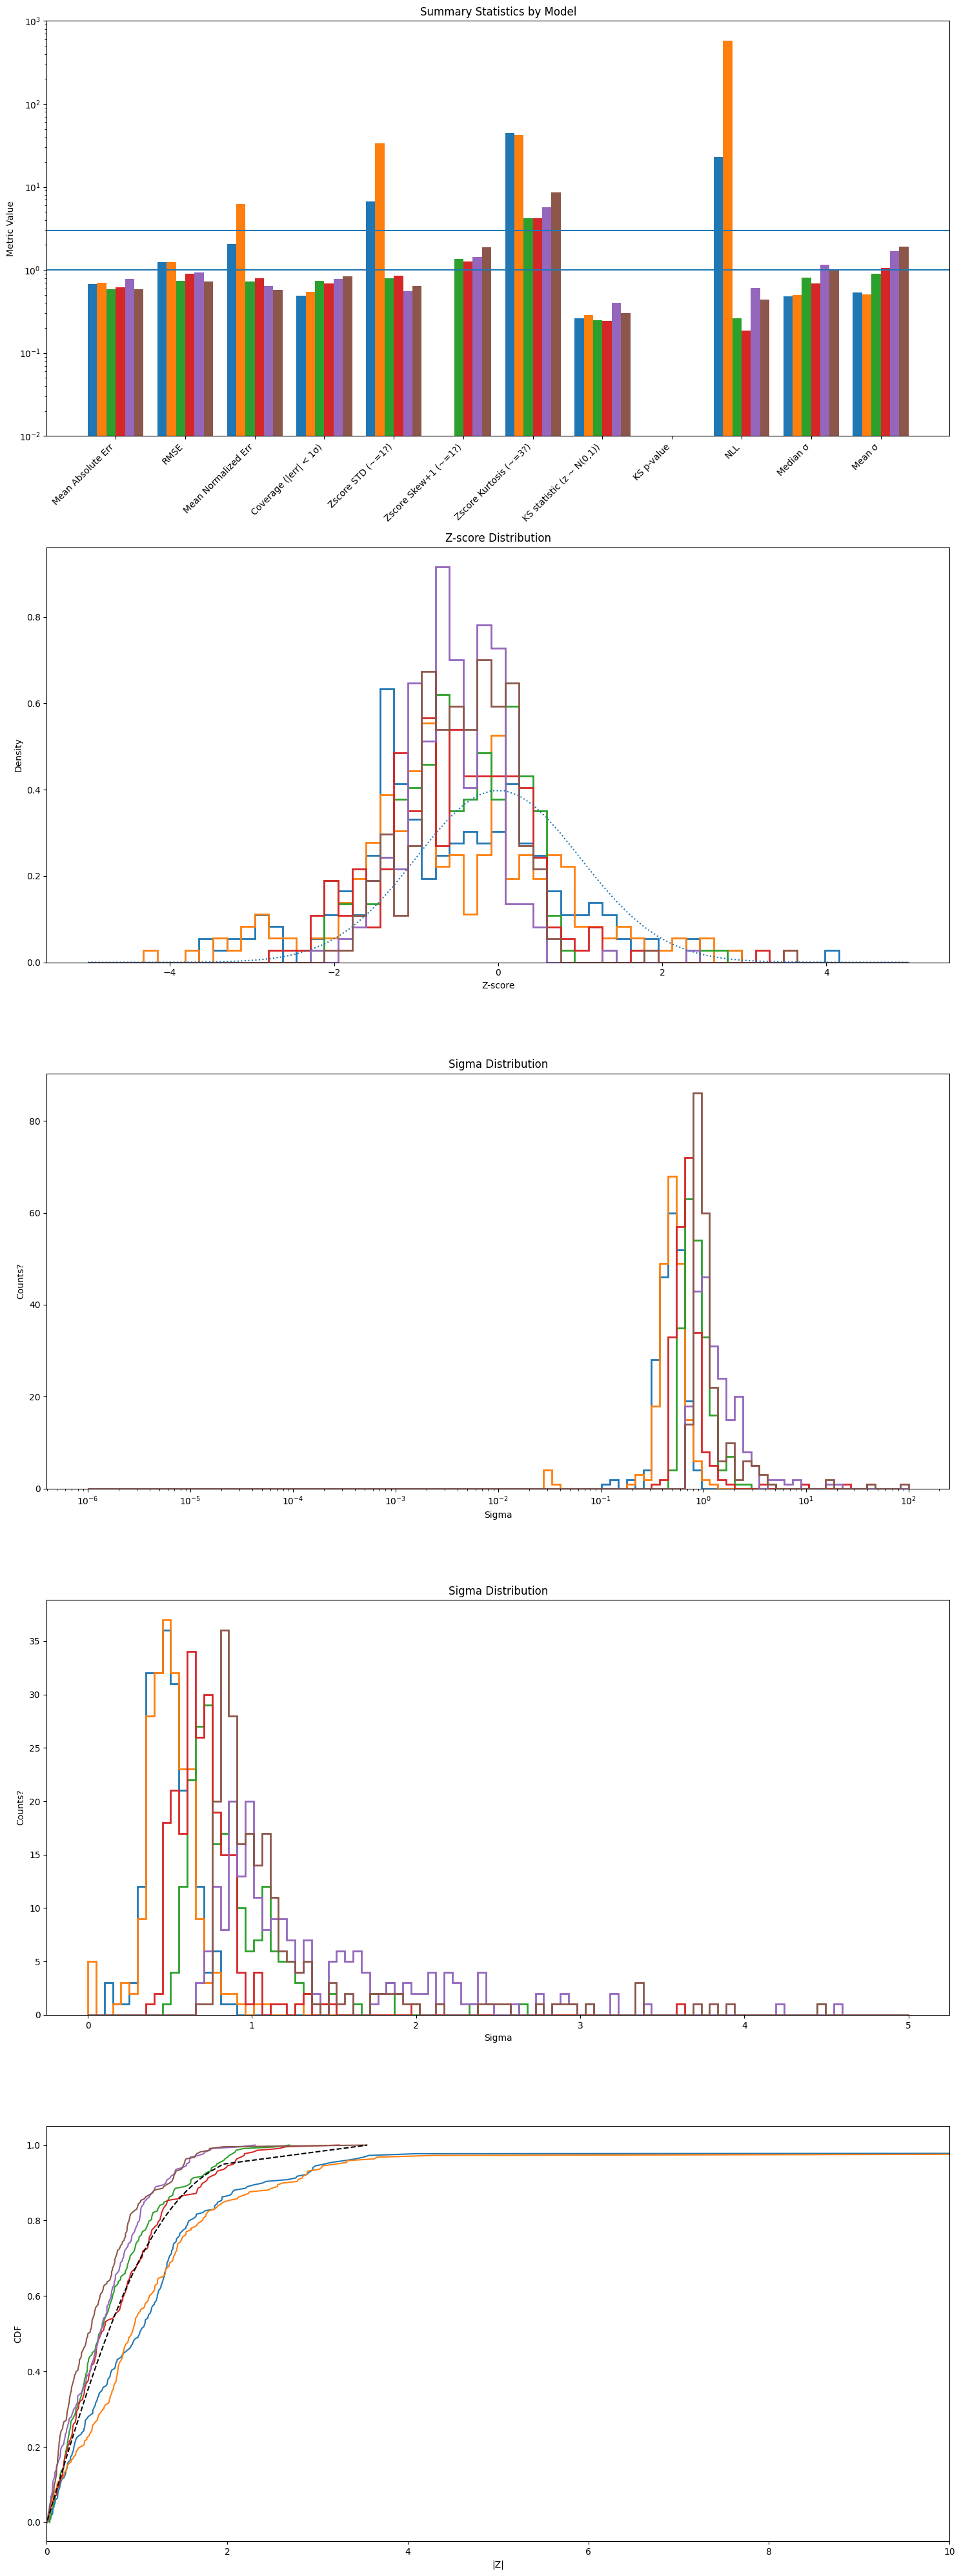

In [357]:
import numpy as np
from scipy.stats import norm, kstest
import scipy

##### TEST METRICS ###

# --- Accuracy Metrics --- These test how close the predictions are to the true values (ignoring σ):

def mae(y_true, y_pred):
    # Mean Absolute Error
    # Robust to Outliers
    
    return torch.mean(torch.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    # Root Mean Squared Error
    # Sensitive to large errors — shows how “bad” outliers are
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

def mean_normalized_error(y_true, y_pred, sigma):
    # This is useful to check if errors are consistent with predicted uncertainties
    return torch.mean(torch.abs((y_true - y_pred) / sigma))

# --- Uncertainty Calibration --- These test whether your predicted σ values are meaningful:
def coverage_probability(y_true, y_pred, sigma, factor=1.0):
    # For a 1σ prediction interval (68.3%), check what fraction of targets fall within:
    # If the model is well-calibrated, ~68% should fall in the band.
    return torch.mean((torch.abs(y_true - y_pred) <= factor * sigma).float())

def z_scores(y_true, y_pred, sigma):
    return (y_true - y_pred) / sigma

def z_score_ks_test(y_true, y_pred, sigma):
    # Computes z-scores and returns the KS test statistic and p-value
    z = z_scores(y_true, y_pred, sigma).cpu().numpy()
    return kstest(z, 'norm')  # returns (D-statistic, p-value)

def skewness(x):
    mean = torch.mean(x)
    std = torch.std(x, unbiased=False)
    return torch.mean(((x - mean) / std) ** 3)

def kurtosis(x):
    mean = torch.mean(x)
    std = torch.std(x, unbiased=False)
    return torch.mean(((x - mean) / std) ** 4)

# --- Probabilistic Score --- These test whether your predicted σ values are meaningful:
def negative_log_likelihood(y_true, y_pred, sigma):
    return torch.mean(0.5 * ((y_true - y_pred) ** 2 / sigma ** 2 + torch.log(sigma ** 2)))

# --- Other ---
def median_sigma2(sigma):
    return torch.median(sigma)

def mean_sigma2(sigma):
    return torch.mean(sigma)

def min_sigma2(sigma):
    return torch.min(sigma)

def to_scalar(x):
    if isinstance(x, torch.Tensor):
        return x.item()
    elif isinstance(x, np.ndarray):
        return x.flatten()[0]  # works even for (1,) or (1,1)
    else:
        return float(x)

def calculate_MCDropout_ZScoreDistribution(model, X, X_period, y_true):
    
    return

def SummaryStats(model, X, X_period, y_true):
    """
    Compute and print summary statistics for model performance.
    
    Inputs:
        model   : PyTorch model that outputs (y_pred, sigma)
        X_test  : input tensor
        y_true  : ground truth tensor
    """
    model.eval() 
    with torch.no_grad():
        y_pred, sigma = model(X, X_period)
    
    # Accuracy metrics
    MAE = mae(y_true, y_pred)
    RMSE = rmse(y_true, y_pred)
    MNE = mean_normalized_error(y_true, y_pred, sigma)

    # Uncertainty calibration
    CovProb = coverage_probability(y_true, y_pred, sigma, factor=1.0)
    Zscores = z_scores(y_true, y_pred, sigma)
    KsStat, KsPval = z_score_ks_test(y_true, y_pred, sigma)
    Zscores_std = np.std(Zscores.cpu().numpy()) #ideally ≈ 1
    Zscores_skew = skewness(Zscores)
    Zscores_kurt = kurtosis(Zscores)

    # Ensure scalars
    CovProb = CovProb.item()
    KsStat = KsStat.item() if isinstance(KsStat, torch.Tensor) else float(KsStat)
    KsPval = KsPval.item() if isinstance(KsPval, torch.Tensor) else float(KsPval)

    # Probabilistic loss
    NLL = negative_log_likelihood(y_true, y_pred, sigma)

    # Sigma stats
    med_sig = median_sigma2(sigma)
    mean_sig = mean_sigma2(sigma)

    print("="*50)
    print("Summary Statistics")
    print("="*50)

    print("🔍 Accuracy Metrics:")
    print(f"   • Mean Absolute Error     : {MAE:.4f}")
    print(f"   • Root Mean Square Error  : {RMSE:.4f}")
    print(f"   • Mean Normalized Error   : {MNE:.4f}")
    print()

    print("📏 Uncertainty Calibration:")
    print(f"   • Coverage (|err| < 1σ)   : {CovProb:.4f}")
    print(f"   • KS Test (z ~ N(0,1))    : stat={KsStat:.4f}, p={KsPval:.4f}")
    print(f"   • Zscores STD (~=1?)      : stat={Zscores_std:.4f}")
    print(f"   • Zscores Skewness (~=0?)      : stat={Zscores_skew:.4f}")
    print(f"   • Zscores Kurtosis (~=3?)      : stat={Zscores_kurt:.4f}")
    print()
    
    print("📉 Probabilistic Performance:")
    print(f"   • Negative Log Likelihood : {NLL:.4f}")
    print()

    print("📊 Predicted Sigma Summary:")
    print(f"   • Median σ                : {med_sig:.4f}")
    print(f"   • Mean σ                  : {mean_sig:.4f}")
    print("="*50)

    return {
        'MAE': to_scalar(MAE),
        'RMSE': to_scalar(RMSE),
        'MNE': to_scalar(MNE),
        'Coverage': to_scalar(CovProb),
        'Zscore_Std': to_scalar(Zscores_std),
        'Zscore_Skew': to_scalar(Zscores_skew),
        'Zscore_Kurt': to_scalar(Zscores_kurt),
        'KS_stat': to_scalar(KsStat),
        'KS_pval': to_scalar(KsPval),
        'NLL': to_scalar(NLL),
        'Median_sigma': to_scalar(med_sig),
        'Mean_sigma': to_scalar(mean_sig),
        'Zscores': Zscores.cpu().numpy(),
        'Sigmas': sigma.cpu().numpy()

    }
    # ADD IN KURTOSIS!
    

def PlotSummaryStats(results_list, model_names, figsize=(15, 40)):
    names = np.array(model_names)
    n_models = len(model_names)

    # Extract metrics
    MAEs = np.array([res['MAE'] for res in results_list])
    RMSEs = np.array([res['RMSE'] for res in results_list])
    MNEs = np.array([res['MNE'] for res in results_list])
    Coverage = np.array([res['Coverage'] for res in results_list])
    Zscore_Std = np.array([res['Zscore_Std'] for res in results_list])
    Zscore_Skew = np.array([res['Zscore_Skew'] for res in results_list])
    Zscore_Kurt = np.array([res['Zscore_Kurt'] for res in results_list])
    KS_stat = np.array([res['KS_stat'] for res in results_list])
    KS_pvals = np.array([res['KS_pval'] for res in results_list])
    NLLs = np.array([res['NLL'] for res in results_list])
    MedSig = np.array([res['Median_sigma'] for res in results_list])
    MeanSig = np.array([res['Mean_sigma'] for res in results_list])
    ZscoreSets = [res.get('Zscores', None) for res in results_list]
    SigmasSets = [res.get('Sigmas', None) for res in results_list]

    # All metrics
    metrics = {
        "Mean Absolute Err": MAEs,
        "RMSE": RMSEs,
        "Mean Normalized Err": MNEs,
        "Coverage (|err| < 1σ)": Coverage,
        "Zscore STD (~=1?)": Zscore_Std,
        "Zscore Skew+1 (~=1?)": Zscore_Skew+1,
        "Zscore Kurtosis (~=3?)": Zscore_Kurt,
        "KS statistic (z ~ N(0,1))": KS_stat,
        "KS p-value": KS_pvals,
        "NLL": NLLs,
        "Median σ": MedSig,
        "Mean σ": MeanSig
    }

    metric_names = list(metrics.keys())
    num_metrics = len(metric_names)

    # Plotting
    fig, (ax_bars, ax_hist_z, ax_hist_sigma, ax_hist_sigma2, ax_hist_zCDF) = plt.subplots(5, 1, figsize=figsize, gridspec_kw={'height_ratios': [1, 1, 1, 1, 1]})

    x = np.arange(num_metrics)
    width = 0.8 / n_models  # total group width = 0.8

    colors = plt.cm.tab10.colors  # Up to 10 unique colors
    for i, model_name in enumerate(model_names):
        vals = [metrics[m][i] for m in metric_names]
        ax_bars.bar(x + i * width, vals, width=width, label=model_name, color=colors[i % len(colors)])

    ax_bars.set_xticks(x + width * (n_models - 1) / 2)
    ax_bars.set_xticklabels(metric_names, rotation=45, ha='right')
    ax_bars.set_title("Summary Statistics by Model")
    ax_bars.set_ylabel("Metric Value")
    #ax_bars.legend(title="Models")
    ax_bars.set_yscale('log')
    ax_bars.set_ylim(1e-2, 1e3)
    ax_bars.axhline(1)
    ax_bars.axhline(3)

    # Histogram of z-scores
    bins = np.linspace(-5, 5, 60)
    for i, z in enumerate(ZscoreSets):
        if z is not None:
            ax_hist_z.hist(z, bins=bins, histtype='step', alpha=1, lw=2, label=model_names[i], density=True, color=colors[i % len(colors)])

    ax_hist_z.set_title("Z-score Distribution")
    ax_hist_z.set_xlabel("Z-score")
    ax_hist_z.set_ylabel("Density")
    rv = scipy.stats.norm(loc=0, scale=1)
    ax_hist_z.plot(bins, rv.pdf(bins), ls='dotted')
    #ax_hist_z.legend()

    # Histogram of Sigmas
    #bins1 = np.linspace(0.1, 5, 30)
    #bins2 = np.logspace(-6, -1, 30)
    #bins = np.concatenate((bins2[bins2 < bins1[0]], bins1))
    bins = np.logspace(-6, 2, 100)

    for i, sigma in enumerate(SigmasSets):
        if sigma is not None:
            ax_hist_sigma.hist(sigma, bins=bins, histtype='step', alpha=1, lw=2, label=names[i], density=False)
    ax_hist_sigma.set_title("Sigma Distribution")
    ax_hist_sigma.set_xlabel("Sigma")
    ax_hist_sigma.set_ylabel("Counts?")
    ax_hist_sigma.set_xscale('log')
    #ax_hist_sigma.legend()

    
    bins = np.linspace(0, 5, 100)
    for i, sigma in enumerate(SigmasSets):
        if sigma is not None:
            ax_hist_sigma2.hist(sigma, bins=bins, histtype='step', alpha=1, lw=2, label=names[i], density=False)
    ax_hist_sigma2.set_title("Sigma Distribution")
    ax_hist_sigma2.set_xlabel("Sigma")
    ax_hist_sigma2.set_ylabel("Counts?")
    #ax_hist_sigma2.set_xscale('log')
    #ax_hist_sigma2.legend()

    
    for i, z in enumerate(ZscoreSets):
        abs_z = np.abs(z)
        sorted_abs_z = np.sort(abs_z.flatten())
        print(sorted_abs_z)
        #theoretical_cdf = norm.cdf(sorted_abs_z)
        theoretical_cdf = 2 * norm.cdf(sorted_abs_z) - 1

        ax_hist_zCDF.plot(sorted_abs_z, np.linspace(0, 1, len(sorted_abs_z)), label='Empirical CDF')
    ax_hist_zCDF.plot(sorted_abs_z, theoretical_cdf, label='Theoretical N(0,1) CDF', ls='dashed', c='black')
    #ax_hist_zCDF.legend()
    ax_hist_zCDF.set_xlabel("|Z|")
    ax_hist_zCDF.set_ylabel("CDF")
    ax_hist_zCDF.set_xlim([0, 10])


    #ax_hist_zCDF.title("Empirical vs Theoretical CDF of |Z|")


    plt.tight_layout()
    #smart_savefig('/expanse/lustre/projects/was215/cwillard/Figs/PerformancePlots_FeatureModels/FeatureComparison.png', dpi=100, bbox_inches='tight')
    plt.show()

# testing_data = (X_test, period_test, y_test)
# model_train_data_statistics = [X_train]
# model_train_data_periodogram = [period_train]
# model_train_data_Y = [y_train]
# model_valid_data_statistics = [X_valid]
# model_valid_data_periodogram = [period_valid]
# model_valid_data_Y = [y_valid]
# model_test_data_statistics = [X_test]
# model_test_data_periodogram = [period_test]
# model_test_data_Y = [y_test]


print('\n\n\n## Test Data Version')
SumStats_list = []    
flattened_name_list = []
for i, model_name in enumerate(model_names):
    X, X_period, Y = model_test_data_statistics[i], model_test_data_periodogram[i], model_test_data_Y[i] 
    #X, X_period, Y = model_valid_data_statistics[i], model_valid_data_periodogram[i], model_valid_data_Y[i] 
    
    for run_id, config_dict in enumerate(ParameterGrid(params)):
        #if (config_dict['batch_size']==1000) and (config_dict['lr']<1e-3):
        model = all_runs_log[model_name][run_id]['model']
        flattened_name_list.append(str(config_dict))
        SumStats_list.append(SummaryStats(model, X, X_period, Y))
        
PlotSummaryStats(SumStats_list, flattened_name_list)





## MCMC Dropout


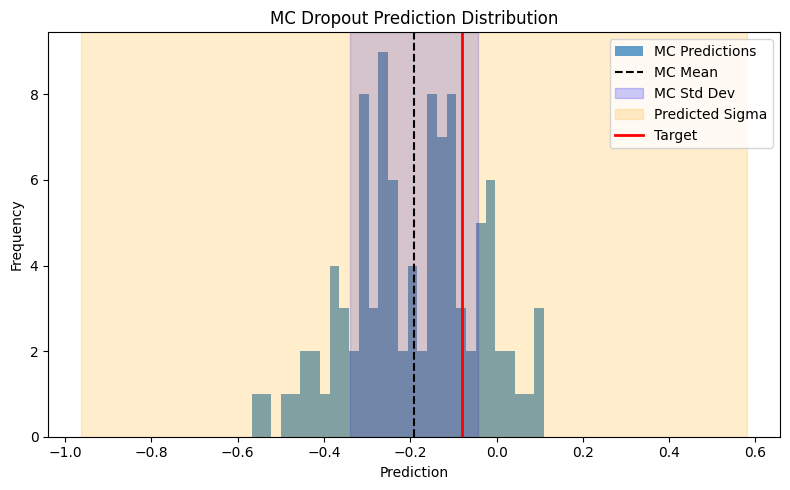

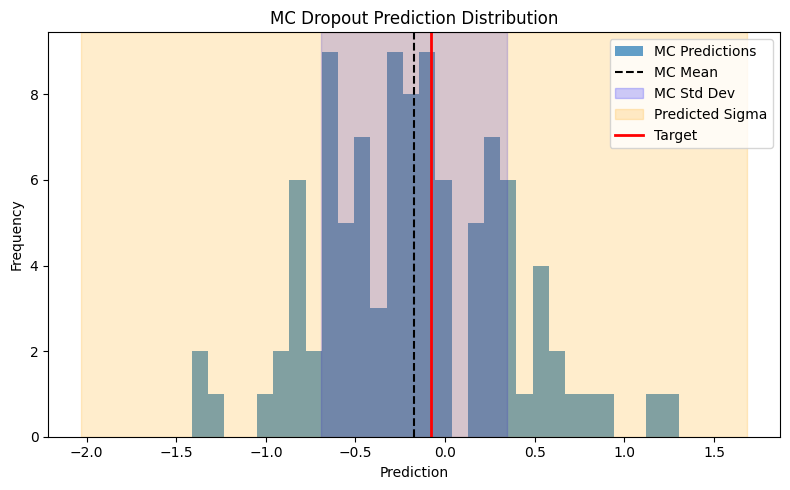

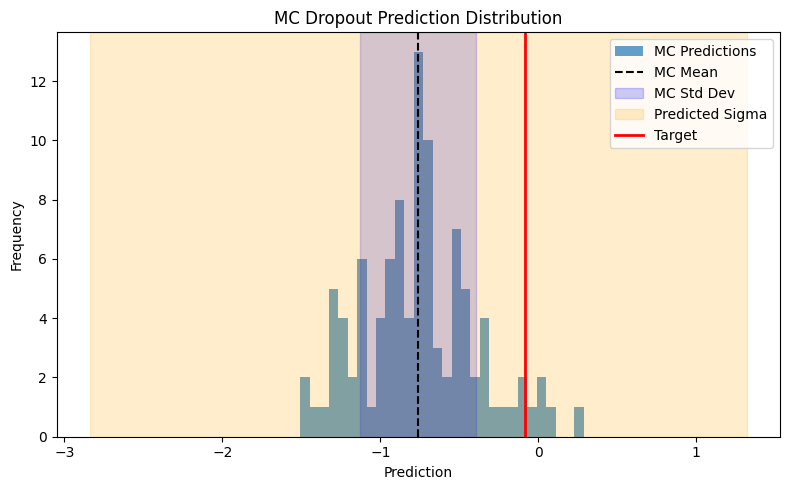

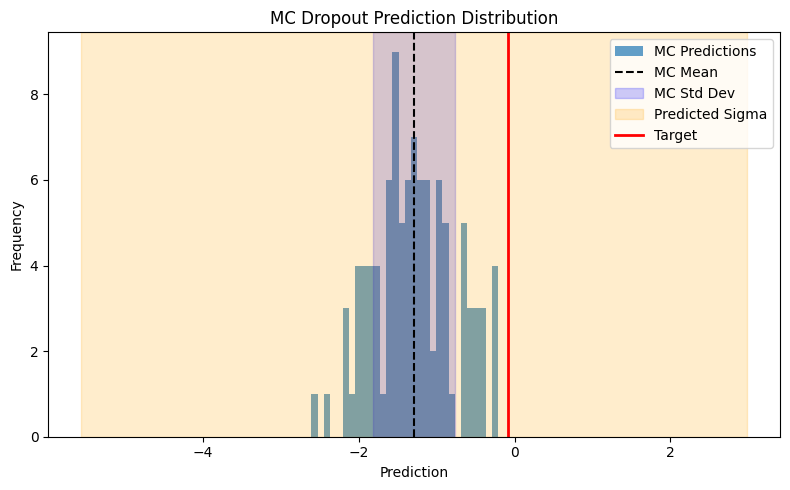

In [47]:
# TRY MCMC DROPOUT
import torch
import matplotlib.pyplot as plt

def enable_dropout(model):
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.train()
    enable_dropout(model)

def disable_dropout(model):
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.eval()

def visualize_mc_dropout(model, X, X_period, num_samples=100, target=None):
    """
    Runs MC dropout and visualizes prediction distribution and uncertainties.
    
    Assumes the model returns two tensors per input:
    - mean prediction: shape (batch_size, ...)
    - predicted std/uncertainty: shape (batch_size, ...)
    
    Arguments:
    - model: a PyTorch model
    - input_tensor: shape (batch_size, input_dim)
    - num_samples: number of MC dropout samples
    - target: optional ground-truth tensor for comparison
    """
    model.eval()
    enable_dropout(model)
    
    pred_list = []
    sigma_list = []

    with torch.no_grad():
        for _ in range(num_samples):
            pred, sigma = model( X, X_period)
            pred_list.append(pred.unsqueeze(0))    # [1, batch_size, ...]
            sigma_list.append(sigma.unsqueeze(0))  # [1, batch_size, ...]

    preds = torch.cat(pred_list, dim=0)   # [num_samples, batch_size, ...]
    sigmas = torch.cat(sigma_list, dim=0) # [num_samples, batch_size, ...]

    mean_pred = preds.mean(dim=0)
    std_pred = preds.std(dim=0)
    mean_sigma = sigmas.mean(dim=0)

    # Plot for batch_size = 1 (or pick one example if batched)
    idx = 0
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.hist(preds[:, idx].cpu().numpy(), bins=30, alpha=0.7, label="MC Predictions")
    ax.axvline(mean_pred[idx].item(), color='k', linestyle='--', label='MC Mean')
    ax.axvspan(mean_pred[idx].item() - std_pred[idx].item(),
               mean_pred[idx].item() + std_pred[idx].item(),
               color='blue', alpha=0.2, label='MC Std Dev')
    
    ax.axvspan(mean_pred[idx].item() - mean_sigma[idx].item(),
               mean_pred[idx].item() + mean_sigma[idx].item(),
               color='orange', alpha=0.2, label='Predicted Sigma')

    if target is not None:
        ax.axvline(target[idx].item(), color='red', label='Target', linewidth=2)

    ax.set_title("MC Dropout Prediction Distribution")
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Frequency")
    ax.legend()
    plt.tight_layout()
    plt.show()


    # Disable dropouts:
    model.eval()
    return



print('\n\n\n## MCMC Dropout')
SumStats_list = []    
flattened_name_list = []
for i, model_name in enumerate(model_names):
    X, X_period, Y = model_test_data_statistics[i], model_test_data_periodogram[i], model_test_data_Y[i] 
    #X, X_period, Y = model_valid_data_statistics[i], model_valid_data_periodogram[i], model_valid_data_Y[i] 
    
    for run_id, config_dict in enumerate(ParameterGrid(params)):
        #if (config_dict['batch_size']==1000) and (config_dict['lr']<1e-3):
        model = all_runs_log[model_name][run_id]['model']
        #flattened_name_list.append(str(config_dict))
        #SumStats_list.append(SummaryStats(model,  X_test, y_test))
        visualize_mc_dropout(model, X, X_period, num_samples=100, target=Y)






## MCMC Dropout
{'Layer1_Size': 64, 'Layer2_Size': 64, 'artificial_loss_weight_factor': 1, 'batch_size': 10, 'decoupled': False, 'dropout_prob': 0.1, 'learn_sigma': True, 'lr': 0.001, 'n_epochs': 5, 'n_layers': 2, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-08}
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'torch.Tensor'>
(190,) (190,) (190,) torch.Size([190]) torch.Size([190, 1])
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(190,) (190,) (190,) torch.Size([190]) (190,)


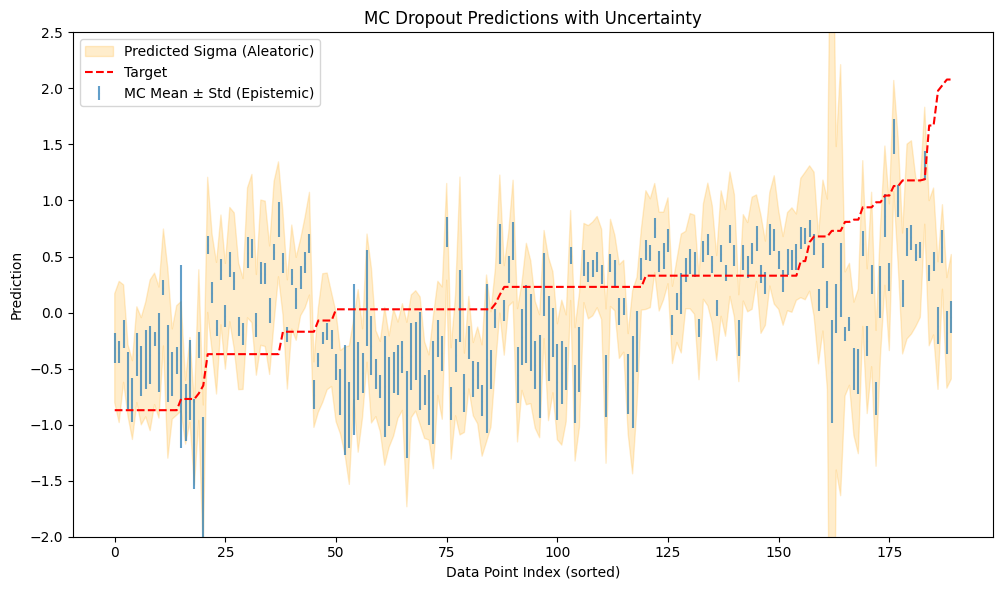

{'Layer1_Size': 64, 'Layer2_Size': 64, 'artificial_loss_weight_factor': 1, 'batch_size': 10, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': True, 'lr': 0.001, 'n_epochs': 5, 'n_layers': 2, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-08}
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'torch.Tensor'>
(190,) (190,) (190,) torch.Size([190]) torch.Size([190, 1])
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(190,) (190,) (190,) torch.Size([190]) (190,)


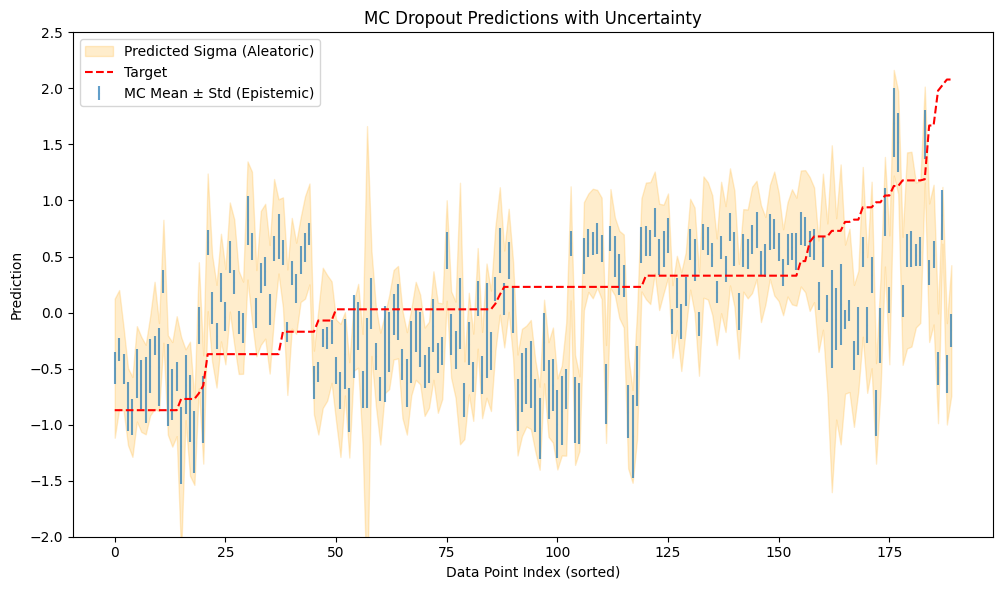

{'Layer1_Size': 64, 'Layer2_Size': 64, 'artificial_loss_weight_factor': 1, 'batch_size': 10, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.001, 'n_epochs': 5, 'n_layers': 2, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-08}
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'torch.Tensor'>
(190,) (190,) (190,) torch.Size([190]) torch.Size([190, 1])
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(190,) (190,) (190,) torch.Size([190]) (190,)


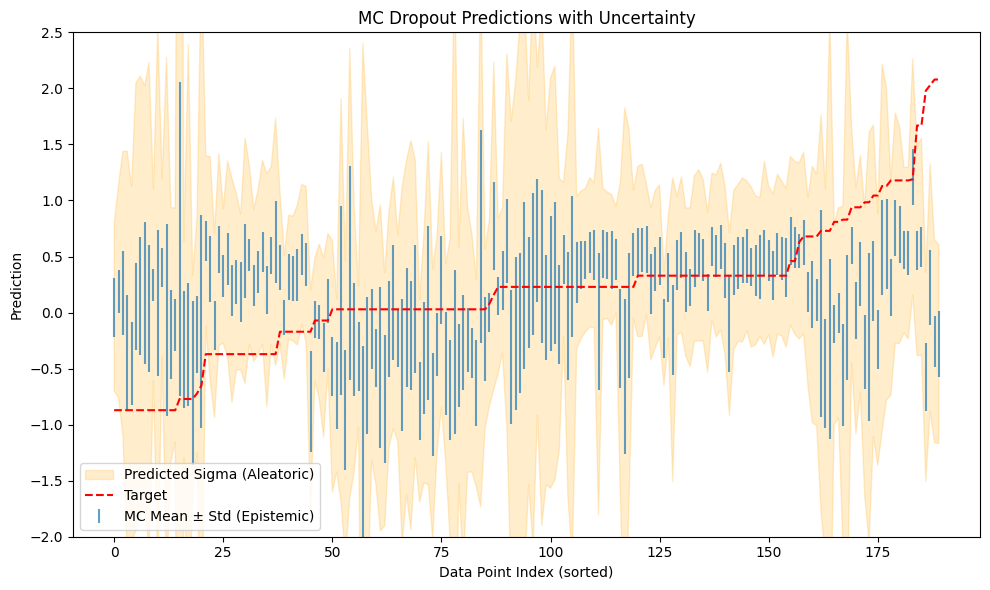

{'Layer1_Size': 64, 'Layer2_Size': 64, 'artificial_loss_weight_factor': 1, 'batch_size': 10, 'decoupled': False, 'dropout_prob': 0.4, 'learn_sigma': True, 'lr': 0.001, 'n_epochs': 5, 'n_layers': 2, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-08}
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'torch.Tensor'>
(190,) (190,) (190,) torch.Size([190]) torch.Size([190, 1])
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(190,) (190,) (190,) torch.Size([190]) (190,)


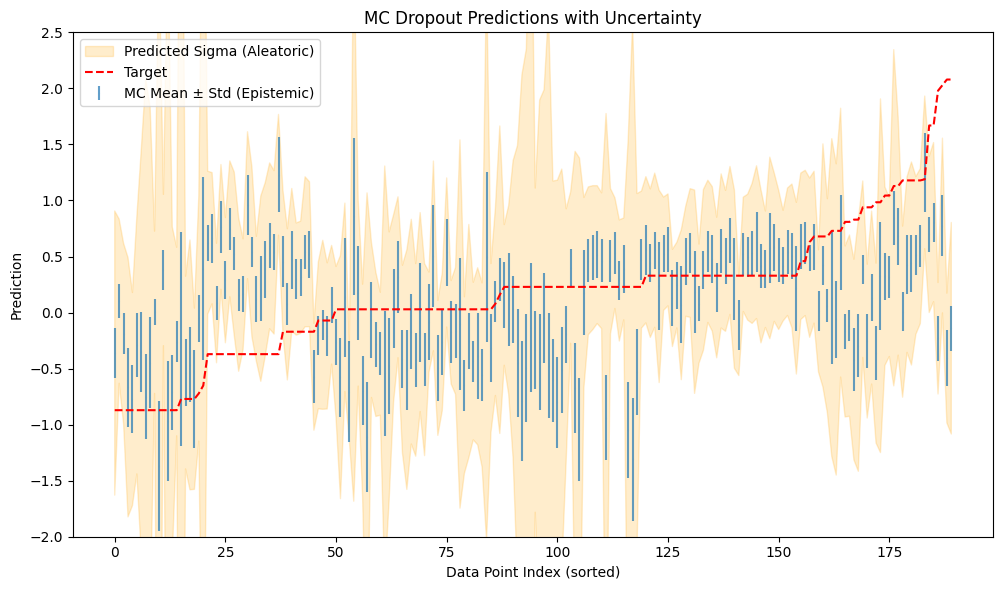

{'Layer1_Size': 64, 'Layer2_Size': 64, 'artificial_loss_weight_factor': 1, 'batch_size': 10, 'decoupled': False, 'dropout_prob': 0.5, 'learn_sigma': True, 'lr': 0.001, 'n_epochs': 5, 'n_layers': 2, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-08}
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'torch.Tensor'>
(190,) (190,) (190,) torch.Size([190]) torch.Size([190, 1])
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(190,) (190,) (190,) torch.Size([190]) (190,)


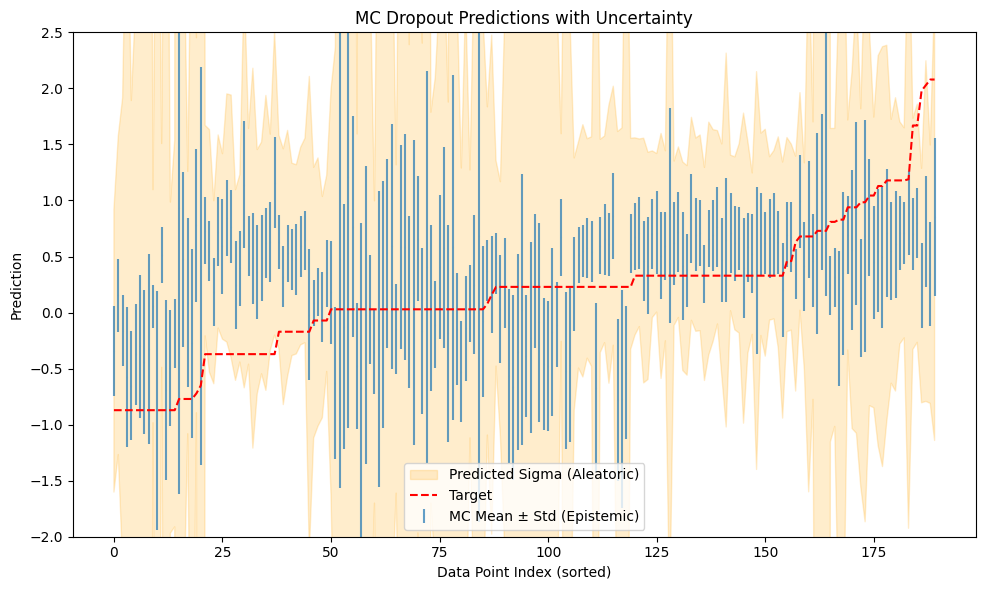

{'Layer1_Size': 64, 'Layer2_Size': 64, 'artificial_loss_weight_factor': 1, 'batch_size': 10, 'decoupled': False, 'dropout_prob': 0.6, 'learn_sigma': True, 'lr': 0.001, 'n_epochs': 5, 'n_layers': 2, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-08}
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'torch.Tensor'>
(190,) (190,) (190,) torch.Size([190]) torch.Size([190, 1])
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(190,) (190,) (190,) torch.Size([190]) (190,)


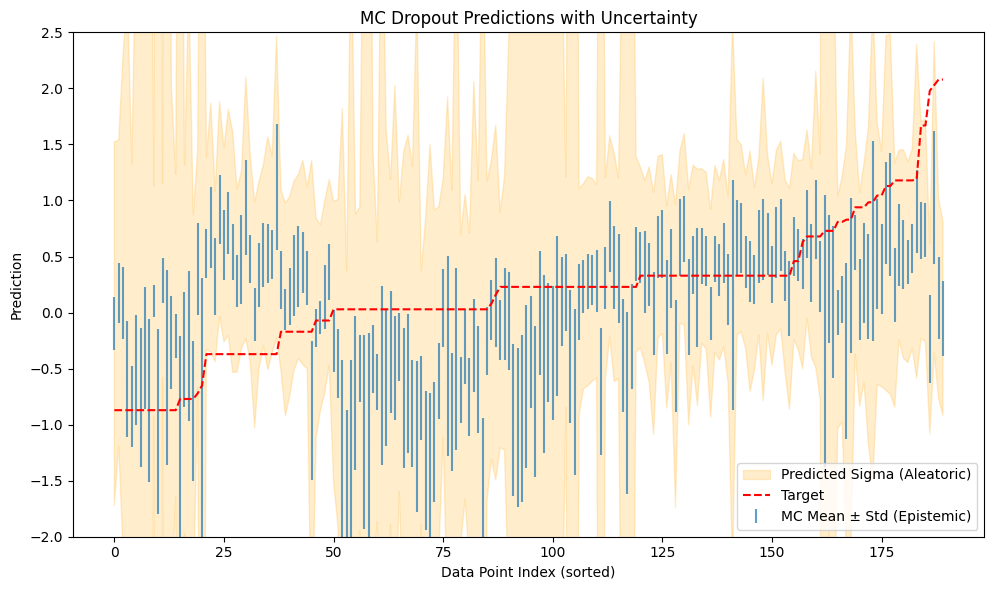

In [358]:
import torch
import matplotlib.pyplot as plt

def visualize_mc_dropout_batch(model, X, X_period, num_samples=1000, targets=None, sort_x=False):
    """
    Run MC Dropout on a batch of inputs and visualize prediction mean + uncertainty.
    
    Assumes model returns (prediction, predicted_sigma).
    
    Parameters:
    - model: PyTorch model
    - input_tensor: Tensor of shape [batch_size, input_dim]
    - num_samples: number of stochastic forward passes
    - targets: optional tensor of shape [batch_size]
    - sort_x: if True, will sort x-axis by mean prediction
    """
    model.eval()
    enable_dropout(model)

    pred_list = []
    sigma_list = []

    with torch.no_grad():
        for _ in range(num_samples):
            pred, sigma = model(X, X_period)
            pred_list.append(pred.unsqueeze(0))    # [1, batch_size]
            sigma_list.append(sigma.unsqueeze(0))  # [1, batch_size]

    preds = torch.cat(pred_list, dim=0)   # [num_samples, batch_size]
    sigmas = torch.cat(sigma_list, dim=0) # [num_samples, batch_size]

    mean_pred = preds.mean(dim=0).squeeze(-1).cpu().numpy() # Mean all the predictions (for each point)
    std_pred = preds.std(dim=0).squeeze(-1).cpu().numpy()   # Std of all the predicitons (for each point)
    mean_sigma = sigmas.mean(dim=0).squeeze(-1).cpu().numpy() # Avg model uncertainty from each prediction (for each point)

    x = torch.arange(len(mean_pred))  # default x-axis = index

    if sort_x and (targets is not None):
        print(type(mean_pred), type(std_pred), type(mean_sigma), type(x), type(targets))
        print(np.shape(mean_pred), np.shape(std_pred), np.shape(mean_sigma), np.shape(x), np.shape(targets))

        targets = targets.squeeze(-1).cpu().numpy()
        sort_idx = targets.argsort()
        targets = targets[sort_idx]

        mean_pred = mean_pred[sort_idx]
        std_pred = std_pred[sort_idx]
        mean_sigma = mean_sigma[sort_idx]
        # x = x.squeeze(-1).cpu().numpy()
        # print(x)
        # #x = x[sort_idx]
    
        #if targets is not None:
        print(type(mean_pred), type(std_pred), type(mean_sigma), type(x), type(targets))
        print(np.shape(mean_pred), np.shape(std_pred), np.shape(mean_sigma), np.shape(x), np.shape(targets))

    # Plot
    plt.figure(figsize=(10, 6))
    plt.errorbar(x, mean_pred, yerr=std_pred, fmt='o', label='MC Mean ± Std (Epistemic)', alpha=0.7, ms=0.01)

    # Optional predicted uncertainty
    plt.fill_between(x, mean_pred - mean_sigma, mean_pred + mean_sigma, 
                     color='orange', alpha=0.2, label='Predicted Sigma (Aleatoric)')

    if targets is not None:
        plt.plot(x, targets, 'r--', label='Target')

    plt.xlabel("Data Point Index" + (" (sorted)" if sort_x else ""))
    plt.ylabel("Prediction")
    plt.title("MC Dropout Predictions with Uncertainty")
    plt.legend()
    plt.tight_layout()
    plt.ylim(-2, 2.5)
    plt.show()

    # Disable dropouts:
    model.eval()
    return




print('\n\n\n## MCMC Dropout')
SumStats_list = []    
flattened_name_list = []
for i, model_name in enumerate(model_names):
    #X, X_period, Y = model_train_data_statistics[i], model_train_data_periodogram[i], model_train_data_Y[i] 
    #X, X_period, Y = model_test_data_statistics[i], model_test_data_periodogram[i], model_test_data_Y[i] 
    X, X_period, Y = model_valid_data_statistics[i], model_valid_data_periodogram[i], model_valid_data_Y[i] 
    
    for run_id, config_dict in enumerate(ParameterGrid(params)):
        print(config_dict)
        #if (config_dict['batch_size']==1000) and (config_dict['lr']<1e-3):
        model = all_runs_log[model_name][run_id]['model']
        #flattened_name_list.append(str(config_dict))
        #SumStats_list.append(SummaryStats(model,  X_test, y_test))
        
        visualize_mc_dropout_batch(model, X, X_period, num_samples=100, targets=Y, sort_x=True)



tensor([[-1.0488, -0.5157, -0.5272,  ..., -1.0108, -0.7249,  0.1136],
        [-1.0468, -0.5296, -0.5413,  ..., -0.9873, -0.5846,  0.1202],
        [-1.0475, -0.5022, -0.5154,  ..., -0.9891, -0.6021,  0.1362],
        ...,
        [ 1.3387, -0.8881, -0.8637,  ..., -0.7733, -0.5379,  0.1061],
        [ 1.3339, -0.8890, -0.8648,  ..., -0.7718, -0.5891,  0.1010],
        [ 1.3173, -0.8891, -0.8647,  ..., -0.7701, -0.5707,  0.0947]])




## Test Data Version
0.5134408473968506 0.6171497702598572


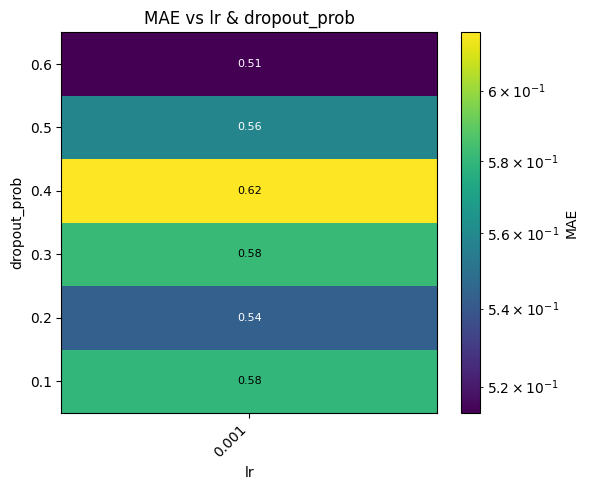

0.6805642247200012 1.363674521446228


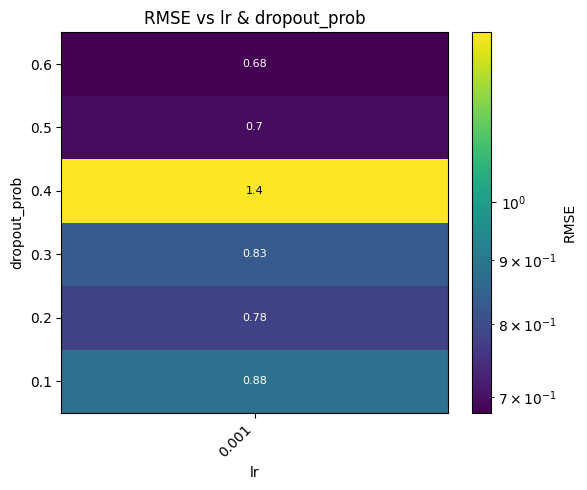

0.9168316125869751 1.6984080076217651


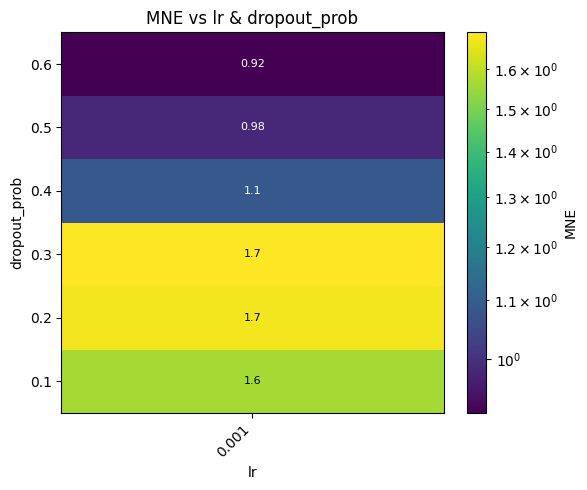

0.19016049802303314 2.867903470993042


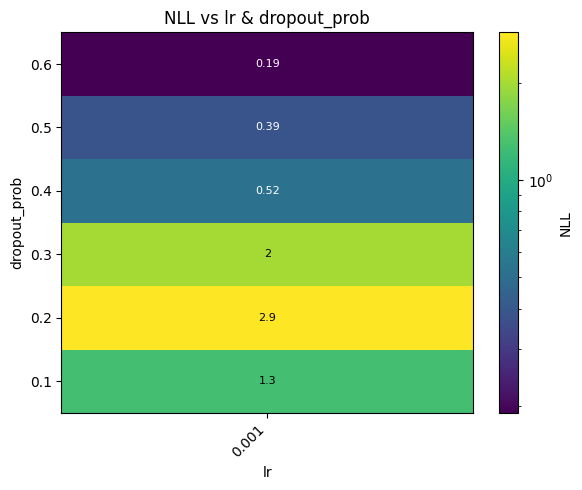

0.1480399851006069 0.27845884311820124


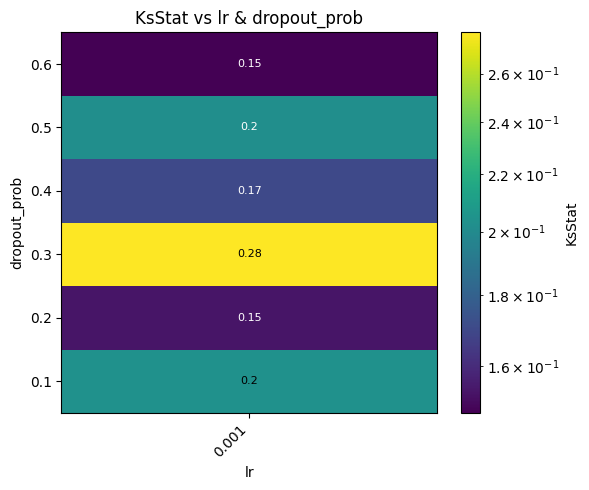

0.32278501987457275 0.5738504528999329


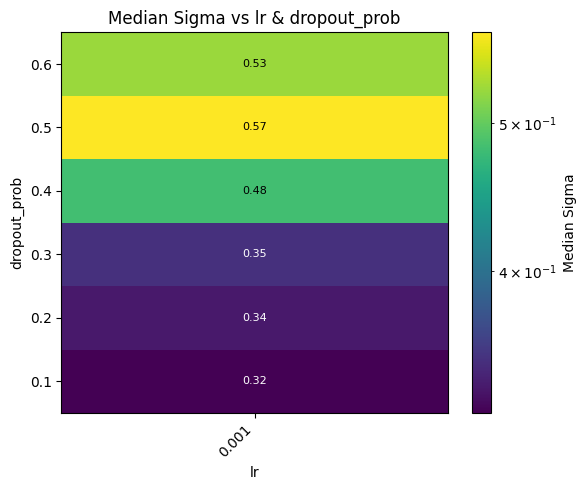

0.05817949399352074 0.24883504211902618


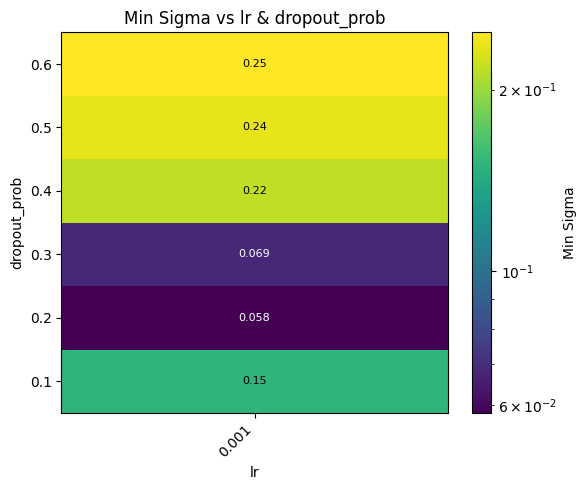

In [332]:
import matplotlib.pyplot as plt
import numpy as np
import inspect
import matplotlib.colors as mcolors  # Make sure this import is at the top

def Plot_2d_Statistics(config_dict, x_param, y_param, stat_func_list=None, stat_names=None, X_test=None, y_true=None):
    if stat_func_list is None:
        stat_func_list = [mae, rmse]
    if stat_names is None:
        stat_names = [f.__name__ for f in stat_func_list]

    x_vals = sorted(set(run["params"][x_param] for run in config_dict.values()))
    y_vals = sorted(set(run["params"][y_param] for run in config_dict.values()))
    x_map = {v: i for i, v in enumerate(x_vals)}
    y_map = {v: i for i, v in enumerate(y_vals)}

    for i_stat, (stat_func, stat_name) in enumerate(zip(stat_func_list, stat_names)):
        Z = np.full((len(y_vals), len(x_vals)), np.nan)
        
        for run in config_dict.values():
            model = run["model"]
            model.eval()
            X = X_test
            Y = y_test
            #X = X_train
            #Y = y_train

            with torch.no_grad():
                y_pred, sigma = model(X_test[0], X_test[1])

                # Get how many args this function wants
                n_args = len(inspect.signature(stat_func).parameters)

                # Compute stat value with the correct number of arguments
                if n_args == 1:
                    stat_val = stat_func(sigma)
                elif n_args == 2:
                    stat_val = stat_func(y_true, y_pred)
                elif n_args == 3:
                    stat_val = stat_func(y_true, y_pred, sigma)
                else:
                    raise ValueError(f"{stat_func.__name__} expects {n_args} args. Not supported.")

                # Handle case where result is a tuple (like from kstest)
                if isinstance(stat_val, tuple):
                    # Default: extract p-value (2nd value)
                    stat_val = stat_val[0]

                x_i = x_map[run["params"][x_param]]
                y_i = y_map[run["params"][y_param]]
                Z[y_i, x_i] = stat_val.item() if hasattr(stat_val, 'item') else stat_val

        # Plot Z with plt.imshow or similar (not included here)

        plt.figure(figsize=(6, 5))
        print(np.nanmin(Z[Z > 0]), np.nanmax(Z))
        
        norm = mcolors.LogNorm(vmin=np.nanmin(Z[Z > 0]), vmax=np.min([np.nanmax(Z), 1e20]))
        
        im = plt.imshow(
            Z,
            origin='lower',
            aspect='auto',
            cmap='viridis',
            norm=norm
        )

        plt.colorbar(im, label=stat_names[i_stat])

        # Axis ticks and labels (formatted)
        x_labels = [f"{x:.3g}" if isinstance(x, float) else str(x) for x in x_vals]
        y_labels = [f"{y:.3g}" if isinstance(y, float) else str(y) for y in y_vals]
        plt.xticks(ticks=np.arange(len(x_vals)), labels=x_labels, rotation=45, ha='right')
        plt.yticks(ticks=np.arange(len(y_vals)), labels=y_labels)

        # Annotations inside cells
        for y_i in range(len(y_vals)):
            for x_i in range(len(x_vals)):
                val = Z[y_i, x_i]
                if not np.isnan(val):
                    text_color = "white" if norm(val) < 0.5 else "black"
                    plt.text(x_i, y_i, f"{val:.2g}", ha="center", va="center", color=text_color, fontsize=8)

        plt.xlabel(x_param)
        plt.ylabel(y_param)
        plt.title(f"{stat_names[i_stat]} vs {x_param} & {y_param}")
        plt.tight_layout()
        plt.show()



print('\n\n\n## Test Data Version')
SumStats_list = []    
flattened_name_list = []
for i, model_name in enumerate(model_names):
    #X_train, X_test, y_train, y_test, X_test_BDATA, y_test_BDATA, ATTRIBUTES, SCALER, POLY_SCALER = model_data[i]

    stat_func_list = [mae, rmse, mean_normalized_error, negative_log_likelihood, z_score_ks_test, median_sigma2, min_sigma2]
    stat_names = ["MAE", "RMSE", "MNE", "NLL", 'KsStat', 'Median Sigma', 'Min Sigma']
    #X, X_period, Y = model_train_data_statistics[i], model_train_data_periodogram[i], model_train_data_Y[i] 
    X, X_period, Y = model_test_data_statistics[i], model_test_data_periodogram[i], model_test_data_Y[i] 
    #X, X_period, Y = model_valid_data_statistics[i], model_valid_data_periodogram[i], model_valid_data_Y[i] 

    Plot_2d_Statistics(
        config_dict=all_runs_log[model_name],
        x_param="lr",
        y_param="dropout_prob",
        X_test=(X, X_period),
        y_true=Y,
        stat_func_list=stat_func_list,
        stat_names=stat_names
        
    )

#PlotSummaryStats(SumStats_list, flattened_name_list)




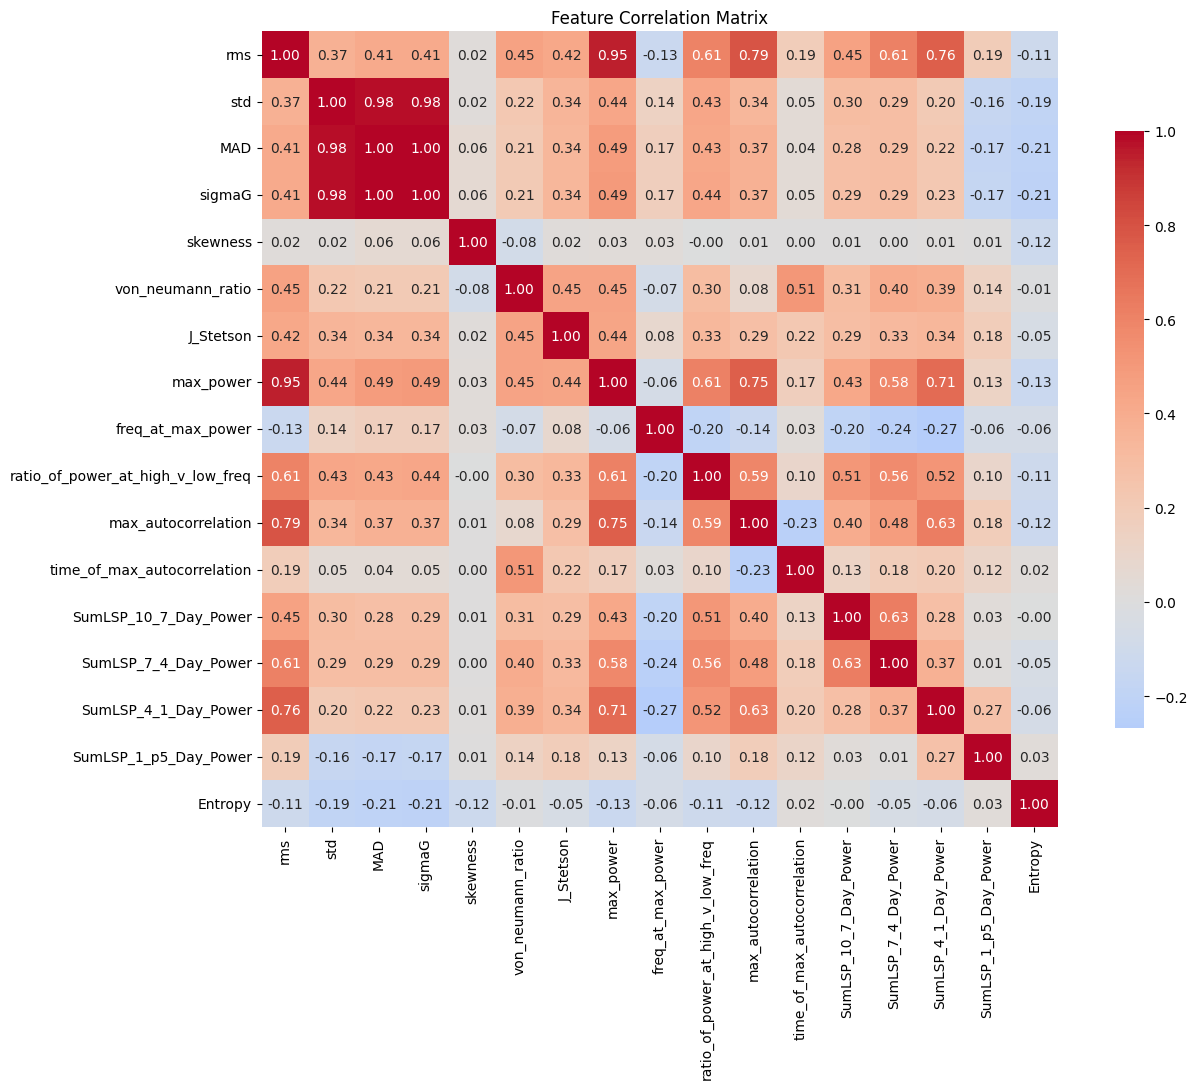

array([[ 1.00000000e+00,  3.69033022e-01,  4.07341237e-01,
         4.11926178e-01,  1.86640885e-02,  4.51033318e-01,
         4.21400466e-01,  9.49052357e-01, -1.32690758e-01,
         6.05759648e-01,  7.88194100e-01,  1.86414282e-01,
         4.51649555e-01,  6.13531968e-01,  7.57291547e-01,
         1.89578277e-01, -1.11501220e-01],
       [ 3.69033022e-01,  1.00000000e+00,  9.75696491e-01,
         9.76077401e-01,  2.23159556e-02,  2.19204616e-01,
         3.41784737e-01,  4.35238874e-01,  1.43199679e-01,
         4.34453940e-01,  3.40257887e-01,  4.80738597e-02,
         2.99101383e-01,  2.93474031e-01,  2.03136849e-01,
        -1.56056917e-01, -1.91760267e-01],
       [ 4.07341237e-01,  9.75696491e-01,  1.00000000e+00,
         9.99364122e-01,  5.74575602e-02,  2.05142390e-01,
         3.40088072e-01,  4.89461554e-01,  1.71247071e-01,
         4.29165602e-01,  3.67141751e-01,  4.44047785e-02,
         2.82285654e-01,  2.88640412e-01,  2.19459981e-01,
        -1.69819509e-01, -2.0

In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlation_matrix(X, feature_names=None, figsize=(10, 8), annot=False):
    # Convert to NumPy if needed
    if isinstance(X, torch.Tensor):
        X = X.detach().cpu().numpy()

    # Compute correlation matrix
    corr_matrix = np.corrcoef(X, rowvar=False)

    # Create default feature names if not provided
    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(X.shape[1])]

    # Plot using seaborn
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, xticklabels=feature_names, yticklabels=feature_names, 
                cmap="coolwarm", center=0, annot=annot, fmt=".2f", square=True, cbar_kws={"shrink": 0.75})
    plt.title("Feature Correlation Matrix")
    plt.tight_layout()
    plt.show()

    return corr_matrix

plot_correlation_matrix(X_train, feature_names=ATTRIBUTES, figsize=(14, 11), annot=True)





## Test Data Version


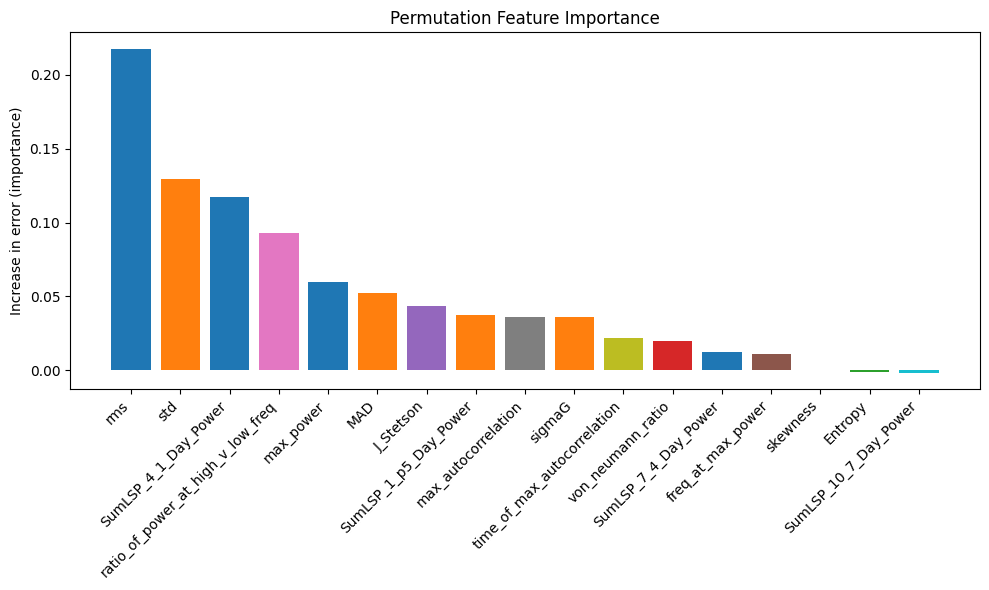

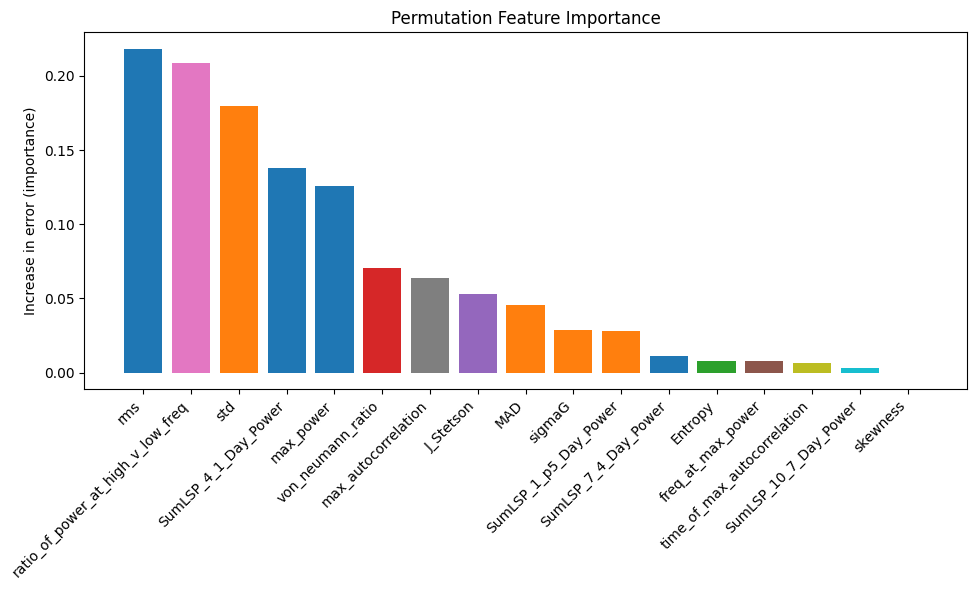

In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import itertools


def permutation_importance(model, X_val, y_val, metric, feature_names=None, n_repeats=5, plot=True, corr_threshold=0.8):
    with torch.no_grad():
        model.eval()
        
        y_pred, sigma_pred = model(X_val)
        baseline = metric(y_val, y_pred)
        importances = []

        for i in range(X_val.shape[1]):
            scores = []
            for _ in range(n_repeats):
                X_perm = X_val.clone()
                X_perm[:, i] = X_perm[torch.randperm(X_perm.size(0)), i]
                y_pred, sigma_pred = model(X_perm)
                score = metric(y_val, y_pred)
                scores.append(score)
            importances.append(np.mean(scores) - baseline)

        importances = np.array(importances)
        
        if feature_names is None:
            feature_names = [f"Feature {i}" for i in range(len(importances))]

        # Sort by importance descending
        sorted_indices = np.argsort(importances)[::-1]
        sorted_importances = importances[sorted_indices]
        sorted_names = [feature_names[i] for i in sorted_indices]

        # Compute correlation matrix and group features
        X_np = X_val.detach().cpu().numpy()
        X_scaled = StandardScaler().fit_transform(X_np)
        corr_matrix = np.corrcoef(X_scaled, rowvar=False)

        # Group features by correlation threshold
        groups = []
        assigned = set()
        for i in range(len(corr_matrix)):
            if i in assigned:
                continue
            group = {i}
            for j in range(i+1, len(corr_matrix)):
                if abs(corr_matrix[i, j]) > corr_threshold:
                    group.add(j)
            assigned |= group
            groups.append(group)

        # Assign a color to each group
        color_palette = sns.color_palette("tab10", n_colors=len(groups))
        feature_to_color = {}
        for color, group in zip(color_palette, groups):
            for idx in group:
                feature_to_color[idx] = color

        # Create a list of colors for the sorted features
        sorted_colors = [feature_to_color[i] for i in sorted_indices]

        if plot:
            plt.figure(figsize=(10, 6))
            bars = plt.bar(range(len(sorted_names)), sorted_importances, color=sorted_colors)
            plt.xticks(range(len(sorted_names)), sorted_names, rotation=45, ha='right')
            plt.ylabel("Increase in error (importance)")
            plt.title("Permutation Feature Importance")
            plt.tight_layout()
            plt.show()

    return list(zip(sorted_names, sorted_importances))


print('\n\n\n## Test Data Version')
SumStats_list = []    
flattened_name_list = []
for i, model_name in enumerate(model_names):
    #X_train, X_test, y_train, y_test, X_test_BDATA, y_test_BDATA, ATTRIBUTES, SCALER, POLY_SCALER = model_data[i]
    for run_id, config_dict in enumerate(ParameterGrid(params)):
        #if (config_dict['lr']==0.0001) and (config_dict['batch_size']==100):
        #if (config_dict['lr']==0.0001) and (config_dict['batch_size']==100) and (config_dict['decoupled']==False):
        #if (config_dict['Layer1_Size']==32) and (config_dict['decoupled']):
        if (config_dict['lr']==params['lr'][1]) and (config_dict['batch_size']==1000):
        #if (config_dict['batch_size']==1000):

        #if not (config_dict['decoupled']):
        #if True:
            model = all_runs_log[model_name][run_id]['model']
            flattened_name_list.append(str(config_dict))
            
            X = X_test_BDATA[::10, :]
            Y = y_test_BDATA[::10, :]#.numpy().flatten()

            permutation_importance(model, X, Y, rmse, feature_names=ATTRIBUTES, n_repeats=2, plot=True)

        #break


#permutation_importance(model, X_test, y_test, rmse, feature_names=ATTRIBUTES, n_repeats=5, plot=True):

In [56]:
params

{'lr': array([1.00000000e-02, 1.77827941e-03, 3.16227766e-04, 5.62341325e-05,
        1.00000000e-05]),
 'batch_size': array([   1000.        ,    5623.4132519 ,   31622.77660168,
         177827.94100389, 1000000.        ]),
 'n_epochs': [30],
 'decoupled': [False],
 'n_layers': [2, 3],
 'Layer1_Size': [64],
 'Layer2_Size': [64],
 'artificial_loss_weight_factor': [1],
 'weight_decay': [1e-08]}

# Try Models W/ Uncertainties:

In [ ]:
# # Test Mutliple Models:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.init as init
# import numpy as np
# from torch.distributions.normal import Normal
# import torch
# import torch.nn as nn
# import torch.nn.init as init


# #Linear Regression W/ Sigma
# class LR_Sigma(nn.Module):
#     def __init__(self, input_dim):
#         super(LinearRegressionWithUncertainty, self).__init__()
#         # Linear layer for predicting the target value
#         self.mean_layer = nn.Linear(input_dim, 1)
#         # Linear layer for predicting the standard deviation (sigma)
#         self.sigma_layer = nn.Linear(input_dim, 1)
        
#     def forward(self, x):
#         mean_pred = self.mean_layer(x)
#         sigma_pred = torch.exp(self.sigma_layer(x))  # Ensure that sigma is positive by exponentiating
#         return mean_pred, sigma_pred

# class SimpleNN_3Layer_RELU_NoSigma(nn.Module):
#     def __init__(self, input_dim, x1, x2, init_method="xavier"):
#         super(SimpleNN_3Layer_RELU, self).__init__()
#         self.fc1 = nn.Linear(input_dim, x1)  # Input layer
#         self.fc2 = nn.Linear(x1, x2)  # Hidden layer
#         self.fc3 = nn.Linear(x2, 1)  # Output layer

#         # Apply chosen initialization method
#         self.init_method = init_method.lower()
#         self.apply(self._init_weights)

#     def _init_weights(self, m):
#         """Custom weight initialization function."""
#         if isinstance(m, nn.Linear):
#             if self.init_method == "kaiming":
#                 init.kaiming_normal_(m.weight, nonlinearity='relu')
#             elif self.init_method == "xavier":
#                 init.xavier_normal_(m.weight)
#             elif self.init_method == "small_random":
#                 init.normal_(m.weight, mean=0.0, std=0.01)
#             elif self.init_method == "orthogonal":
#                 init.orthogonal_(m.weight)
#             elif self.init_method == "hybrid":
#                 if m in [self.fc1, self.fc2]:
#                     init.kaiming_normal_(m.weight, nonlinearity='relu')
#                 else:
#                     init.xavier_normal_(m.weight)

#             init.zeros_(m.bias)  # Initialize biases to zero

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         y_pred = self.fc3(x)  # Single output
#         return y_pred


# # Simple NN with sigma output

# class SimpleNN_3Layer_RELU(nn.Module):
#     def __init__(self, input_dim, x1, x2, init_method="xavier"):
#         super(SimpleNN_3Layer_RELU, self).__init__()
#         self.fc1 = nn.Linear(input_dim, x1)  # Input layer
#         self.fc2 = nn.Linear(x1, x2)  # Hidden layer
#         self.fc3_mean = nn.Linear(x2, 1)  # Output: Mean prediction
#         self.fc3_log_sigma = nn.Linear(x2, 1)  # Output: Log variance prediction

#         # Apply chosen initialization method
#         self.init_method = init_method.lower()
#         self.apply(self._init_weights)

#     def _init_weights(self, m):
#         """Custom weight initialization function."""
#         if isinstance(m, nn.Linear):
#             if self.init_method == "kaiming":
#                 init.kaiming_normal_(m.weight, nonlinearity='relu')
#             elif self.init_method == "xavier":
#                 init.xavier_normal_(m.weight)
#             elif self.init_method == "small_random":
#                 init.normal_(m.weight, mean=0.0, std=0.01)
#             elif self.init_method == "orthogonal":
#                 init.orthogonal_(m.weight)
#             elif self.init_method == "hybrid":
#                 if m in [self.fc1, self.fc2]:
#                     init.kaiming_normal_(m.weight, nonlinearity='relu')
#                 else:
#                     init.xavier_normal_(m.weight)

#             init.zeros_(m.bias)  # Initialize biases to zero

#             # Special handling for log_sigma layer
#             if m is self.fc3_log_sigma:
#                 m.bias.data.fill_(-3)  # Helps prevent large initial sigma values

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         y_pred = self.fc3_mean(x)  # Mean output
#         log_sigma_pred = self.fc3_log_sigma(x)  # Log variance output
#         sigma_pred = torch.exp(log_sigma_pred)  # Ensure sigma is positive
#         return y_pred, sigma_pred

# class SimpleNN_3Layer_Sigmoid(nn.Module):
#     def __init__(self, input_dim, x1, x2):
#         super(SimpleNN_3Layer_Sigmoid, self).__init__()
#         self.fc1 = nn.Linear(input_dim, x1)  # Input layer
#         self.fc2 = nn.Linear(x1, x2)  # Hidden layer
#         self.fc3_mean = nn.Linear(x2, 1)  # Output: Mean prediction
#         self.fc3_log_sigma = nn.Linear(x2, 1)  # Output: Log variance prediction

#     def forward(self, x):
#         x = torch.sigmoid(self.fc1(x))
#         x = torch.sigmoid(self.fc2(x))
#         y_pred = self.fc3_mean(x)  # Mean output
#         log_sigma_pred = self.fc3_log_sigma(x)  # Log variance output
#         sigma_pred = torch.exp(log_sigma_pred)  # Important that sigma is positive
#         #print("    median y, sigma: ", torch.median(y_pred), torch.median(sigma_pred))
#         return y_pred, sigma_pred

# class SimpleNN_4Layer_RELU(nn.Module):
#     def __init__(self, input_dim, x1, x2, x3):
#         super(SimpleNN_4Layer_RELU, self).__init__()
#         self.fc1 = nn.Linear(input_dim, x1)  # Input layer
#         self.fc2 = nn.Linear(x1, x2)  # Hidden layer
#         self.fc3 = nn.Linear(x2, x3)  # Hidden layer
#         self.fc4_mean = nn.Linear(x3, 1)  # Output: Mean prediction
#         self.fc4_log_sigma = nn.Linear(x3, 1)  # Output: Log variance prediction

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         y_pred = self.fc4_mean(x)  # Mean output
#         log_sigma_pred = self.fc4_log_sigma(x)  # Log variance output
#         sigma_pred = torch.exp(log_sigma_pred)  # Ensure sigma is positive
#         return y_pred, sigma_pred

# class SimpleNN_5Layer_RELU(nn.Module):
#     def __init__(self, input_dim, x1, x2, x3, x4):
#         super(SimpleNN_5Layer_RELU, self).__init__()
#         self.fc1 = nn.Linear(input_dim, x1)  # Input layer
#         self.fc2 = nn.Linear(x1, x2)  # Hidden layer
#         self.fc3 = nn.Linear(x2, x3)  # Hidden layer
#         self.fc4 = nn.Linear(x3, x4)  # Hidden layer
#         self.fc5_mean = nn.Linear(x4, 1)  # Output: Mean prediction
#         self.fc5_log_sigma = nn.Linear(x4, 1)  # Output: Log variance prediction

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = torch.relu(self.fc4(x))
#         y_pred = self.fc5_mean(x)  # Mean output
#         log_sigma_pred = self.fc5_log_sigma(x)  # Log variance output
#         sigma_pred = torch.exp(log_sigma_pred)  # Ensure sigma is positive
#         return y_pred, sigma_pred


# def calc_median_sigma(model, validation_set):
#     # Evaluate model and get predictions
#     model.eval()
#     with torch.no_grad():
#         y_pred_test, sigma_pred_test = model(validation_set)
#     return torch.median(sigma_pred_test)

# def calc_Loss_Components(model, validation_X, y_true):
#     # Evaluate model and get predictions
#     model.eval()
#     with torch.no_grad():
#         y_pred, sigma_pred = model(validation_X)
        
#     return 0.5 * torch.mean(((y_true - y_pred) ** 2) / (sigma_pred ** 2)), 0.5 * torch.mean(torch.log(sigma_pred))


# # Define the GaussianNLLLoss class
# class GaussianNLLLoss_ME(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, y_pred, y_true, sigma_pred):
#         sigma_pred = torch.clamp(sigma_pred, min=1e-6)  # Avoid log(0)
#         loss = 0.5 * (((y_true - y_pred) ** 2) / (sigma_pred ** 2) +  torch.log(sigma_pred))

#         if False:
#             print(torch.min(y_true), torch.min(y_pred), torch.min(sigma_pred))
#         return loss.mean()

